In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import collections
import random
import math

%matplotlib inline

In [2]:
import keras 

from keras.layers import Lambda, Input, Dense, LSTM, SimpleRNN, GRU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.regularizers import l1, l2
from keras.utils import np_utils, plot_model
from keras.layers import concatenate
from keras.layers.core import Reshape


import pydot
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
class One_Talking_No_Time_Best_World():

    # Enumeration of possible actions
    class Actions():
        silence = 0
        a = 1
        b = 2
        c = 3
        nothing = 4
        choose_1 = 5
        choose_2 = 6
        choose_3 = 7 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): #choose true or false

        # Action enumeration for this environment
        #d = {1:"a",2:"b",3:"c"}
        #for i in range(num_ent):
        #    d[i+4] = str(i+1)
        #self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.talking_decay = 0.995
        self.actions1 = collections.deque(maxlen=100)
        self.actions2 = collections.deque(maxlen=100)
                
    def step(self, ag1_action, ag2_action, choose, reward1 = 0, reward2 = 0):
        ag1_input = np.array([np.random.random()]) #UNIFORM/bimodal NOISE
        ag2_input = np.random.normal(0,0.01,(4,)) * 0 #talking binary (3) + noise
                
        if choose: # step of choice
            self.actions1.append(ag1_action)
            self.actions2.append(ag2_action)
            a1_rew = 0
            a2_rew = 0
            
            if len(self.actions1) > 99:
                a1_rew = ((1/self.num_ent) - self.actions1.count(ag1_action)/100) * 2
                a2_rew = ((1/self.num_ent) - self.actions2.count(ag2_action)/100) * 2
                
            if ag2_action == ag1_action: 
                reward1 = self.winning_reward + a1_rew
                reward2 = self.winning_reward + a2_rew
                
            else:
                reward1 = a1_rew#-1
                reward2 = a2_rew#-1
                    
        else: # agent 1 talking 
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, reward1, reward2)

In [104]:
# Deep Q-learning Agent
class DQNAgent_2_fake_teacher:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=11)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.01
 
        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()
 
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        t = 0
        model = Sequential()
        model.add(Dense(3, input_dim=self.state_size, activation='relu'))
        model.add(Dense(3, activation='relu'))
        if self.talking_action_size > 0:
            t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + t + self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
       
        assert self.choices == self.talking_action_size, "Fake agent assumes equal sizes of communication and action spaces"
 
        choice = random.randrange(self.choices + 1)
 
        return [choice, choice] # Todo - if different sizes of blah
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target > 2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good)
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size+1] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
 
 
# Deep Q-learning Agent
class DQNAgent_2_fake_student:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=100)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.3
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.01
 
        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()
 
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        t = 0
        model = Sequential()
        model.add(Dense(3, input_dim=self.state_size, activation='relu'))
        model.add(Dense(3, activation='relu'))
        if self.talking_action_size > 0:
            t = 1 # nothing for talking
        model.add(Dense(self.talking_action_size + t + self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
       
        #assert self.choices == self.talking_action_size, "Fake agent assumes equal sizes of communication and action spaces"
 
        if np.all(state < 0.5):
          return self.choices
 
        choice = np.argmax(state)
 
        return choice # Todo - if different sizes of blah
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            if target > 2: # won the game
                K.set_value(self.model.optimizer.lr, self.learning_rate_good)
            else:
                K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action[0]] = target # talk
                target_f[0][action[1]+self.talking_action_size+1] = target # choose
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [105]:
class DQNAgent_2_new:
    def __init__(self, state_size, talking_action_size, choices):
        self.state_size = state_size
        self.memory = collections.deque(maxlen=11)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.0001
 
        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model()
 
 
    def _build_model_teacher(self):
        # Neural Net for Deep-Q learning Model
        assert self.talking_action_size > 0, "Zero talking for teacher"
        t = 1
       
        model = Sequential()
        model.add(Dense(15, input_dim=self.state_size + self.talking_action_size + 1, activation='relu'))
        model.add(Dense(15, activation='relu'))
 
        model.add(Dense(self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
     
    def _build_model_student(self):
        # Neural Net for Deep-Q learning Model
 
        assert self.talking_action_size == 0, "Student model called with nonzero talking action size"
 
        model = Sequential()
        model.add(Dense(15, input_dim=self.state_size, activation='relu'))
        model.add(Dense(15, activation='relu'))
       
        model.add(Dense(self.choices + 1, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
 
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
       
        if self.talking_action_size > 0:
            return self._build_model_teacher()
        else:
            return self._build_model_student()
       
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
 
        ### Exploration
        if np.random.rand() <= self.epsilon:
            if self.talking_action_size == 0:
                return random.randrange(self.choices+1)
            else:
                return [random.randrange(self.talking_action_size+1), random.randrange(self.choices+1)]
 
        ### Acting for student
        if self.talking_action_size == 0:
         
            state = np.expand_dims(state, axis=0)
            act_values = self.model.predict(state, batch_size=1)
 
            return np.argmax(act_values[0])  # returns choice from 0 to n-1
 
 
        # Acting for teacher
        else:
 
          max_q = -float("infinity")
          max_talk = None
          max_action = None
 
          for i in range(self.talking_action_size + 1):
 
            talking = np.zeros(self.talking_action_size + 1)
            talking[i] = 1
 
            state_cur = np.expand_dims(np.hstack([state, talking]), axis=0)
 
            act_values = self.model.predict(state_cur, batch_size=1)
 
            cur_max = np.max(act_values)
           
            if cur_max > max_q:
 
              max_q = cur_max
              max_action = np.argmax(act_values[0])
              max_talk = i
 
          assert max_talk is not None
          assert max_action is not None
 
          return [max_talk, max_action]
                           
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            state = np.expand_dims(state, axis=0)
            target = reward
            #if target > 2: # won the game
            #    K.set_value(self.model.optimizer.lr, self.learning_rate_good)
            #else:
            #    K.set_value(self.model.optimizer.lr, self.learning_rate_bad)
            if self.talking_action_size == 0:
            #if not done:
            #    target = reward + self.gamma * np.amax(self.model.predict(next_state, batch_size=1)[0])
                target_f = self.model.predict(state, batch_size=1)
                target_f[0][action] = target
                self.model.fit(state, target_f, batch_size=1, epochs=1, verbose=0)
            else:
                one_hot_talk = np.zeros(self.talking_action_size + 1)
                one_hot_talk[action[0]] = 1
                cur_state = np.hstack([state, one_hot_talk[np.newaxis]])
 
                target_f = self.model.predict(cur_state, batch_size=1)
                #target_f[0][action[0]] = target # talk
                target_f[0][action[1]] = target # choose
                self.model.fit(cur_state, target_f, batch_size=1, epochs=1, verbose=0)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [106]:
agent1 = DQNAgent_2_new(1, 3, 3) # can talk
agent2 = DQNAgent_2_new(4, 0, 3)

In [107]:
env = One_Talking_No_Time_Best_World(9, 1, 0)

episode: 0/5500, score1: 0, score2: 0
episode: 1/5500, score1: 0, score2: 0
episode: 2/5500, score1: 1, score2: 1
episode: 3/5500, score1: 0, score2: 0
episode: 4/5500, score1: 1, score2: 1
episode: 5/5500, score1: 0, score2: 0
episode: 6/5500, score1: 1, score2: 1
episode: 7/5500, score1: 0, score2: 0
episode: 8/5500, score1: 1, score2: 1
episode: 9/5500, score1: 0, score2: 0
episode: 10/5500, score1: 0, score2: 0
episode: 11/5500, score1: 0, score2: 0
episode: 12/5500, score1: 1, score2: 1
episode: 13/5500, score1: 1, score2: 1
episode: 14/5500, score1: 0, score2: 0
episode: 15/5500, score1: 1, score2: 1
episode: 16/5500, score1: 0, score2: 0
episode: 17/5500, score1: 0, score2: 0
episode: 18/5500, score1: 0, score2: 0
episode: 19/5500, score1: 0, score2: 0
episode: 20/5500, score1: 1, score2: 1
episode: 21/5500, score1: 0, score2: 0
episode: 22/5500, score1: 0, score2: 0
episode: 23/5500, score1: 0, score2: 0
episode: 24/5500, score1: 0, score2: 0
episode: 25/5500, score1: 0, score2

episode: 160/5500, score1: -0.2777777777777778, score2: -0.2577777777777778
episode: 161/5500, score1: -0.2977777777777778, score2: -0.2777777777777778
episode: 162/5500, score1: 0.7022222222222222, score2: 0.7022222222222222
episode: 163/5500, score1: -0.2977777777777778, score2: -0.33777777777777784
episode: 164/5500, score1: -0.47777777777777775, score2: -0.2777777777777778
episode: 165/5500, score1: 0.9222222222222223, score2: 0.7022222222222222
episode: 166/5500, score1: 0.5422222222222222, score2: 0.6622222222222222
episode: 167/5500, score1: -0.0977777777777778, score2: -0.2777777777777778
episode: 168/5500, score1: -0.0977777777777778, score2: -0.35777777777777775
episode: 169/5500, score1: -0.11777777777777781, score2: -0.2777777777777778
episode: 170/5500, score1: 0.7422222222222222, score2: 0.7022222222222222
episode: 171/5500, score1: -0.2977777777777778, score2: -0.2977777777777778
episode: 172/5500, score1: 0.6822222222222222, score2: 0.8222222222222222
episode: 173/5500,

episode: 272/5500, score1: -0.2377777777777778, score2: -0.33777777777777784
episode: 273/5500, score1: -0.2577777777777778, score2: -0.37777777777777777
episode: 274/5500, score1: -0.2977777777777778, score2: -0.2977777777777778
episode: 275/5500, score1: -0.3177777777777778, score2: -0.3977777777777778
episode: 276/5500, score1: -0.2577777777777778, score2: -0.33777777777777784
episode: 277/5500, score1: -0.2577777777777778, score2: -0.2977777777777778
episode: 278/5500, score1: -0.2777777777777778, score2: -0.3977777777777778
episode: 279/5500, score1: -0.33777777777777784, score2: -0.11777777777777781
episode: 280/5500, score1: 0.6422222222222222, score2: 0.6622222222222222
episode: 281/5500, score1: 0.6222222222222222, score2: 0.6422222222222222
episode: 282/5500, score1: -0.2577777777777778, score2: -0.37777777777777777
episode: 283/5500, score1: -0.2777777777777778, score2: -0.35777777777777775
episode: 284/5500, score1: -0.2177777777777778, score2: -0.35777777777777775
episode:

episode: 383/5500, score1: 0.8422222222222222, score2: 0.8222222222222222
episode: 384/5500, score1: 0.3422222222222222, score2: 0.5422222222222222
episode: 385/5500, score1: 0.3222222222222222, score2: 0.5222222222222223
episode: 386/5500, score1: 0.9622222222222222, score2: 0.8422222222222222
episode: 387/5500, score1: 0.7422222222222222, score2: 0.6822222222222222
episode: 388/5500, score1: -0.6777777777777778, score2: -0.33777777777777784
episode: 389/5500, score1: 0.30222222222222217, score2: 0.5622222222222222
episode: 390/5500, score1: -0.05777777777777782, score2: -0.4377777777777778
episode: 391/5500, score1: -0.7177777777777777, score2: -0.1777777777777778
episode: 392/5500, score1: -0.7377777777777778, score2: -0.1777777777777778
episode: 393/5500, score1: -0.19777777777777777, score2: -0.19777777777777777
episode: 394/5500, score1: 0.24222222222222223, score2: 0.5422222222222222
episode: 395/5500, score1: 0.8622222222222222, score2: 0.8022222222222222
episode: 396/5500, sco

episode: 491/5500, score1: 0.5822222222222222, score2: 0.6822222222222222
episode: 492/5500, score1: -0.2177777777777778, score2: -0.33777777777777784
episode: 493/5500, score1: -0.4177777777777778, score2: -0.5177777777777778
episode: 494/5500, score1: -0.2377777777777778, score2: -0.35777777777777775
episode: 495/5500, score1: 0.5622222222222222, score2: 0.6222222222222222
episode: 496/5500, score1: -0.45777777777777784, score2: -0.0977777777777778
episode: 497/5500, score1: -0.35777777777777775, score2: -0.1777777777777778
episode: 498/5500, score1: -0.2377777777777778, score2: -0.37777777777777777
episode: 499/5500, score1: -0.47777777777777775, score2: -0.47777777777777775
episode: 500/5500, score1: -0.49777777777777776, score2: -0.19777777777777777
episode: 501/5500, score1: 0.6622222222222222, score2: 0.9222222222222223
episode: 502/5500, score1: -0.07777777777777778, score2: -0.07777777777777778
episode: 503/5500, score1: -0.49777777777777776, score2: -0.0977777777777778
episod

episode: 601/5500, score1: -0.2177777777777778, score2: -0.6377777777777778
episode: 602/5500, score1: -0.7377777777777778, score2: -0.0977777777777778
episode: 603/5500, score1: 0.24222222222222223, score2: 0.3422222222222222
episode: 604/5500, score1: -0.7577777777777778, score2: -0.0977777777777778
episode: 605/5500, score1: -0.2377777777777778, score2: -0.2577777777777778
episode: 606/5500, score1: -0.2577777777777778, score2: -0.6777777777777778
episode: 607/5500, score1: 0.8822222222222222, score2: 0.9022222222222223
episode: 608/5500, score1: 0.24222222222222223, score2: 0.3222222222222222
episode: 609/5500, score1: 0.2222222222222222, score2: 0.30222222222222217
episode: 610/5500, score1: -0.7977777777777778, score2: -0.2177777777777778
episode: 611/5500, score1: -0.8177777777777778, score2: -0.11777777777777781
episode: 612/5500, score1: -0.11777777777777781, score2: -0.13777777777777778
episode: 613/5500, score1: 0.04222222222222222, score2: -0.11777777777777781
episode: 614/

episode: 714/5500, score1: -0.2577777777777778, score2: -0.6177777777777778
episode: 715/5500, score1: -0.2777777777777778, score2: -0.6377777777777778
episode: 716/5500, score1: -0.5177777777777778, score2: -0.2377777777777778
episode: 717/5500, score1: 0.4822222222222222, score2: 0.3622222222222222
episode: 718/5500, score1: 0.7422222222222222, score2: 0.7022222222222222
episode: 719/5500, score1: -0.0977777777777778, score2: -0.3177777777777778
episode: 720/5500, score1: -0.5377777777777778, score2: 0.06222222222222221
episode: 721/5500, score1: -0.2777777777777778, score2: -0.6377777777777778
episode: 722/5500, score1: 0.4422222222222222, score2: 0.3622222222222222
episode: 723/5500, score1: -0.5577777777777778, score2: -0.2377777777777778
episode: 724/5500, score1: -0.5777777777777778, score2: -0.33777777777777784
episode: 725/5500, score1: -0.2777777777777778, score2: -0.6377777777777778
episode: 726/5500, score1: -0.0977777777777778, score2: 0.06222222222222221
episode: 727/5500

episode: 824/5500, score1: 0.2022222222222222, score2: -0.017777777777777892
episode: 825/5500, score1: -0.7977777777777778, score2: -0.07777777777777778
episode: 826/5500, score1: 0.0222222222222222, score2: -1.017777777777778
episode: 827/5500, score1: -0.8177777777777778, score2: -0.0977777777777778
episode: 828/5500, score1: -0.8377777777777778, score2: -0.0377777777777778
episode: 829/5500, score1: 0.14222222222222214, score2: 0.0022222222222222365
episode: 830/5500, score1: 1.0222222222222221, score2: 1.0022222222222221
episode: 831/5500, score1: 0.12222222222222212, score2: -0.017777777777777892
episode: 832/5500, score1: -0.8977777777777779, score2: -0.0377777777777778
episode: 833/5500, score1: 0.08222222222222231, score2: -0.017777777777777892
episode: 834/5500, score1: -0.2777777777777778, score2: -0.01777777777777778
episode: 835/5500, score1: 0.0222222222222222, score2: -0.07777777777777778
episode: 836/5500, score1: -0.8977777777777779, score2: -0.01777777777777778
episod

episode: 933/5500, score1: -0.8977777777777779, score2: -0.0977777777777778
episode: 934/5500, score1: -0.9177777777777777, score2: 0.0022222222222222088
episode: 935/5500, score1: 0.04222222222222222, score2: -1.037777777777778
episode: 936/5500, score1: -0.05777777777777782, score2: -0.11777777777777781
episode: 937/5500, score1: -0.2377777777777778, score2: -1.017777777777778
episode: 938/5500, score1: 0.7422222222222222, score2: 1.0022222222222221
episode: 939/5500, score1: 0.7222222222222222, score2: 0.9822222222222222
episode: 940/5500, score1: 0.7222222222222222, score2: 0.9622222222222222
episode: 941/5500, score1: 0.7022222222222222, score2: 0.9422222222222222
episode: 942/5500, score1: -0.3177777777777778, score2: -0.0977777777777778
episode: 943/5500, score1: -0.8377777777777778, score2: -0.07777777777777778
episode: 944/5500, score1: 0.6622222222222222, score2: 0.9022222222222223
episode: 945/5500, score1: 0.6422222222222222, score2: 0.8822222222222222
episode: 946/5500, sc

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

episode: 1000/5500, score1: -0.11777777777777781, score2: -0.8177777777777778
episode: 1001/5500, score1: 0.8622222222222222, score2: 0.9422222222222222
episode: 1002/5500, score1: 0.1022222222222221, score2: 0.16222222222222216
episode: 1003/5500, score1: -0.07777777777777778, score2: 0.04222222222222222
episode: 1004/5500, score1: -0.01777777777777778, score2: -0.8577777777777779
episode: 1005/5500, score1: 0.8622222222222222, score2: 0.9422222222222222
episode: 1006/5500, score1: -0.1577777777777778, score2: -0.8577777777777779
episode: 1007/5500, score1: -0.1777777777777778, score2: -0.8777777777777779
episode: 1008/5500, score1: -0.19777777777777777, score2: -0.8977777777777779
episode: 1009/5500, score1: -0.2177777777777778, score2: -0.8977777777777779
episode: 1010/5500, score1: 0.7622222222222221, score2: 0.9422222222222222
episode: 1011/5500, score1: 0.12222222222222212, score2: 0.08222222222222231
episode: 1012/5500, score1: -0.2577777777777778, score2: -0.9377777777777777
ep

episode: 1110/5500, score1: 0.38222222222222224, score2: 0.40222222222222226
episode: 1111/5500, score1: -0.45777777777777784, score2: -0.07777777777777778
episode: 1112/5500, score1: 0.5222222222222223, score2: 0.5822222222222222
episode: 1113/5500, score1: 0.5022222222222222, score2: 0.5622222222222222
episode: 1114/5500, score1: 0.4822222222222222, score2: 0.5422222222222222
episode: 1115/5500, score1: -0.5377777777777778, score2: -0.07777777777777778
episode: 1116/5500, score1: -0.13777777777777778, score2: -0.5577777777777778
episode: 1117/5500, score1: 0.4422222222222222, score2: 0.5422222222222222
episode: 1118/5500, score1: -0.5577777777777778, score2: -0.5777777777777778
episode: 1119/5500, score1: -0.5377777777777778, score2: -0.45777777777777784
episode: 1120/5500, score1: 0.42222222222222217, score2: 0.5422222222222222
episode: 1121/5500, score1: -0.5977777777777777, score2: -0.0377777777777778
episode: 1122/5500, score1: -0.13777777777777778, score2: -0.5777777777777778
ep

episode: 1223/5500, score1: 0.16222222222222216, score2: 0.3622222222222222
episode: 1224/5500, score1: 0.14222222222222214, score2: 0.3422222222222222
episode: 1225/5500, score1: 0.12222222222222212, score2: 0.3222222222222222
episode: 1226/5500, score1: 0.1022222222222221, score2: 0.30222222222222217
episode: 1227/5500, score1: -0.9177777777777777, score2: 0.1622222222222222
episode: 1228/5500, score1: 0.06222222222222229, score2: 0.28222222222222226
episode: 1229/5500, score1: 0.0222222222222222, score2: -0.7377777777777778
episode: 1230/5500, score1: -0.9577777777777777, score2: -0.47777777777777775
episode: 1231/5500, score1: 1.0422222222222222, score2: 0.9222222222222223
episode: 1232/5500, score1: 0.0022222222222222088, score2: -0.45777777777777784
episode: 1233/5500, score1: 0.04222222222222227, score2: 0.24222222222222223
episode: 1234/5500, score1: 0.022222222222222254, score2: 0.2222222222222222
episode: 1235/5500, score1: 0.0222222222222222, score2: -0.4177777777777778
epis

episode: 1334/5500, score1: 0.5022222222222222, score2: 0.5622222222222222
episode: 1335/5500, score1: -0.8777777777777779, score2: -0.45777777777777784
episode: 1336/5500, score1: 0.5022222222222222, score2: 0.5222222222222223
episode: 1337/5500, score1: 0.4822222222222222, score2: 0.5022222222222222
episode: 1338/5500, score1: 1.0622222222222222, score2: 1.0222222222222221
episode: 1339/5500, score1: 0.4822222222222222, score2: 0.4822222222222222
episode: 1340/5500, score1: 0.4622222222222222, score2: 0.4622222222222222
episode: 1341/5500, score1: -0.8377777777777778, score2: 0.0022222222222222088
episode: 1342/5500, score1: -0.5377777777777778, score2: -0.07777777777777778
episode: 1343/5500, score1: 0.4422222222222222, score2: 0.4622222222222222
episode: 1344/5500, score1: 0.42222222222222217, score2: 0.4422222222222222
episode: 1345/5500, score1: -0.5977777777777777, score2: -0.01777777777777778
episode: 1346/5500, score1: 0.38222222222222224, score2: 0.42222222222222217
episode: 

episode: 1442/5500, score1: 0.1022222222222221, score2: 0.30222222222222217
episode: 1443/5500, score1: 0.08222222222222231, score2: 0.28222222222222226
episode: 1444/5500, score1: -0.9377777777777777, score2: 0.0022222222222222088
episode: 1445/5500, score1: 0.10222222222222221, score2: -0.5377777777777778
episode: 1446/5500, score1: 0.04222222222222227, score2: 0.28222222222222226
episode: 1447/5500, score1: -0.9777777777777777, score2: -0.01777777777777778
episode: 1448/5500, score1: 0.6022222222222222, score2: 0.5022222222222222
episode: 1449/5500, score1: 0.0022222222222222365, score2: 0.26222222222222225
episode: 1450/5500, score1: -0.017777777777777892, score2: 0.24222222222222223
episode: 1451/5500, score1: -0.03777777777777791, score2: 0.2222222222222222
episode: 1452/5500, score1: -0.33777777777777784, score2: -0.7977777777777778
episode: 1453/5500, score1: 0.6622222222222222, score2: 0.5822222222222222
episode: 1454/5500, score1: -0.33777777777777784, score2: -0.817777777777

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

episode: 1500/5500, score1: 0.4422222222222222, score2: 0.40222222222222226
episode: 1501/5500, score1: 0.42222222222222217, score2: 0.38222222222222224
episode: 1502/5500, score1: -0.7377777777777778, score2: -0.6377777777777778
episode: 1503/5500, score1: 0.0222222222222222, score2: -0.6577777777777778
episode: 1504/5500, score1: 0.42222222222222217, score2: 0.38222222222222224
episode: 1505/5500, score1: 0.1422222222222222, score2: 0.20222222222222222
episode: 1506/5500, score1: -0.5977777777777777, score2: -0.05777777777777782
episode: 1507/5500, score1: 0.3222222222222222, score2: 0.3622222222222222
episode: 1508/5500, score1: 0.38222222222222224, score2: 0.3622222222222222
episode: 1509/5500, score1: 0.3622222222222222, score2: 0.3422222222222222
episode: 1510/5500, score1: -0.6577777777777778, score2: -0.0377777777777778
episode: 1511/5500, score1: 0.3222222222222222, score2: 0.3222222222222222
episode: 1512/5500, score1: -0.6777777777777778, score2: -0.5977777777777777
episode:

episode: 1613/5500, score1: 0.06222222222222229, score2: 0.3222222222222222
episode: 1614/5500, score1: 0.04222222222222227, score2: 0.30222222222222217
episode: 1615/5500, score1: -0.9777777777777777, score2: -0.49777777777777776
episode: 1616/5500, score1: -0.2777777777777778, score2: 0.06222222222222221
episode: 1617/5500, score1: 0.7222222222222222, score2: 0.5222222222222223
episode: 1618/5500, score1: -0.9977777777777778, score2: -0.47777777777777775
episode: 1619/5500, score1: 0.7222222222222222, score2: 0.5022222222222222
episode: 1620/5500, score1: 1.1022222222222222, score2: 0.9822222222222222
episode: 1621/5500, score1: 0.7422222222222222, score2: 0.5222222222222223
episode: 1622/5500, score1: 0.7422222222222222, score2: 0.5022222222222222
episode: 1623/5500, score1: 0.7422222222222222, score2: 0.5022222222222222
episode: 1624/5500, score1: 0.7422222222222222, score2: 0.5022222222222222
episode: 1625/5500, score1: 0.7222222222222222, score2: 0.4822222222222222
episode: 1626/

episode: 1724/5500, score1: 0.6222222222222222, score2: 0.6622222222222222
episode: 1725/5500, score1: 0.6222222222222222, score2: 0.6622222222222222
episode: 1726/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 1727/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 1728/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 1729/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 1730/5500, score1: -0.3977777777777778, score2: -0.13777777777777778
episode: 1731/5500, score1: 0.6022222222222222, score2: 0.6822222222222222
episode: 1732/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 1733/5500, score1: -0.4177777777777778, score2: -0.6777777777777778
episode: 1734/5500, score1: -0.4177777777777778, score2: 0.0222222222222222
episode: 1735/5500, score1: 0.5622222222222222, score2: 0.6422222222222222
episode: 1736/5500, score1: 0.0222222222222222, score2: 0.0022222222222222088
episode: 1737/55

episode: 1836/5500, score1: 0.18222222222222217, score2: 0.16222222222222216
episode: 1837/5500, score1: 0.16222222222222216, score2: 0.14222222222222214
episode: 1838/5500, score1: 0.14222222222222214, score2: 0.12222222222222212
episode: 1839/5500, score1: 0.12222222222222212, score2: 0.1022222222222221
episode: 1840/5500, score1: 1.1622222222222223, score2: 1.1222222222222222
episode: 1841/5500, score1: 0.1022222222222221, score2: 0.1022222222222221
episode: 1842/5500, score1: -0.9177777777777777, score2: 0.10222222222222221
episode: 1843/5500, score1: 0.06222222222222229, score2: 0.08222222222222231
episode: 1844/5500, score1: -0.9577777777777777, score2: -0.35777777777777775
episode: 1845/5500, score1: 0.1422222222222222, score2: 0.04222222222222222
episode: 1846/5500, score1: 1.1222222222222222, score2: 1.0422222222222222
episode: 1847/5500, score1: 0.10222222222222221, score2: -0.33777777777777784
episode: 1848/5500, score1: 1.1222222222222222, score2: 1.0822222222222222
episode

episode: 1950/5500, score1: 0.4622222222222222, score2: 0.5422222222222222
episode: 1951/5500, score1: -0.9177777777777777, score2: -0.47777777777777775
episode: 1952/5500, score1: 0.4622222222222222, score2: 0.5022222222222222
episode: 1953/5500, score1: 0.4422222222222222, score2: 0.4822222222222222
episode: 1954/5500, score1: 0.42222222222222217, score2: 0.4622222222222222
episode: 1955/5500, score1: -0.5977777777777777, score2: 0.04222222222222222
episode: 1956/5500, score1: 0.38222222222222224, score2: 0.4422222222222222
episode: 1957/5500, score1: 0.3622222222222222, score2: 0.42222222222222217
episode: 1958/5500, score1: 0.3422222222222222, score2: 0.40222222222222226
episode: 1959/5500, score1: 0.3422222222222222, score2: 0.40222222222222226
episode: 1960/5500, score1: 0.1822222222222222, score2: -0.6177777777777778
episode: 1961/5500, score1: 0.3222222222222222, score2: 0.3622222222222222
episode: 1962/5500, score1: 0.1622222222222222, score2: 0.06222222222222221
episode: 1963

episode: 2062/5500, score1: -1.137777777777778, score2: 0.0022222222222222088
episode: 2063/5500, score1: -0.15777777777777757, score2: 0.04222222222222227
episode: 2064/5500, score1: 1.1422222222222222, score2: 0.9822222222222222
episode: 2065/5500, score1: -0.1777777777777776, score2: 0.022222222222222254
episode: 2066/5500, score1: 1.1222222222222222, score2: 0.9622222222222222
episode: 2067/5500, score1: 1.1022222222222222, score2: 0.9422222222222222
episode: 2068/5500, score1: 1.0822222222222222, score2: 0.9222222222222223
episode: 2069/5500, score1: 1.0622222222222222, score2: 0.9222222222222223
episode: 2070/5500, score1: 1.0422222222222222, score2: 0.9022222222222223
episode: 2071/5500, score1: 1.0222222222222221, score2: 0.8822222222222222
episode: 2072/5500, score1: 1.0022222222222221, score2: 0.8622222222222222
episode: 2073/5500, score1: 0.9822222222222222, score2: 0.8422222222222222
episode: 2074/5500, score1: 0.9622222222222222, score2: 0.8222222222222222
episode: 2075/55

episode: 2173/5500, score1: 0.3622222222222222, score2: 0.3222222222222222
episode: 2174/5500, score1: 0.3422222222222222, score2: 0.30222222222222217
episode: 2175/5500, score1: 0.3222222222222222, score2: 0.28222222222222226
episode: 2176/5500, score1: 0.30222222222222217, score2: 0.26222222222222225
episode: 2177/5500, score1: -0.7177777777777777, score2: 0.1422222222222222
episode: 2178/5500, score1: 0.26222222222222225, score2: 0.24222222222222223
episode: 2179/5500, score1: 0.24222222222222223, score2: 0.2222222222222222
episode: 2180/5500, score1: 0.2222222222222222, score2: 0.2022222222222222
episode: 2181/5500, score1: 0.2022222222222222, score2: 0.18222222222222217
episode: 2182/5500, score1: 0.18222222222222217, score2: 0.16222222222222216
episode: 2183/5500, score1: 0.16222222222222216, score2: 0.14222222222222214
episode: 2184/5500, score1: 0.1622222222222222, score2: -0.5777777777777778
episode: 2185/5500, score1: 0.1222222222222222, score2: -0.5777777777777778
episode: 2

episode: 2281/5500, score1: 1.0822222222222222, score2: 1.0222222222222221
episode: 2282/5500, score1: 0.06222222222222221, score2: 0.06222222222222221
episode: 2283/5500, score1: 0.1622222222222222, score2: 0.0022222222222222088
episode: 2284/5500, score1: 1.0422222222222222, score2: 1.0022222222222221
episode: 2285/5500, score1: 1.0222222222222221, score2: 1.0022222222222221
episode: 2286/5500, score1: 1.0022222222222221, score2: 0.9822222222222222
episode: 2287/5500, score1: 0.9822222222222222, score2: 0.9622222222222222
episode: 2288/5500, score1: 0.9622222222222222, score2: 0.9422222222222222
episode: 2289/5500, score1: 0.9422222222222222, score2: 0.9222222222222223
episode: 2290/5500, score1: 0.9222222222222223, score2: 0.9022222222222223
episode: 2291/5500, score1: 0.9022222222222223, score2: 0.8822222222222222
episode: 2292/5500, score1: 0.8822222222222222, score2: 0.8822222222222222
episode: 2293/5500, score1: 0.1622222222222222, score2: 0.06222222222222221
episode: 2294/5500,

episode: 2392/5500, score1: 0.10222222222222221, score2: -0.47777777777777775
episode: 2393/5500, score1: 0.5622222222222222, score2: 0.5222222222222223
episode: 2394/5500, score1: 0.5422222222222222, score2: 0.5022222222222222
episode: 2395/5500, score1: 0.5222222222222223, score2: 0.4822222222222222
episode: 2396/5500, score1: -0.49777777777777776, score2: -0.8777777777777779
episode: 2397/5500, score1: 0.4822222222222222, score2: 0.4622222222222222
episode: 2398/5500, score1: 0.4622222222222222, score2: 0.4422222222222222
episode: 2399/5500, score1: 0.4422222222222222, score2: 0.42222222222222217
episode: 2400/5500, score1: 0.42222222222222217, score2: 0.40222222222222226
episode: 2401/5500, score1: 0.40222222222222226, score2: 0.38222222222222224
episode: 2402/5500, score1: 0.38222222222222224, score2: 0.3622222222222222
episode: 2403/5500, score1: 0.3622222222222222, score2: 0.3622222222222222
episode: 2404/5500, score1: 0.1422222222222222, score2: -0.7777777777777778
episode: 240

episode: 2500/5500, score1: -0.05777777777777793, score2: 0.06222222222222229
episode: 2501/5500, score1: -0.07777777777777795, score2: 0.04222222222222227
episode: 2502/5500, score1: -0.09777777777777796, score2: 0.022222222222222254
episode: 2503/5500, score1: -0.11777777777777798, score2: 0.0022222222222222365
episode: 2504/5500, score1: -0.11777777777777798, score2: -0.017777777777777892
episode: 2505/5500, score1: -0.137777777777778, score2: -0.03777777777777791
episode: 2506/5500, score1: -0.137777777777778, score2: -0.05777777777777793
episode: 2507/5500, score1: -0.15777777777777757, score2: -0.07777777777777795
episode: 2508/5500, score1: -0.1777777777777776, score2: -0.09777777777777796
episode: 2509/5500, score1: -0.1977777777777776, score2: -0.11777777777777798
episode: 2510/5500, score1: -0.21777777777777763, score2: -0.137777777777778
episode: 2511/5500, score1: -0.23777777777777764, score2: -0.15777777777777757
episode: 2512/5500, score1: -0.25777777777777766, score2: -0

episode: 2611/5500, score1: 0.8422222222222222, score2: 0.8822222222222222
episode: 2612/5500, score1: 0.8222222222222222, score2: 0.8622222222222222
episode: 2613/5500, score1: 0.8022222222222222, score2: 0.8622222222222222
episode: 2614/5500, score1: 0.7822222222222222, score2: 0.8422222222222222
episode: 2615/5500, score1: 0.7622222222222221, score2: 0.8222222222222222
episode: 2616/5500, score1: 0.7422222222222222, score2: 0.8022222222222222
episode: 2617/5500, score1: 0.7222222222222222, score2: 0.7822222222222222
episode: 2618/5500, score1: 0.7022222222222222, score2: 0.7622222222222221
episode: 2619/5500, score1: 0.6822222222222222, score2: 0.7422222222222222
episode: 2620/5500, score1: 0.6622222222222222, score2: 0.7222222222222222
episode: 2621/5500, score1: 0.6422222222222222, score2: 0.7022222222222222
episode: 2622/5500, score1: 0.6222222222222222, score2: 0.6822222222222222
episode: 2623/5500, score1: 0.6022222222222222, score2: 0.6622222222222222
episode: 2624/5500, score

episode: 2725/5500, score1: 0.18222222222222217, score2: 0.14222222222222214
episode: 2726/5500, score1: 0.16222222222222216, score2: 0.12222222222222212
episode: 2727/5500, score1: 0.14222222222222214, score2: 0.1022222222222221
episode: 2728/5500, score1: 0.12222222222222212, score2: 0.08222222222222231
episode: 2729/5500, score1: 0.1022222222222221, score2: 0.06222222222222229
episode: 2730/5500, score1: 0.08222222222222231, score2: 0.04222222222222227
episode: 2731/5500, score1: 0.06222222222222229, score2: 0.022222222222222254
episode: 2732/5500, score1: 0.04222222222222227, score2: 0.0022222222222222365
episode: 2733/5500, score1: 0.1422222222222222, score2: -1.017777777777778
episode: 2734/5500, score1: 0.022222222222222254, score2: -0.03777777777777791
episode: 2735/5500, score1: 0.0022222222222222365, score2: -0.05777777777777793
episode: 2736/5500, score1: -0.017777777777777892, score2: -0.07777777777777795
episode: 2737/5500, score1: -0.03777777777777791, score2: -0.07777777

episode: 2837/5500, score1: 1.0622222222222222, score2: 1.0022222222222221
episode: 2838/5500, score1: 1.0422222222222222, score2: 0.9822222222222222
episode: 2839/5500, score1: 1.0222222222222221, score2: 0.9622222222222222
episode: 2840/5500, score1: 1.0022222222222221, score2: 0.9422222222222222
episode: 2841/5500, score1: -0.01777777777777778, score2: -0.0377777777777778
episode: 2842/5500, score1: -0.0377777777777778, score2: -0.0377777777777778
episode: 2843/5500, score1: 0.9422222222222222, score2: 0.9222222222222223
episode: 2844/5500, score1: -0.07777777777777778, score2: -0.01777777777777778
episode: 2845/5500, score1: 0.9022222222222223, score2: 0.9022222222222223
episode: 2846/5500, score1: -0.11777777777777781, score2: 0.1422222222222222
episode: 2847/5500, score1: 0.8622222222222222, score2: 0.8822222222222222
episode: 2848/5500, score1: 0.8422222222222222, score2: 0.8622222222222222
episode: 2849/5500, score1: 0.8222222222222222, score2: 0.8422222222222222
episode: 2850/

episode: 2946/5500, score1: 0.5822222222222222, score2: 0.5822222222222222
episode: 2947/5500, score1: -0.4377777777777778, score2: 0.1622222222222222
episode: 2948/5500, score1: 0.5422222222222222, score2: 0.5622222222222222
episode: 2949/5500, score1: 0.5222222222222223, score2: 0.5422222222222222
episode: 2950/5500, score1: 0.5022222222222222, score2: 0.5222222222222223
episode: 2951/5500, score1: 0.4822222222222222, score2: 0.5022222222222222
episode: 2952/5500, score1: -0.5177777777777778, score2: 0.1422222222222222
episode: 2953/5500, score1: 0.4622222222222222, score2: 0.4822222222222222
episode: 2954/5500, score1: 0.4422222222222222, score2: 0.4622222222222222
episode: 2955/5500, score1: 0.42222222222222217, score2: 0.4422222222222222
episode: 2956/5500, score1: 0.40222222222222226, score2: 0.42222222222222217
episode: 2957/5500, score1: 0.38222222222222224, score2: 0.42222222222222217
episode: 2958/5500, score1: 0.3622222222222222, score2: 0.40222222222222226
episode: 2959/550

episode: 3058/5500, score1: 1.2022222222222223, score2: 1.1422222222222222
episode: 3059/5500, score1: 0.022222222222222254, score2: 0.022222222222222254
episode: 3060/5500, score1: 0.0022222222222222365, score2: 0.0022222222222222365
episode: 3061/5500, score1: -0.017777777777777892, score2: -0.017777777777777892
episode: 3062/5500, score1: -0.03777777777777791, score2: -0.03777777777777791
episode: 3063/5500, score1: -0.05777777777777793, score2: -0.05777777777777793
episode: 3064/5500, score1: -0.07777777777777795, score2: -0.07777777777777795
episode: 3065/5500, score1: -0.09777777777777796, score2: -0.09777777777777796
episode: 3066/5500, score1: -0.11777777777777798, score2: -0.11777777777777798
episode: 3067/5500, score1: -0.137777777777778, score2: -0.137777777777778
episode: 3068/5500, score1: -0.15777777777777757, score2: -0.15777777777777757
episode: 3069/5500, score1: 1.1822222222222223, score2: 1.1222222222222222
episode: 3070/5500, score1: 1.1622222222222223, score2: 1.10

episode: 3169/5500, score1: 0.6822222222222222, score2: 0.7022222222222222
episode: 3170/5500, score1: 0.6622222222222222, score2: 0.6822222222222222
episode: 3171/5500, score1: 0.6422222222222222, score2: 0.6622222222222222
episode: 3172/5500, score1: 0.6422222222222222, score2: 0.6622222222222222
episode: 3173/5500, score1: 0.6222222222222222, score2: 0.6422222222222222
episode: 3174/5500, score1: 0.6022222222222222, score2: 0.6222222222222222
episode: 3175/5500, score1: 0.5822222222222222, score2: 0.6022222222222222
episode: 3176/5500, score1: 0.5622222222222222, score2: 0.5822222222222222
episode: 3177/5500, score1: 0.5422222222222222, score2: 0.5622222222222222
episode: 3178/5500, score1: 0.5222222222222223, score2: 0.5422222222222222
episode: 3179/5500, score1: 0.5022222222222222, score2: 0.5222222222222223
episode: 3180/5500, score1: 0.4822222222222222, score2: 0.5022222222222222
episode: 3181/5500, score1: 0.4622222222222222, score2: 0.4822222222222222
episode: 3182/5500, score

episode: 3280/5500, score1: 0.06222222222222229, score2: 0.06222222222222229
episode: 3281/5500, score1: 0.04222222222222227, score2: 0.04222222222222227
episode: 3282/5500, score1: 0.04222222222222227, score2: 0.04222222222222227
episode: 3283/5500, score1: 0.022222222222222254, score2: 0.022222222222222254
episode: 3284/5500, score1: 0.022222222222222254, score2: 0.022222222222222254
episode: 3285/5500, score1: 0.0022222222222222365, score2: 0.0022222222222222365
episode: 3286/5500, score1: -0.017777777777777892, score2: -0.017777777777777892
episode: 3287/5500, score1: -0.03777777777777791, score2: -0.03777777777777791
episode: 3288/5500, score1: -0.05777777777777793, score2: -0.05777777777777793
episode: 3289/5500, score1: -0.07777777777777795, score2: -0.07777777777777795
episode: 3290/5500, score1: -0.09777777777777796, score2: -0.09777777777777796
episode: 3291/5500, score1: -0.11777777777777798, score2: -0.11777777777777798
episode: 3292/5500, score1: -0.137777777777778, score2

episode: 3389/5500, score1: 0.9222222222222223, score2: 0.8822222222222222
episode: 3390/5500, score1: 0.9022222222222223, score2: 0.8622222222222222
episode: 3391/5500, score1: 0.8822222222222222, score2: 0.8422222222222222
episode: 3392/5500, score1: 0.8622222222222222, score2: 0.8222222222222222
episode: 3393/5500, score1: -0.1577777777777778, score2: -0.11777777777777781
episode: 3394/5500, score1: 0.8222222222222222, score2: 0.8022222222222222
episode: 3395/5500, score1: -0.19777777777777777, score2: -0.0977777777777778
episode: 3396/5500, score1: 0.7822222222222222, score2: 0.7822222222222222
episode: 3397/5500, score1: 0.7622222222222221, score2: 0.7622222222222221
episode: 3398/5500, score1: 0.7422222222222222, score2: 0.7422222222222222
episode: 3399/5500, score1: 0.7222222222222222, score2: 0.7222222222222222
episode: 3400/5500, score1: 0.7022222222222222, score2: 0.7022222222222222
episode: 3401/5500, score1: 0.6822222222222222, score2: 0.6822222222222222
episode: 3402/5500,

episode: 3498/5500, score1: 0.08222222222222231, score2: 0.06222222222222229
episode: 3499/5500, score1: 0.06222222222222229, score2: 0.04222222222222227
episode: 3500/5500, score1: 0.04222222222222227, score2: 0.022222222222222254
episode: 3501/5500, score1: 0.022222222222222254, score2: 0.0022222222222222365
episode: 3502/5500, score1: 0.0022222222222222365, score2: -0.017777777777777892
episode: 3503/5500, score1: -0.017777777777777892, score2: -0.03777777777777791
episode: 3504/5500, score1: -0.03777777777777791, score2: -0.05777777777777793
episode: 3505/5500, score1: -0.05777777777777793, score2: -0.07777777777777795
episode: 3506/5500, score1: -0.07777777777777795, score2: -0.09777777777777796
episode: 3507/5500, score1: -0.09777777777777796, score2: -0.11777777777777798
episode: 3508/5500, score1: -0.11777777777777798, score2: -0.137777777777778
episode: 3509/5500, score1: -0.137777777777778, score2: -0.15777777777777757
episode: 3510/5500, score1: -0.15777777777777757, score2:

episode: 3609/5500, score1: 0.7222222222222222, score2: 0.7022222222222222
episode: 3610/5500, score1: 0.7022222222222222, score2: 0.6822222222222222
episode: 3611/5500, score1: 0.6822222222222222, score2: 0.6622222222222222
episode: 3612/5500, score1: 0.6622222222222222, score2: 0.6422222222222222
episode: 3613/5500, score1: 0.6422222222222222, score2: 0.6222222222222222
episode: 3614/5500, score1: 0.6222222222222222, score2: 0.6022222222222222
episode: 3615/5500, score1: 0.6022222222222222, score2: 0.5822222222222222
episode: 3616/5500, score1: 0.5822222222222222, score2: 0.5622222222222222
episode: 3617/5500, score1: 0.5622222222222222, score2: 0.5422222222222222
episode: 3618/5500, score1: 0.5422222222222222, score2: 0.5222222222222223
episode: 3619/5500, score1: 0.5222222222222223, score2: 0.5022222222222222
episode: 3620/5500, score1: 0.5022222222222222, score2: 0.4822222222222222
episode: 3621/5500, score1: 0.4822222222222222, score2: 0.4622222222222222
episode: 3622/5500, score

episode: 3720/5500, score1: -0.07777777777777795, score2: -0.09777777777777796
episode: 3721/5500, score1: -0.09777777777777796, score2: -0.11777777777777798
episode: 3722/5500, score1: -0.11777777777777798, score2: -0.137777777777778
episode: 3723/5500, score1: 1.1622222222222223, score2: 1.1822222222222223
episode: 3724/5500, score1: 1.1422222222222222, score2: 1.1622222222222223
episode: 3725/5500, score1: 1.1222222222222222, score2: 1.1422222222222222
episode: 3726/5500, score1: 1.1022222222222222, score2: 1.1222222222222222
episode: 3727/5500, score1: 1.0822222222222222, score2: 1.1022222222222222
episode: 3728/5500, score1: 1.0622222222222222, score2: 1.0822222222222222
episode: 3729/5500, score1: 1.0422222222222222, score2: 1.0622222222222222
episode: 3730/5500, score1: 0.1822222222222222, score2: -1.1577777777777776
episode: 3731/5500, score1: 1.0222222222222221, score2: 1.0622222222222222
episode: 3732/5500, score1: 1.0022222222222221, score2: 1.0422222222222222
episode: 3733/

episode: 3831/5500, score1: 1.0022222222222221, score2: 0.9822222222222222
episode: 3832/5500, score1: 0.9822222222222222, score2: 0.9622222222222222
episode: 3833/5500, score1: 0.9622222222222222, score2: 0.9422222222222222
episode: 3834/5500, score1: 0.9422222222222222, score2: 0.9222222222222223
episode: 3835/5500, score1: 0.9222222222222223, score2: 0.9022222222222223
episode: 3836/5500, score1: 0.9022222222222223, score2: 0.8822222222222222
episode: 3837/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 3838/5500, score1: 0.8622222222222222, score2: 0.8422222222222222
episode: 3839/5500, score1: 0.8422222222222222, score2: 0.8222222222222222
episode: 3840/5500, score1: 0.8222222222222222, score2: 0.8022222222222222
episode: 3841/5500, score1: 0.8022222222222222, score2: 0.7822222222222222
episode: 3842/5500, score1: 0.7822222222222222, score2: 0.7622222222222221
episode: 3843/5500, score1: 0.7622222222222221, score2: 0.7422222222222222
episode: 3844/5500, score

episode: 3940/5500, score1: 0.7422222222222222, score2: 0.5022222222222222
episode: 3941/5500, score1: 0.7222222222222222, score2: 0.4822222222222222
episode: 3942/5500, score1: 0.7022222222222222, score2: 0.4622222222222222
episode: 3943/5500, score1: 0.6822222222222222, score2: 0.4422222222222222
episode: 3944/5500, score1: 0.6622222222222222, score2: 0.42222222222222217
episode: 3945/5500, score1: -0.35777777777777775, score2: -0.7977777777777778
episode: 3946/5500, score1: 0.6422222222222222, score2: 0.40222222222222226
episode: 3947/5500, score1: 0.6222222222222222, score2: 0.38222222222222224
episode: 3948/5500, score1: 0.6022222222222222, score2: 0.3622222222222222
episode: 3949/5500, score1: 0.5822222222222222, score2: 0.3622222222222222
episode: 3950/5500, score1: 0.5622222222222222, score2: 0.3422222222222222
episode: 3951/5500, score1: 0.5422222222222222, score2: 0.3222222222222222
episode: 3952/5500, score1: 0.5222222222222223, score2: 0.30222222222222217
episode: 3953/5500

episode: 4050/5500, score1: 0.04222222222222227, score2: 0.06222222222222229
episode: 4051/5500, score1: 0.022222222222222254, score2: 0.04222222222222227
episode: 4052/5500, score1: 0.0022222222222222365, score2: 0.022222222222222254
episode: 4053/5500, score1: -0.017777777777777892, score2: 0.0022222222222222365
episode: 4054/5500, score1: -0.03777777777777791, score2: -0.017777777777777892
episode: 4055/5500, score1: -0.05777777777777793, score2: -0.03777777777777791
episode: 4056/5500, score1: -0.07777777777777795, score2: -0.05777777777777793
episode: 4057/5500, score1: -0.09777777777777796, score2: -0.07777777777777795
episode: 4058/5500, score1: -0.11777777777777798, score2: -0.09777777777777796
episode: 4059/5500, score1: 1.1822222222222223, score2: 1.1622222222222223
episode: 4060/5500, score1: -0.137777777777778, score2: -0.11777777777777798
episode: 4061/5500, score1: -0.15777777777777757, score2: -0.137777777777778
episode: 4062/5500, score1: -0.1777777777777776, score2: -0

episode: 4159/5500, score1: 1.1822222222222223, score2: 1.2022222222222223
episode: 4160/5500, score1: 1.1622222222222223, score2: 1.1822222222222223
episode: 4161/5500, score1: 0.0822222222222222, score2: -1.4977777777777779
episode: 4162/5500, score1: 1.1422222222222222, score2: 1.1622222222222223
episode: 4163/5500, score1: 1.1222222222222222, score2: 1.1422222222222222
episode: 4164/5500, score1: 1.1022222222222222, score2: 1.1222222222222222
episode: 4165/5500, score1: 1.0822222222222222, score2: 1.1022222222222222
episode: 4166/5500, score1: 1.0622222222222222, score2: 1.0822222222222222
episode: 4167/5500, score1: 1.0422222222222222, score2: 1.0622222222222222
episode: 4168/5500, score1: 0.1822222222222222, score2: 0.04222222222222222
episode: 4169/5500, score1: 1.0222222222222221, score2: 1.0222222222222221
episode: 4170/5500, score1: 1.0022222222222221, score2: 1.0022222222222221
episode: 4171/5500, score1: 0.9822222222222222, score2: 0.9822222222222222
episode: 4172/5500, sco

episode: 4268/5500, score1: 1.0222222222222221, score2: 0.9822222222222222
episode: 4269/5500, score1: 1.0022222222222221, score2: 0.9622222222222222
episode: 4270/5500, score1: 0.9822222222222222, score2: 0.9422222222222222
episode: 4271/5500, score1: 0.9622222222222222, score2: 0.9222222222222223
episode: 4272/5500, score1: 0.9422222222222222, score2: 0.9022222222222223
episode: 4273/5500, score1: 0.9222222222222223, score2: 0.8822222222222222
episode: 4274/5500, score1: 0.9022222222222223, score2: 0.8622222222222222
episode: 4275/5500, score1: 0.9022222222222223, score2: 0.8422222222222222
episode: 4276/5500, score1: 0.8822222222222222, score2: 0.8222222222222222
episode: 4277/5500, score1: 0.8622222222222222, score2: 0.8022222222222222
episode: 4278/5500, score1: 0.8422222222222222, score2: 0.7822222222222222
episode: 4279/5500, score1: 0.8222222222222222, score2: 0.7622222222222221
episode: 4280/5500, score1: 0.8022222222222222, score2: 0.7422222222222222
episode: 4281/5500, score

episode: 4377/5500, score1: 0.42222222222222217, score2: 0.9422222222222222
episode: 4378/5500, score1: 0.40222222222222226, score2: 0.9222222222222223
episode: 4379/5500, score1: 0.38222222222222224, score2: 0.9022222222222223
episode: 4380/5500, score1: 0.3622222222222222, score2: 0.8822222222222222
episode: 4381/5500, score1: 0.3422222222222222, score2: 0.8622222222222222
episode: 4382/5500, score1: 0.3222222222222222, score2: 0.8422222222222222
episode: 4383/5500, score1: 0.30222222222222217, score2: 0.8222222222222222
episode: 4384/5500, score1: -0.7177777777777777, score2: 0.1822222222222222
episode: 4385/5500, score1: 0.26222222222222225, score2: 0.8022222222222222
episode: 4386/5500, score1: 0.24222222222222223, score2: 0.7822222222222222
episode: 4387/5500, score1: 0.2222222222222222, score2: 0.7622222222222221
episode: 4388/5500, score1: 0.2022222222222222, score2: 0.7422222222222222
episode: 4389/5500, score1: 0.18222222222222217, score2: 0.7222222222222222
episode: 4390/550

episode: 4485/5500, score1: -0.03777777777777791, score2: -0.03777777777777791
episode: 4486/5500, score1: -0.05777777777777793, score2: -0.05777777777777793
episode: 4487/5500, score1: -0.07777777777777795, score2: -0.07777777777777795
episode: 4488/5500, score1: -0.09777777777777796, score2: -0.09777777777777796
episode: 4489/5500, score1: -0.11777777777777798, score2: -0.11777777777777798
episode: 4490/5500, score1: -0.137777777777778, score2: -0.137777777777778
episode: 4491/5500, score1: -0.15777777777777757, score2: -0.15777777777777757
episode: 4492/5500, score1: -0.1777777777777776, score2: -0.1777777777777776
episode: 4493/5500, score1: -0.1977777777777776, score2: -0.1977777777777776
episode: 4494/5500, score1: 0.1822222222222222, score2: -0.2377777777777778
episode: 4495/5500, score1: -0.21777777777777763, score2: -0.21777777777777763
episode: 4496/5500, score1: -0.23777777777777764, score2: -0.23777777777777764
episode: 4497/5500, score1: -0.25777777777777766, score2: -0.25

episode: 4597/5500, score1: 0.8822222222222222, score2: 0.8822222222222222
episode: 4598/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4599/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4600/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4601/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4602/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4603/5500, score1: 0.8822222222222222, score2: 0.8622222222222222
episode: 4604/5500, score1: 0.8622222222222222, score2: 0.8422222222222222
episode: 4605/5500, score1: 0.8422222222222222, score2: 0.8222222222222222
episode: 4606/5500, score1: 0.8222222222222222, score2: 0.8022222222222222
episode: 4607/5500, score1: 0.8022222222222222, score2: 0.7822222222222222
episode: 4608/5500, score1: 0.7822222222222222, score2: 0.7622222222222221
episode: 4609/5500, score1: 0.7622222222222221, score2: 0.7422222222222222
episode: 4610/5500, score

episode: 4710/5500, score1: 0.4422222222222222, score2: 0.5222222222222223
episode: 4711/5500, score1: 0.42222222222222217, score2: 0.5022222222222222
episode: 4712/5500, score1: 0.40222222222222226, score2: 0.4822222222222222
episode: 4713/5500, score1: 0.38222222222222224, score2: 0.4622222222222222
episode: 4714/5500, score1: 0.3622222222222222, score2: 0.4422222222222222
episode: 4715/5500, score1: 0.3422222222222222, score2: 0.42222222222222217
episode: 4716/5500, score1: 0.3422222222222222, score2: 0.40222222222222226
episode: 4717/5500, score1: 0.3222222222222222, score2: 0.38222222222222224
episode: 4718/5500, score1: 0.30222222222222217, score2: 0.3622222222222222
episode: 4719/5500, score1: 0.28222222222222226, score2: 0.3422222222222222
episode: 4720/5500, score1: 0.26222222222222225, score2: 0.3222222222222222
episode: 4721/5500, score1: 0.24222222222222223, score2: 0.30222222222222217
episode: 4722/5500, score1: 0.1622222222222222, score2: -0.7177777777777777
episode: 4723

episode: 4819/5500, score1: -0.11777777777777798, score2: -0.07777777777777795
episode: 4820/5500, score1: -0.137777777777778, score2: -0.09777777777777796
episode: 4821/5500, score1: -0.15777777777777757, score2: -0.11777777777777798
episode: 4822/5500, score1: -0.1777777777777776, score2: -0.137777777777778
episode: 4823/5500, score1: -0.1977777777777776, score2: -0.15777777777777757
episode: 4824/5500, score1: -0.21777777777777763, score2: -0.1777777777777776
episode: 4825/5500, score1: -0.23777777777777764, score2: -0.1977777777777776
episode: 4826/5500, score1: -0.25777777777777766, score2: -0.21777777777777763
episode: 4827/5500, score1: -0.2777777777777777, score2: -0.23777777777777764
episode: 4828/5500, score1: -0.2977777777777777, score2: -0.25777777777777766
episode: 4829/5500, score1: -0.3177777777777777, score2: -0.2777777777777777
episode: 4830/5500, score1: -0.33777777777777773, score2: -0.2977777777777777
episode: 4831/5500, score1: -0.35777777777777775, score2: -0.3177

episode: 4928/5500, score1: 0.10222222222222221, score2: -1.4377777777777778
episode: 4929/5500, score1: 1.0822222222222222, score2: 1.1822222222222223
episode: 4930/5500, score1: 1.0622222222222222, score2: 1.1622222222222223
episode: 4931/5500, score1: 1.0422222222222222, score2: 1.1422222222222222
episode: 4932/5500, score1: 1.0222222222222221, score2: 1.1222222222222222
episode: 4933/5500, score1: 1.0022222222222221, score2: 1.1022222222222222
episode: 4934/5500, score1: 0.9822222222222222, score2: 1.0822222222222222
episode: 4935/5500, score1: 0.9622222222222222, score2: 1.0622222222222222
episode: 4936/5500, score1: 0.9422222222222222, score2: 1.0422222222222222
episode: 4937/5500, score1: 0.9222222222222223, score2: 1.0222222222222221
episode: 4938/5500, score1: 0.9022222222222223, score2: 1.0022222222222221
episode: 4939/5500, score1: 0.8822222222222222, score2: 0.9822222222222222
episode: 4940/5500, score1: 0.8622222222222222, score2: 0.9622222222222222
episode: 4941/5500, sco

episode: 5037/5500, score1: 0.6022222222222222, score2: 0.5822222222222222
episode: 5038/5500, score1: 0.5822222222222222, score2: 0.5622222222222222
episode: 5039/5500, score1: 0.5622222222222222, score2: 0.5422222222222222
episode: 5040/5500, score1: 0.5422222222222222, score2: 0.5222222222222223
episode: 5041/5500, score1: 0.5222222222222223, score2: 0.5022222222222222
episode: 5042/5500, score1: 0.5022222222222222, score2: 0.4822222222222222
episode: 5043/5500, score1: 0.4822222222222222, score2: 0.4622222222222222
episode: 5044/5500, score1: 0.4622222222222222, score2: 0.4422222222222222
episode: 5045/5500, score1: 0.4422222222222222, score2: 0.42222222222222217
episode: 5046/5500, score1: 0.42222222222222217, score2: 0.40222222222222226
episode: 5047/5500, score1: 0.40222222222222226, score2: 0.38222222222222224
episode: 5048/5500, score1: 0.38222222222222224, score2: 0.3622222222222222
episode: 5049/5500, score1: 0.3622222222222222, score2: 0.3422222222222222
episode: 5050/5500,

episode: 5146/5500, score1: 0.06222222222222229, score2: 0.16222222222222216
episode: 5147/5500, score1: 0.04222222222222227, score2: 0.14222222222222214
episode: 5148/5500, score1: 0.022222222222222254, score2: 0.12222222222222212
episode: 5149/5500, score1: 0.0022222222222222365, score2: 0.1022222222222221
episode: 5150/5500, score1: -0.017777777777777892, score2: 0.08222222222222231
episode: 5151/5500, score1: -0.03777777777777791, score2: 0.06222222222222229
episode: 5152/5500, score1: -0.05777777777777793, score2: 0.04222222222222227
episode: 5153/5500, score1: -0.07777777777777795, score2: 0.022222222222222254
episode: 5154/5500, score1: -0.09777777777777796, score2: 0.0022222222222222365
episode: 5155/5500, score1: -0.11777777777777798, score2: -0.017777777777777892
episode: 5156/5500, score1: -0.137777777777778, score2: -0.03777777777777791
episode: 5157/5500, score1: -0.15777777777777757, score2: -0.05777777777777793
episode: 5158/5500, score1: -0.1777777777777776, score2: -0.

episode: 5258/5500, score1: -0.45777777777777784, score2: -0.4377777777777778
episode: 5259/5500, score1: -0.47777777777777786, score2: -0.45777777777777784
episode: 5260/5500, score1: -0.4977777777777779, score2: -0.47777777777777786
episode: 5261/5500, score1: -0.5177777777777779, score2: -0.4977777777777779
episode: 5262/5500, score1: -0.5377777777777779, score2: -0.5177777777777779
episode: 5263/5500, score1: -0.5577777777777779, score2: -0.5377777777777779
episode: 5264/5500, score1: 0.1822222222222222, score2: 0.04222222222222222
episode: 5265/5500, score1: 0.04222222222222222, score2: 0.1622222222222222
episode: 5266/5500, score1: 0.1622222222222222, score2: 0.06222222222222221
episode: 5267/5500, score1: 0.1422222222222222, score2: 0.06222222222222221
episode: 5268/5500, score1: 0.1222222222222222, score2: 0.06222222222222221
episode: 5269/5500, score1: 0.10222222222222221, score2: 0.06222222222222221
episode: 5270/5500, score1: 0.0822222222222222, score2: 0.06222222222222221
e

episode: 5365/5500, score1: -1.097777777777778, score2: 0.1222222222222222
episode: 5366/5500, score1: -1.117777777777778, score2: 0.10222222222222221
episode: 5367/5500, score1: -1.137777777777778, score2: 0.0822222222222222
episode: 5368/5500, score1: -1.1577777777777776, score2: 0.06222222222222221
episode: 5369/5500, score1: -1.1777777777777776, score2: 0.04222222222222222
episode: 5370/5500, score1: -1.1977777777777776, score2: 0.0222222222222222
episode: 5371/5500, score1: -1.2177777777777776, score2: 0.0022222222222222088
episode: 5372/5500, score1: -1.2377777777777776, score2: -0.01777777777777778
episode: 5373/5500, score1: 1.1822222222222223, score2: 0.9622222222222222
episode: 5374/5500, score1: 1.1622222222222223, score2: 0.9422222222222222
episode: 5375/5500, score1: 1.1422222222222222, score2: 0.9222222222222223
episode: 5376/5500, score1: 1.1222222222222222, score2: 0.9022222222222223
episode: 5377/5500, score1: 1.1022222222222222, score2: 0.8822222222222222
episode: 537

episode: 5473/5500, score1: -0.19777777777777777, score2: -0.0977777777777778
episode: 5474/5500, score1: -0.2177777777777778, score2: -0.11777777777777781
episode: 5475/5500, score1: -0.2377777777777778, score2: -0.13777777777777778
episode: 5476/5500, score1: -0.2577777777777778, score2: -0.1577777777777778
episode: 5477/5500, score1: -0.2777777777777778, score2: -0.1777777777777778
episode: 5478/5500, score1: -0.2977777777777778, score2: -0.19777777777777777
episode: 5479/5500, score1: -0.3177777777777778, score2: -0.2177777777777778
episode: 5480/5500, score1: -0.33777777777777784, score2: -0.2377777777777778
episode: 5481/5500, score1: 0.6422222222222222, score2: 1.1822222222222223
episode: 5482/5500, score1: 0.6222222222222222, score2: 1.1622222222222223
episode: 5483/5500, score1: 0.6022222222222222, score2: 1.1422222222222222
episode: 5484/5500, score1: 0.5822222222222222, score2: 1.1222222222222222
episode: 5485/5500, score1: 0.5822222222222222, score2: 1.1022222222222222
epis

<Figure size 432x288 with 0 Axes>

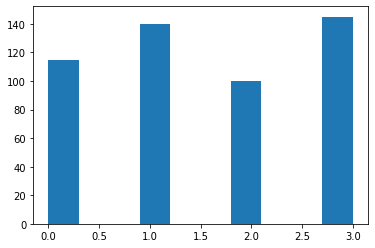

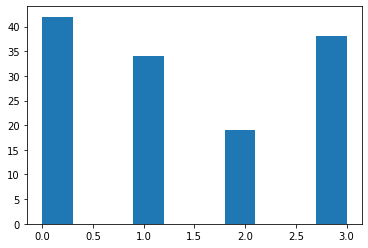

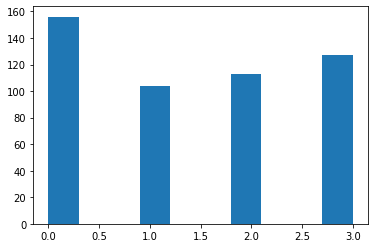

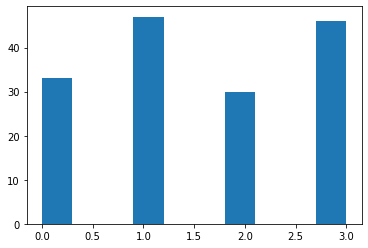

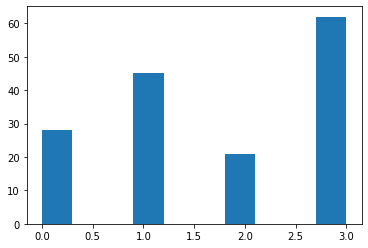

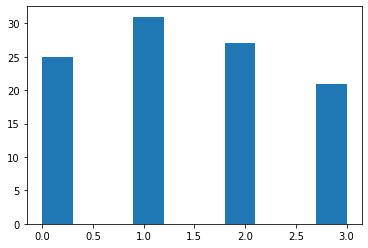

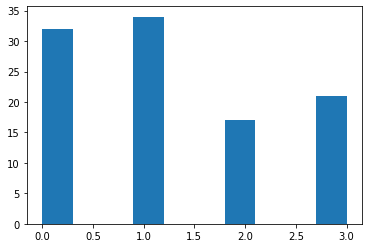

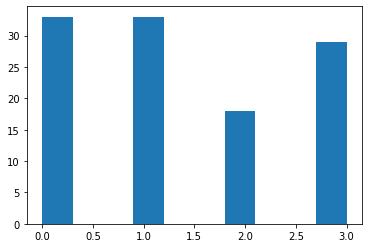

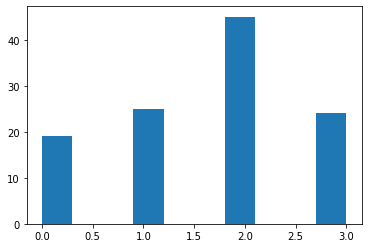

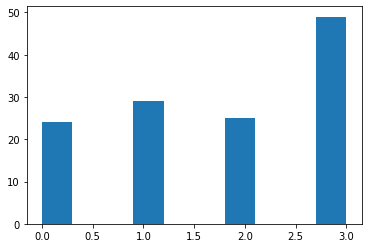

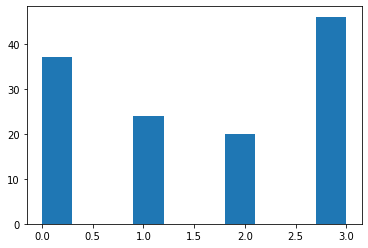

<Figure size 432x288 with 0 Axes>

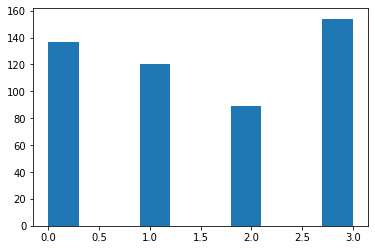

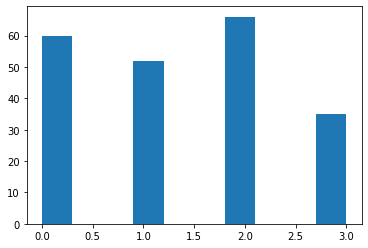

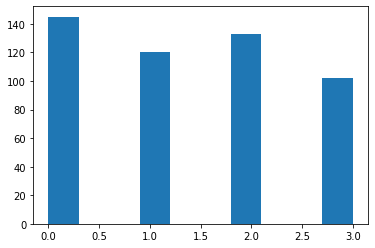

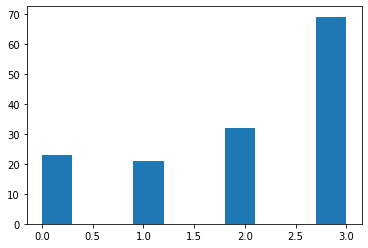

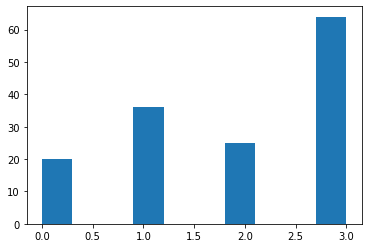

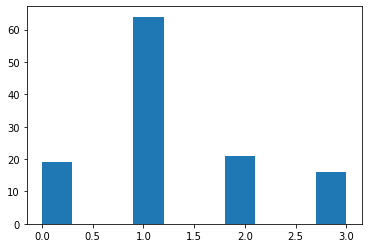

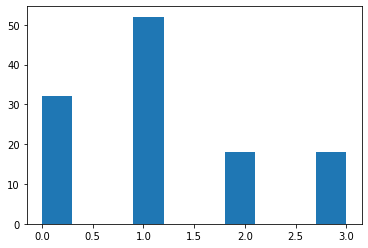

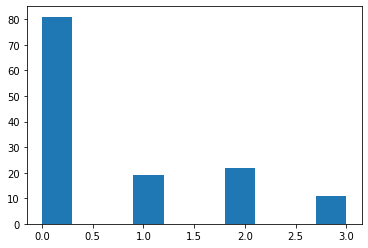

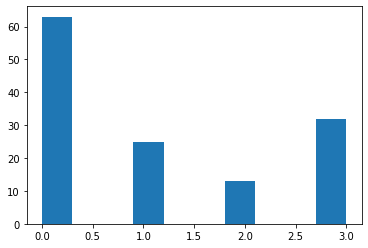

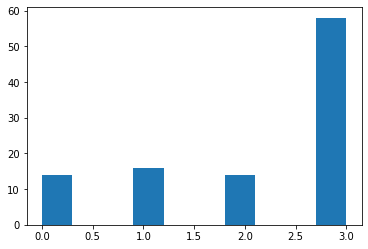

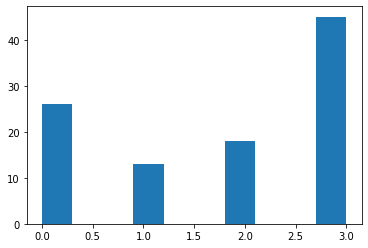

<Figure size 432x288 with 0 Axes>

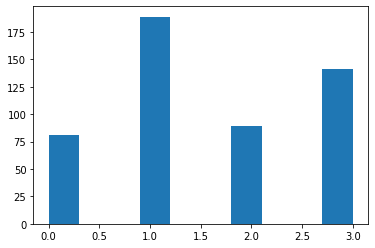

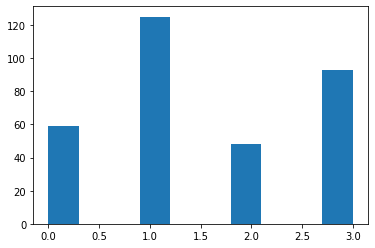

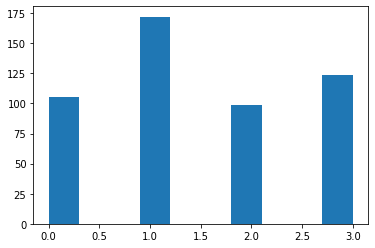

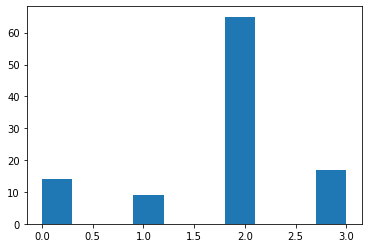

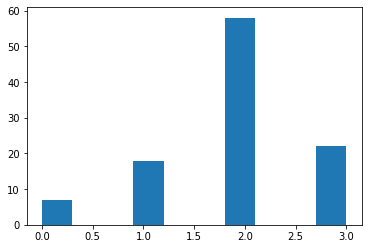

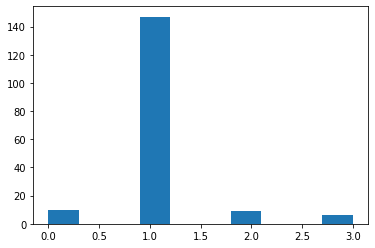

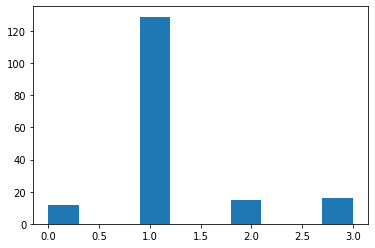

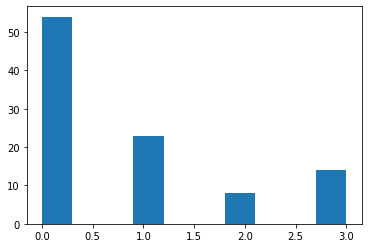

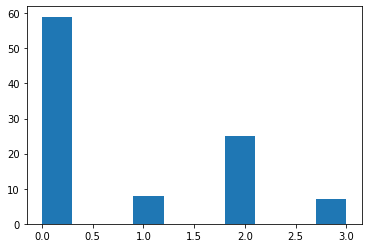

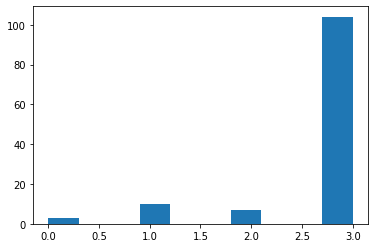

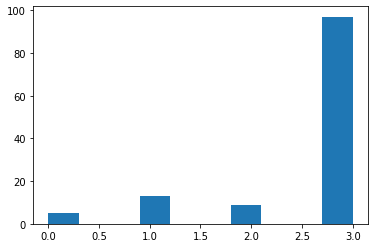

<Figure size 432x288 with 0 Axes>

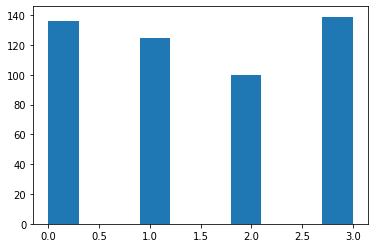

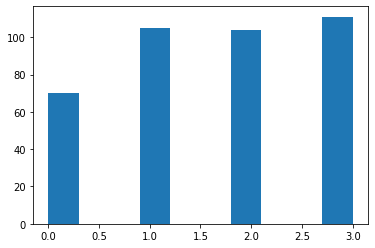

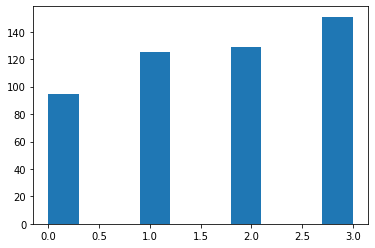

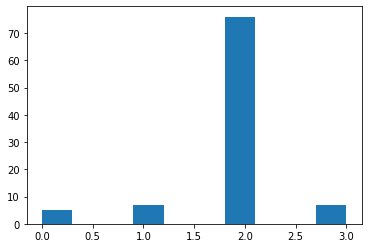

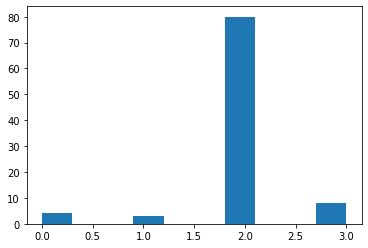

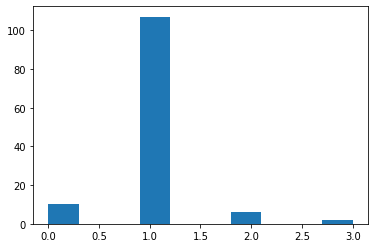

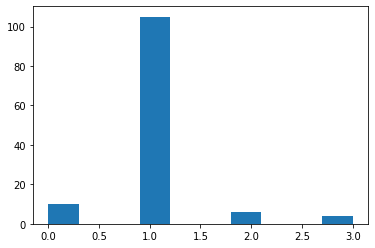

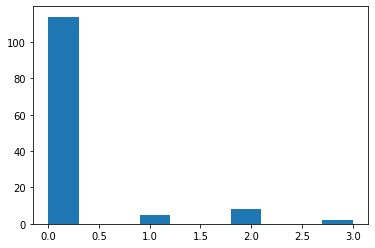

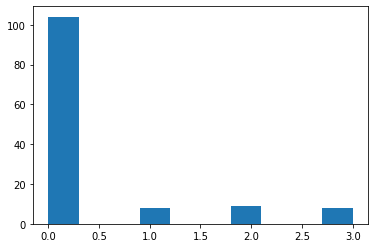

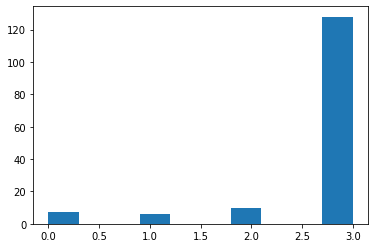

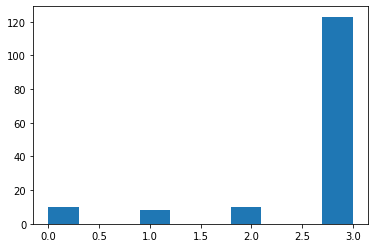

<Figure size 432x288 with 0 Axes>

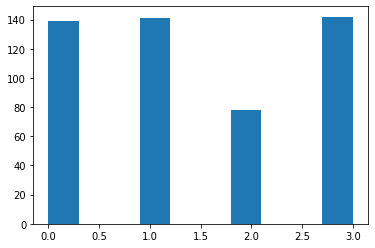

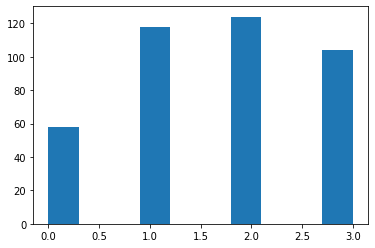

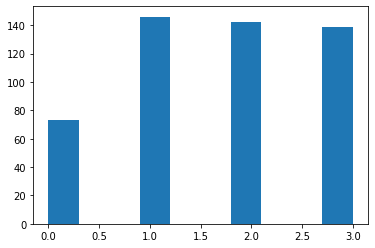

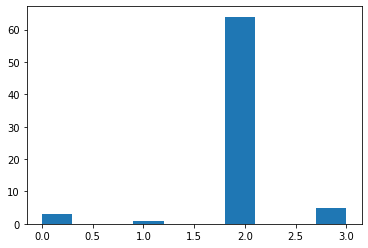

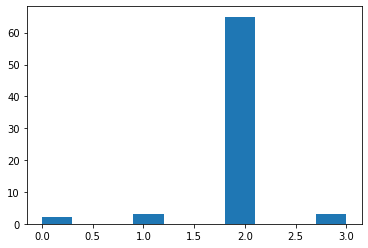

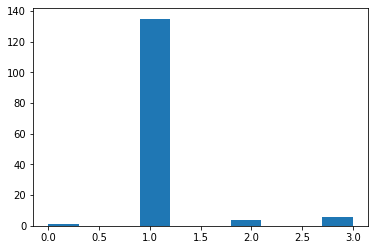

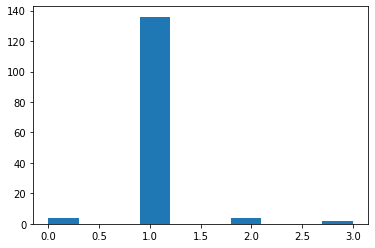

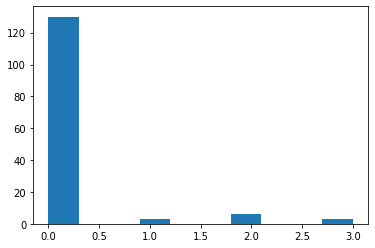

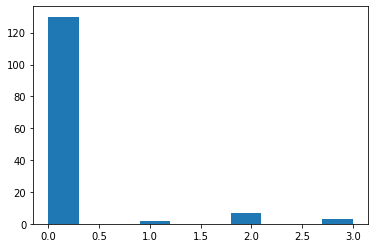

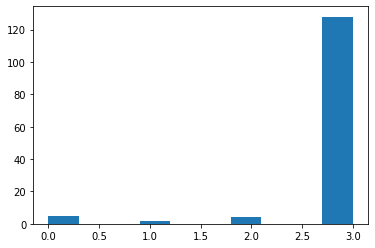

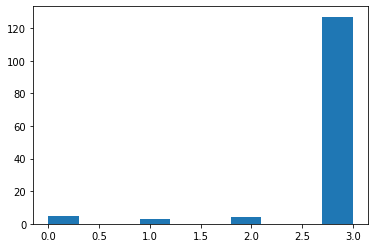

<Figure size 432x288 with 0 Axes>

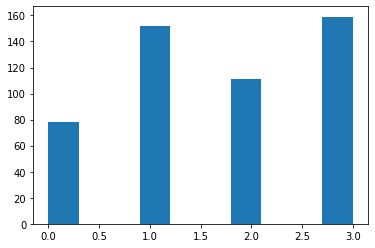

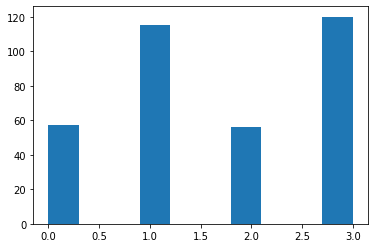

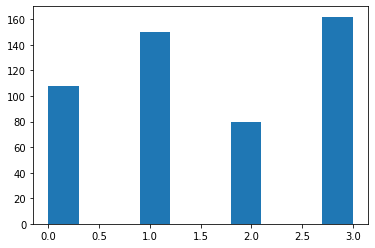

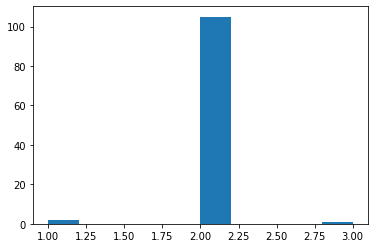

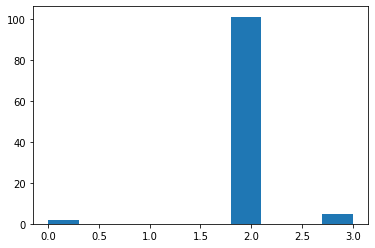

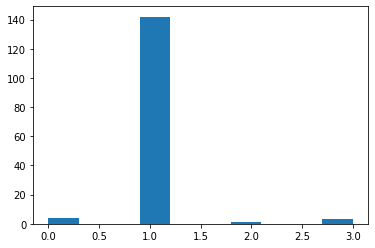

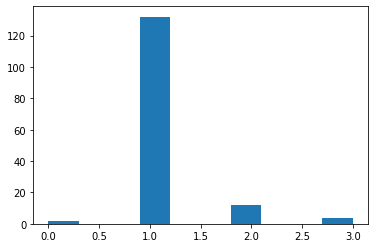

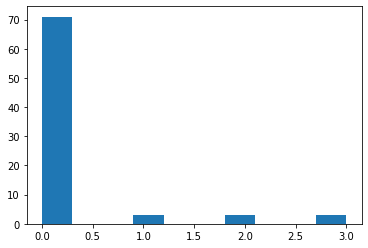

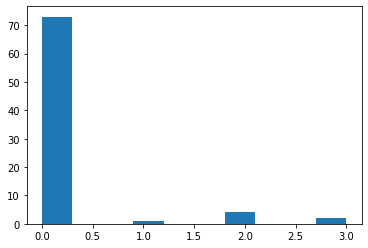

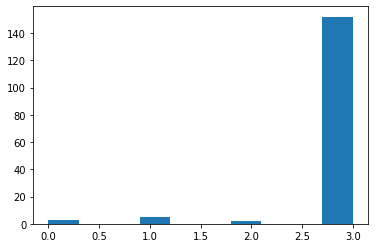

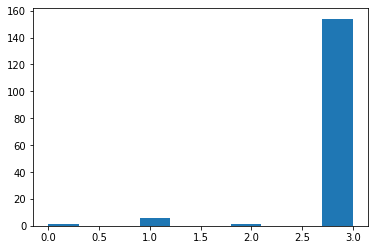

<Figure size 432x288 with 0 Axes>

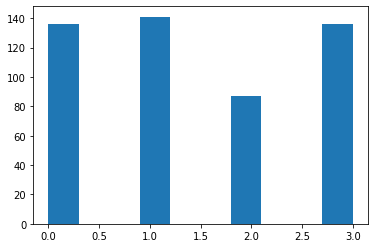

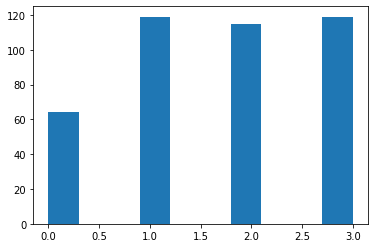

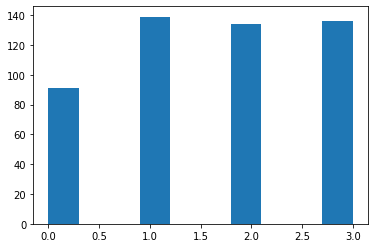

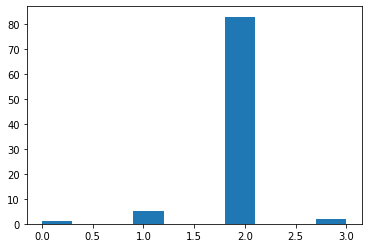

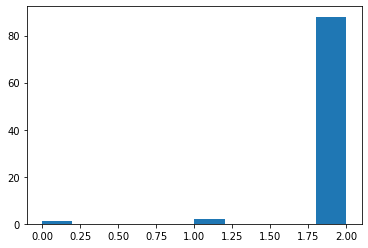

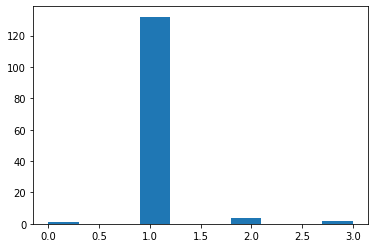

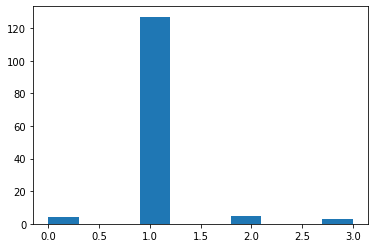

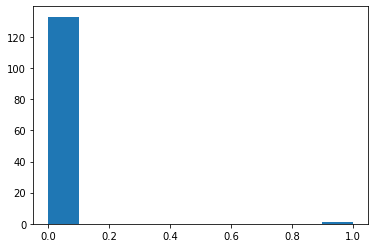

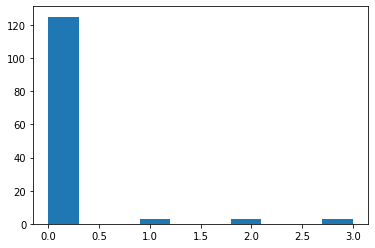

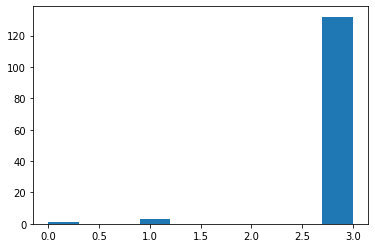

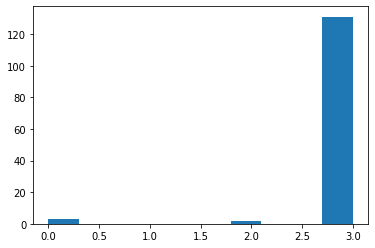

<Figure size 432x288 with 0 Axes>

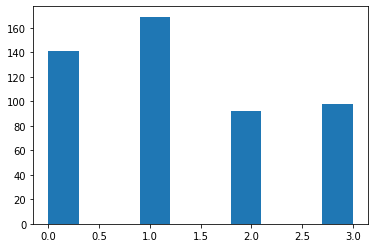

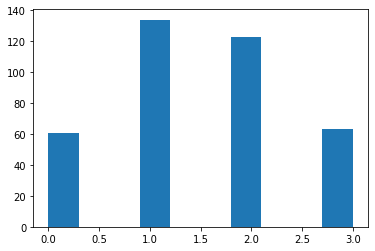

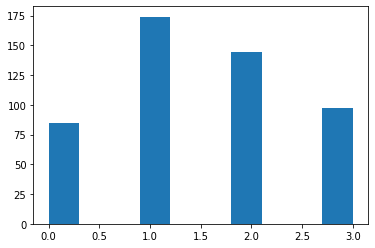

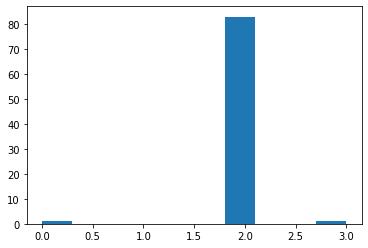

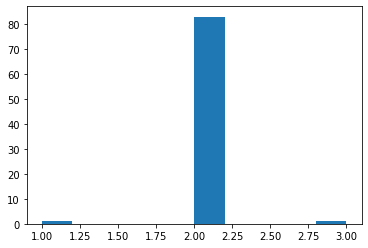

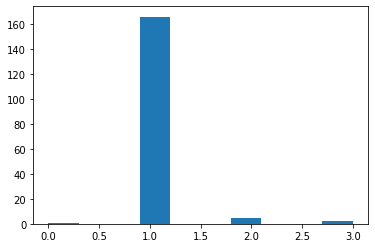

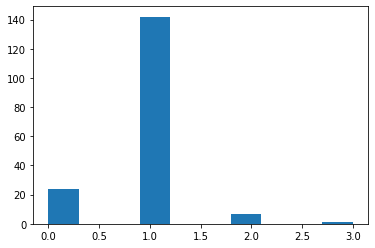

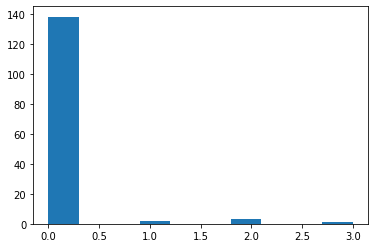

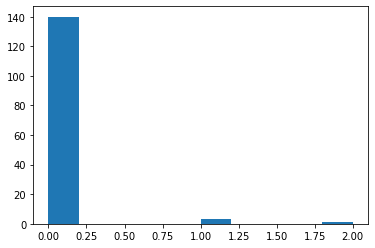

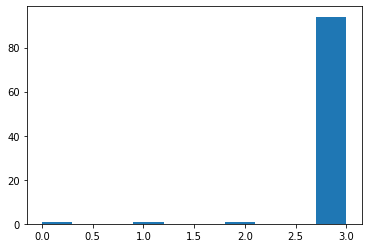

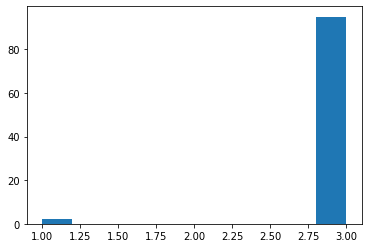

<Figure size 432x288 with 0 Axes>

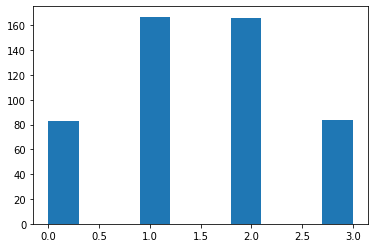

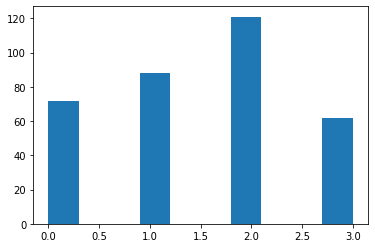

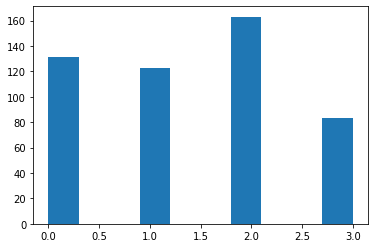

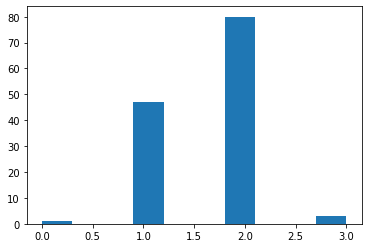

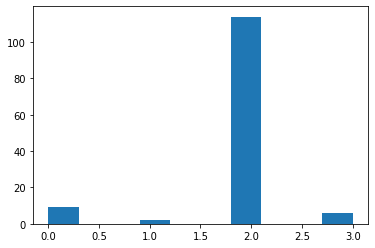

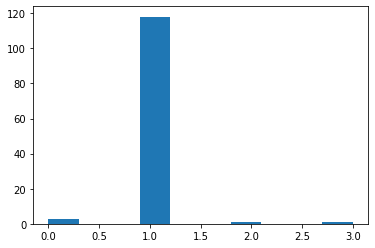

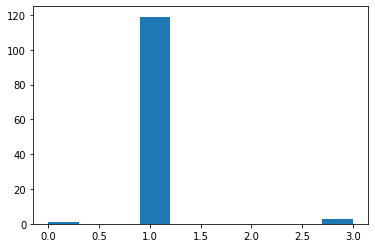

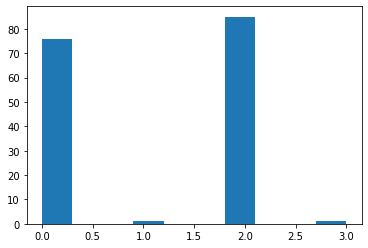

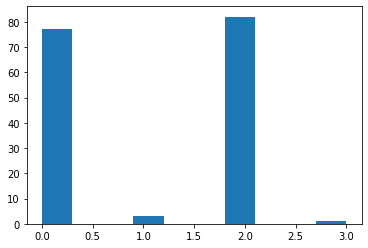

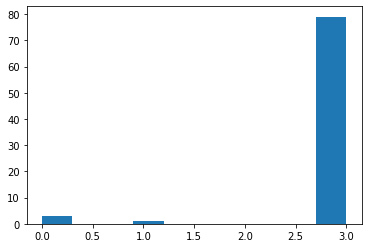

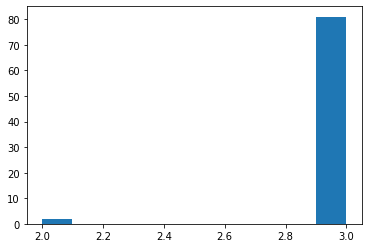

<Figure size 432x288 with 0 Axes>

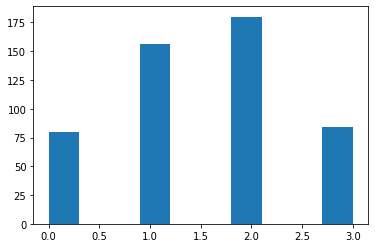

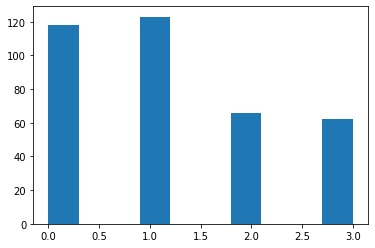

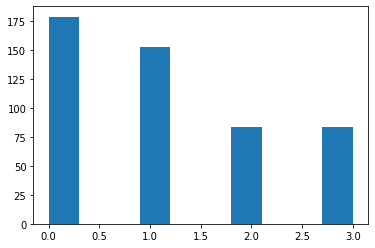

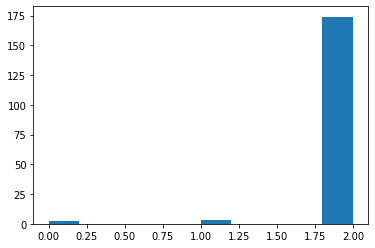

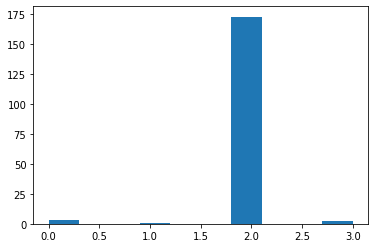

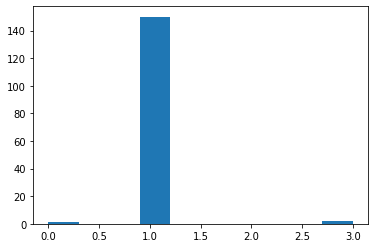

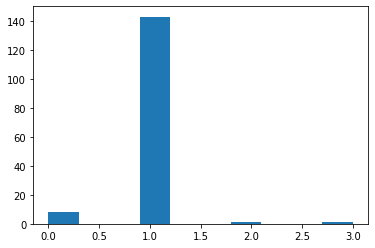

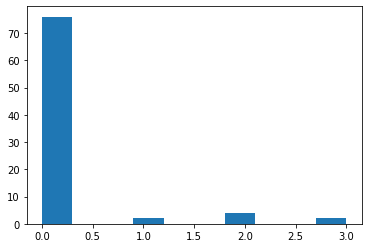

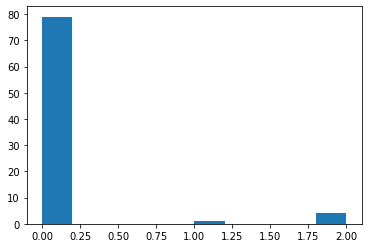

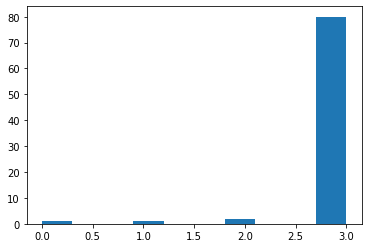

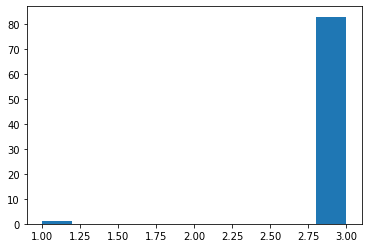

In [108]:
# Iterate the game
episodes = 5500
a1_talk = []
a1_act = []
a2 = []
scores1 = []
scores2 = []

wins = 1
loses = 1

for e in range(episodes):
    score1 = 0
    score2 = 0
    
    state1, state2, _, _ = env.step(0, 0, 0) # 4 - doing nothing 
    
    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, reward1, reward2 = env.step(action1[0], 4, 0)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    
    # everyone chooses
    next_state1, next_state2, reward1, reward2 = env.step(action1[1], action2, 1)     
        
    score1 += reward1
    score2 += reward2
    if e > 1000:
        if score1 > 0.5: #won the game
            agent1.epsilon_min = 0
        else:
            agent1.epsilon_min = 0.1
        if score2 > 0.5: #won the game
            agent2.epsilon_min = 0
        else:
            agent2.epsilon_min = 0.1
        
    # remembering weighted by the reward
    #if random.random() < (score1 + 2.2):
    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)

    if e > 0 and e % 500 == 0:
        scores1_arr = np.array(scores1[e-500:e])
        a1_talk_arr = np.array(a1_talk[e-500:e])
        a1_act_arr = np.array(a1_act[e-500:e])
        a2_arr = np.array(a2[e-500:e])
        plt.figure()
        plt.figure()
        plt.hist(a1_act_arr)
        plt.figure()
        plt.hist(a1_talk_arr[scores1_arr > 0])
        plt.figure()
        plt.hist(a1_talk_arr)
        plt.figure()
        plt.hist(a1_act_arr[:][a1_talk_arr[:] == 0])
        plt.figure()
        plt.hist(a2_arr[:][a1_talk_arr[:] == 0])
        plt.figure()
        plt.hist(a1_act_arr[:][a1_talk_arr[:] == 1])
        plt.figure()
        plt.hist(a2_arr[:][a1_talk_arr[:] == 1])
        plt.figure()
        plt.hist(a1_act_arr[:][a1_talk_arr[:] == 2])
        plt.figure()
        plt.hist(a2_arr[:][a1_talk_arr[:] == 2])
        plt.figure()
        plt.hist(a1_act_arr[:][a1_talk_arr[:] == 3])
        plt.figure()
        plt.hist(a2_arr[:][a1_talk_arr[:] == 3])
        
    
    print("episode: {}/{}, score1: {}, score2: {}"
                  .format(e, episodes, score1, score2))
    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        #if wins/loses < np.random.uniform(0,2):   
        agent1.replay(10)
        agent2.replay(10)
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2.append(action2)
    scores1.append(score1)
    scores2.append(score2)

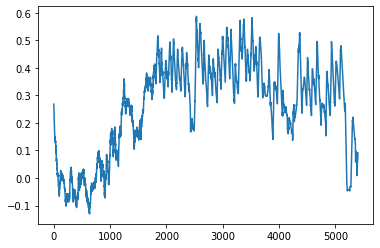

In [109]:
plt.plot(np.convolve(scores2, np.ones((100,))/100, mode='valid'))

### Agents can play both roles

In [8]:
class Two_Roles_Game():

    def __init__(
        self, num_choices, winning_reward, mean_sample, talking_action_size, punishment_weight = 2):
        self.num_choices = num_choices
        self.talking_action_size = talking_action_size
        self.winning_reward = winning_reward
        self.mean_sample = mean_sample
        self.actions1 = collections.deque(maxlen=mean_sample) # for mean calculations
        self.actions2 = collections.deque(maxlen=mean_sample) # for mean calculations
        self.mean_punishment_weight = punishment_weight
        self.who_talks = int(random.random()>0.5) # needs to be updated after each game
                
    def step(self, ag1_action, ag2_action, choose, reward1 = 0, reward2 = 0): #choose true or false
        #talker_input = np.zeros((self.talking_action_size+self.talking_action_size+1,)) # no noise
        #talker_input[1:self.talking_action_size+1] = np.random.random((self.talking_action_size,)) #UNIFORM/bimodal NOISE + signal for the game role
        talker_input = np.random.random((self.talking_action_size+1,)) #UNIFORM/bimodal NOISE + signal for the game role
        talker_input[0] = 1 # indicates that needs to talk
        #hearer_input = np.zeros((self.talking_action_size+self.talking_action_size+1,)) # no noise
        hearer_input = np.zeros((self.talking_action_size+1,))
        
        if choose: # step of choice
            self.actions1.append(ag1_action)
            self.actions2.append(ag2_action)
            a1_rew = 0
            a2_rew = 0
            
            if len(self.actions1) > self.mean_sample-1:
                a1_rew = ((1/self.num_choices) - self.actions1.count(ag1_action)/self.mean_sample) * self.mean_punishment_weight
                a2_rew = ((1/self.num_choices) - self.actions2.count(ag2_action)/self.mean_sample) * self.mean_punishment_weight
                
            if ag2_action == ag1_action: 
                reward1 = self.winning_reward + a1_rew
                reward2 = self.winning_reward + a2_rew
                
            else:
                reward1 = a1_rew #-1
                reward2 = a2_rew #-1
                    
        else: # agent is talking 
            if self.who_talks: #agent 1 - talker
                talker_action = ag1_action
            else:
                talker_action = ag2_action
            #hearer_input[self.talking_action_size + talker_action+1] = 1
            hearer_input[talker_action+1] = 1
            
        who_talks_now = self.who_talks
        if choose: 
            self.who_talks = int(random.random()>0.5) # 1 or 0 - for the new game
        
        if self.who_talks:
            return(talker_input, hearer_input, reward1, reward2, who_talks_now)
            #ag1_input = talker_input
            #ag2_input = hearer_input
        else:
            return(hearer_input, talker_input, reward1, reward2, who_talks_now)
            #ag2_input = talker_input
            #ag1_input = hearer_input
        
        #return(ag1_input, ag2_input, reward1, reward2, who_talks_now)

In [111]:
class DQNAgent_student_teacher:
    def __init__(self, talking_action_size, choices): 
        self.memory = collections.deque(maxlen=11)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.0001
        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model_student_teacher()
 
 
    def _build_model_student_teacher(self):
        # Neural Net for Deep-Q learning Model
        
        model = Sequential()
        #model.add(Dense(25, input_dim=self.talking_action_size + self.talking_action_size +self.talking_action_size+ 1, activation='relu')) # one input - the game role
        model.add(Dense(25, input_dim=self.talking_action_size + self.talking_action_size+ 1, activation='relu')) # one input - the game role
        model.add(Dense(25, activation='softmax'))
        model.add(Dense(10, activation='relu'))
 
        model.add(Dense(self.choices, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
       
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.randrange(self.talking_action_size), random.randrange(self.choices)]
 
        
        max_q = -float("infinity")
        max_talk = None
        max_action = None
 
        for i in range(self.talking_action_size):
            talking = np.zeros(self.talking_action_size)
            talking[i] = 1
 
            state_cur = np.expand_dims(np.hstack([state, talking]), axis=0)
            act_values = self.model.predict(state_cur, batch_size=1)
 
            cur_max = np.max(act_values)
           
            if cur_max > max_q:
 
              max_q = cur_max
              max_action = np.argmax(act_values[0])
              max_talk = i
 
            assert max_talk is not None
            assert max_action is not None
 
        return [max_talk, max_action]
                           
    def replay(self, batch_size):
        for i in self.memory:
            minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            #state = np.expand_dims(state, axis=0)
            target = reward
            one_hot_talk = np.zeros(self.talking_action_size)
            one_hot_talk[action[0]] = 1
            cur_state = np.expand_dims(np.hstack([state, one_hot_talk]), axis=0)
 
            target_f = self.model.predict(cur_state, batch_size=1)
            target_f[0][action[1]] = target # choose
            self.model.fit(cur_state, target_f, batch_size=1, epochs=1, verbose=0)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [112]:
num_choices = 4
num_talking_symbols = 4
winning_reward = 1
mean_sample = 100
punishment_weight = 3

agent1 = DQNAgent_student_teacher(num_talking_symbols, num_choices)
agent2 = DQNAgent_student_teacher(num_talking_symbols, num_choices) 
env = Two_Roles_Game(num_choices, winning_reward, mean_sample, num_talking_symbols, punishment_weight) 

episode: 0/5000, score1: 0, score2: 0
episode: 1/5000, score1: 0, score2: 0
episode: 2/5000, score1: 0, score2: 0
episode: 3/5000, score1: 1, score2: 1
episode: 4/5000, score1: 0, score2: 0
episode: 5/5000, score1: 1, score2: 1
episode: 6/5000, score1: 1, score2: 1
episode: 7/5000, score1: 0, score2: 0
episode: 8/5000, score1: 1, score2: 1
episode: 9/5000, score1: 0, score2: 0
episode: 10/5000, score1: 1, score2: 1
episode: 11/5000, score1: 0, score2: 0
episode: 12/5000, score1: 0, score2: 0
episode: 13/5000, score1: 0, score2: 0
episode: 14/5000, score1: 0, score2: 0
episode: 15/5000, score1: 0, score2: 0
episode: 16/5000, score1: 0, score2: 0
episode: 17/5000, score1: 0, score2: 0
episode: 18/5000, score1: 1, score2: 1
episode: 19/5000, score1: 0, score2: 0
episode: 20/5000, score1: 0, score2: 0
episode: 21/5000, score1: 0, score2: 0
episode: 22/5000, score1: 1, score2: 1
episode: 23/5000, score1: 0, score2: 0
episode: 24/5000, score1: 1, score2: 1
episode: 25/5000, score1: 0, score2

episode: 168/5000, score1: -0.06000000000000005, score2: -0.11999999999999994
episode: 169/5000, score1: 0.8800000000000001, score2: 0.8500000000000001
episode: 170/5000, score1: 0.12000000000000002, score2: 0.18
episode: 171/5000, score1: 0.030000000000000027, score2: -0.14999999999999997
episode: 172/5000, score1: 0.0, score2: -0.18
episode: 173/5000, score1: -0.09000000000000008, score2: -0.18
episode: 174/5000, score1: -0.09000000000000008, score2: -0.14999999999999997
episode: 175/5000, score1: 0.09, score2: -0.18
episode: 176/5000, score1: -0.030000000000000027, score2: 0.23999999999999996
episode: 177/5000, score1: -0.030000000000000027, score2: -0.18
episode: 178/5000, score1: 0.9099999999999999, score2: 1.09
episode: 179/5000, score1: 0.09, score2: -0.21000000000000002
episode: 180/5000, score1: -0.09000000000000008, score2: -0.14999999999999997
episode: 181/5000, score1: -0.06000000000000005, score2: 0.12000000000000002
episode: 182/5000, score1: 0.8800000000000001, score2: 1

episode: 296/5000, score1: -0.51, score2: 0.32999999999999996
episode: 297/5000, score1: 0.23999999999999996, score2: 0.05999999999999997
episode: 298/5000, score1: 0.21000000000000002, score2: 0.30000000000000004
episode: 299/5000, score1: 1.18, score2: 1.03
episode: 300/5000, score1: 1.15, score2: 1.0
episode: 301/5000, score1: 0.23999999999999996, score2: -0.030000000000000027
episode: 302/5000, score1: 0.12000000000000002, score2: 0.14999999999999997
episode: 303/5000, score1: -0.45000000000000007, score2: -0.06000000000000005
episode: 304/5000, score1: 1.09, score2: 0.9099999999999999
episode: 305/5000, score1: -0.4799999999999999, score2: -0.11999999999999994
episode: 306/5000, score1: 0.05999999999999997, score2: 0.27
episode: 307/5000, score1: 0.05999999999999997, score2: 0.14999999999999997
episode: 308/5000, score1: 1.03, score2: 0.8800000000000001
episode: 309/5000, score1: -0.51, score2: -0.11999999999999994
episode: 310/5000, score1: -0.51, score2: -0.14999999999999997
epi

episode: 424/5000, score1: 0.67, score2: 0.73
episode: 425/5000, score1: 0.27, score2: -0.29999999999999993
episode: 426/5000, score1: 0.12000000000000002, score2: -0.32999999999999996
episode: 427/5000, score1: 0.09, score2: 0.12000000000000002
episode: 428/5000, score1: 1.27, score2: 1.09
episode: 429/5000, score1: -0.09000000000000008, score2: -0.32999999999999996
episode: 430/5000, score1: 0.67, score2: 0.64
episode: 431/5000, score1: -0.09000000000000008, score2: -0.030000000000000027
episode: 432/5000, score1: -0.11999999999999994, score2: -0.06000000000000005
episode: 433/5000, score1: 0.67, score2: 0.7000000000000001
episode: 434/5000, score1: 0.09, score2: -0.32999999999999996
episode: 435/5000, score1: 0.30000000000000004, score2: -0.36
episode: 436/5000, score1: 0.7000000000000001, score2: 0.61
episode: 437/5000, score1: -0.29999999999999993, score2: 0.09
episode: 438/5000, score1: 0.67, score2: 0.61
episode: 439/5000, score1: 1.12, score2: 1.0
episode: 440/5000, score1: -0.

episode: 555/5000, score1: -0.39, score2: 0.18
episode: 556/5000, score1: -0.39, score2: 0.23999999999999996
episode: 557/5000, score1: -0.42000000000000004, score2: 0.21000000000000002
episode: 558/5000, score1: 0.58, score2: 0.58
episode: 559/5000, score1: 1.18, score2: 1.21
episode: 560/5000, score1: -0.42000000000000004, score2: -0.030000000000000027
episode: 561/5000, score1: 0.5499999999999999, score2: 0.5499999999999999
episode: 562/5000, score1: -0.4799999999999999, score2: 0.18
episode: 563/5000, score1: 0.0, score2: 0.14999999999999997
episode: 564/5000, score1: 0.21000000000000002, score2: 0.030000000000000027
episode: 565/5000, score1: 0.0, score2: 0.27
episode: 566/5000, score1: 0.21000000000000002, score2: -0.4799999999999999
episode: 567/5000, score1: 0.18, score2: 0.05999999999999997
episode: 568/5000, score1: 0.23999999999999996, score2: -0.51
episode: 569/5000, score1: 0.030000000000000027, score2: -0.51
episode: 570/5000, score1: 1.0, score2: 1.06
episode: 571/5000, 

episode: 687/5000, score1: 0.97, score2: 0.94
episode: 688/5000, score1: -0.030000000000000027, score2: -0.4799999999999999
episode: 689/5000, score1: -0.06000000000000005, score2: -0.51
episode: 690/5000, score1: 0.9099999999999999, score2: 0.9099999999999999
episode: 691/5000, score1: 0.9099999999999999, score2: 0.8800000000000001
episode: 692/5000, score1: 1.3, score2: 1.24
episode: 693/5000, score1: 0.8800000000000001, score2: 0.8500000000000001
episode: 694/5000, score1: -0.6000000000000001, score2: 0.27
episode: 695/5000, score1: -0.14999999999999997, score2: 0.23999999999999996
episode: 696/5000, score1: -0.18, score2: -0.45000000000000007
episode: 697/5000, score1: 0.39, score2: 0.30000000000000004
episode: 698/5000, score1: 0.27, score2: -0.18
episode: 699/5000, score1: 0.36, score2: -0.21000000000000002
episode: 700/5000, score1: -0.21000000000000002, score2: -0.42000000000000004
episode: 701/5000, score1: -0.24000000000000005, score2: 0.30000000000000004
episode: 702/5000, s

episode: 821/5000, score1: 0.15999999999999992, score2: 0.18999999999999995
episode: 822/5000, score1: 0.1299999999999999, score2: 0.15999999999999992
episode: 823/5000, score1: -0.9000000000000001, score2: 0.48
episode: 824/5000, score1: -0.09000000000000008, score2: -0.8700000000000001
episode: 825/5000, score1: -0.9300000000000002, score2: 0.44999999999999996
episode: 826/5000, score1: -0.9300000000000002, score2: -0.09000000000000008
episode: 827/5000, score1: 0.04000000000000015, score2: 0.1299999999999999
episode: 828/5000, score1: -0.06000000000000005, score2: -0.9000000000000001
episode: 829/5000, score1: -0.06000000000000005, score2: 0.42000000000000004
episode: 830/5000, score1: -0.9899999999999999, score2: 0.48
episode: 831/5000, score1: -1.02, score2: 0.39
episode: 832/5000, score1: 0.44999999999999996, score2: 0.36
episode: 833/5000, score1: -1.02, score2: 0.44999999999999996
episode: 834/5000, score1: -0.04999999999999982, score2: 0.09999999999999987
episode: 835/5000, sc

episode: 955/5000, score1: 0.7000000000000001, score2: 0.97
episode: 956/5000, score1: 0.44999999999999996, score2: -0.06000000000000005
episode: 957/5000, score1: -0.5700000000000001, score2: -0.09000000000000008
episode: 958/5000, score1: 0.67, score2: 0.8800000000000001
episode: 959/5000, score1: -0.36, score2: 0.54
episode: 960/5000, score1: -0.54, score2: -0.14999999999999997
episode: 961/5000, score1: 0.44999999999999996, score2: -0.18
episode: 962/5000, score1: 0.64, score2: 0.79
episode: 963/5000, score1: 0.42000000000000004, score2: -0.8700000000000001
episode: 964/5000, score1: 0.61, score2: 0.76
episode: 965/5000, score1: 0.58, score2: 0.73
episode: 966/5000, score1: 0.39, score2: -0.29999999999999993
episode: 967/5000, score1: 0.39, score2: -0.81
episode: 968/5000, score1: -0.42000000000000004, score2: 0.5700000000000001
episode: 969/5000, score1: -0.45000000000000007, score2: -0.78
episode: 970/5000, score1: -0.4799999999999999, score2: 0.48
episode: 971/5000, score1: 0.36

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


episode: 1000/5000, score1: -0.08000000000000007, score2: 0.15999999999999992
episode: 1001/5000, score1: 0.18, score2: -0.8700000000000001
episode: 1002/5000, score1: -0.08000000000000007, score2: 0.09999999999999987
episode: 1003/5000, score1: -0.10999999999999988, score2: 0.06999999999999984
episode: 1004/5000, score1: 0.44999999999999996, score2: -0.9599999999999999
episode: 1005/5000, score1: 1.42, score2: 1.57
episode: 1006/5000, score1: -1.1400000000000001, score2: 0.44999999999999996
episode: 1007/5000, score1: -1.17, score2: 0.42000000000000004
episode: 1008/5000, score1: -0.20000000000000018, score2: 0.01000000000000012
episode: 1009/5000, score1: 1.3599999999999999, score2: 0.97
episode: 1010/5000, score1: 0.39, score2: -1.02
episode: 1011/5000, score1: 0.36, score2: -1.0499999999999998
episode: 1012/5000, score1: -1.23, score2: 0.030000000000000027
episode: 1013/5000, score1: 0.42000000000000004, score2: 0.42000000000000004
episode: 1014/5000, score1: 1.3599999999999999, sc

episode: 1127/5000, score1: -1.17, score2: 0.36
episode: 1128/5000, score1: -1.2000000000000002, score2: 0.32999999999999996
episode: 1129/5000, score1: 0.36, score2: 0.36
episode: 1130/5000, score1: -1.23, score2: 0.36
episode: 1131/5000, score1: -1.2600000000000002, score2: 0.32999999999999996
episode: 1132/5000, score1: -1.29, score2: 0.30000000000000004
episode: 1133/5000, score1: 1.6, score2: 1.27
episode: 1134/5000, score1: 0.5700000000000001, score2: -1.1099999999999999
episode: 1135/5000, score1: -1.29, score2: 0.27
episode: 1136/5000, score1: 0.54, score2: -1.1099999999999999
episode: 1137/5000, score1: 1.51, score2: 1.27
episode: 1138/5000, score1: 0.32999999999999996, score2: 0.27
episode: 1139/5000, score1: 1.48, score2: 1.24
episode: 1140/5000, score1: 0.44999999999999996, score2: 0.36
episode: 1141/5000, score1: -1.3199999999999998, score2: 0.42000000000000004
episode: 1142/5000, score1: 1.42, score2: 1.21
episode: 1143/5000, score1: -0.34999999999999987, score2: -0.02000

episode: 1257/5000, score1: 0.9099999999999999, score2: 1.42
episode: 1258/5000, score1: -0.9000000000000001, score2: 0.39
episode: 1259/5000, score1: 0.8800000000000001, score2: 1.3599999999999999
episode: 1260/5000, score1: 0.48, score2: 0.32999999999999996
episode: 1261/5000, score1: 0.8500000000000001, score2: 1.3
episode: 1262/5000, score1: 0.48, score2: 0.27
episode: 1263/5000, score1: 0.8200000000000001, score2: 1.24
episode: 1264/5000, score1: 0.79, score2: 1.24
episode: 1265/5000, score1: 0.76, score2: 1.21
episode: 1266/5000, score1: 0.73, score2: 1.18
episode: 1267/5000, score1: 0.7000000000000001, score2: 1.15
episode: 1268/5000, score1: 0.67, score2: 1.12
episode: 1269/5000, score1: 0.44999999999999996, score2: 0.09
episode: 1270/5000, score1: 0.64, score2: 1.09
episode: 1271/5000, score1: 0.61, score2: 1.06
episode: 1272/5000, score1: 0.6000000000000001, score2: 0.030000000000000027
episode: 1273/5000, score1: 0.58, score2: 1.0
episode: 1274/5000, score1: 0.54999999999999

episode: 1392/5000, score1: 0.58, score2: 0.18999999999999995
episode: 1393/5000, score1: 0.5499999999999999, score2: 0.15999999999999992
episode: 1394/5000, score1: 0.52, score2: 0.1299999999999999
episode: 1395/5000, score1: 0.49, score2: 0.09999999999999987
episode: 1396/5000, score1: 0.54, score2: -0.24000000000000005
episode: 1397/5000, score1: 0.45999999999999996, score2: 0.06999999999999984
episode: 1398/5000, score1: 0.42999999999999994, score2: 0.04000000000000015
episode: 1399/5000, score1: 0.3999999999999999, score2: 0.01000000000000012
episode: 1400/5000, score1: -0.6300000000000001, score2: 0.5700000000000001
episode: 1401/5000, score1: 0.51, score2: -1.02
episode: 1402/5000, score1: 0.3400000000000001, score2: -0.04999999999999982
episode: 1403/5000, score1: -0.69, score2: -0.11999999999999994
episode: 1404/5000, score1: 0.31000000000000005, score2: -0.04999999999999982
episode: 1405/5000, score1: 0.28, score2: -0.08000000000000007
episode: 1406/5000, score1: 0.25, score2

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

episode: 1500/5000, score1: 0.5499999999999999, score2: -0.31999999999999984
episode: 1501/5000, score1: -0.4799999999999999, score2: 0.54
episode: 1502/5000, score1: -0.51, score2: 0.5700000000000001
episode: 1503/5000, score1: -0.030000000000000027, score2: 0.18
episode: 1504/5000, score1: -0.54, score2: 0.18
episode: 1505/5000, score1: -0.5700000000000001, score2: 0.5700000000000001
episode: 1506/5000, score1: -0.6000000000000001, score2: 0.21000000000000002
episode: 1507/5000, score1: -0.6300000000000001, score2: 0.54
episode: 1508/5000, score1: -0.6599999999999999, score2: 0.21000000000000002
episode: 1509/5000, score1: 1.12, score2: 1.18
episode: 1510/5000, score1: -0.69, score2: 0.18
episode: 1511/5000, score1: -0.72, score2: 0.18
episode: 1512/5000, score1: -0.75, score2: 0.18
episode: 1513/5000, score1: -0.78, score2: 0.18
episode: 1514/5000, score1: -0.81, score2: 0.18
episode: 1515/5000, score1: -0.8400000000000001, score2: 0.54
episode: 1516/5000, score1: -0.870000000000000

episode: 1630/5000, score1: 0.54, score2: -1.44
episode: 1631/5000, score1: 0.51, score2: -1.47
episode: 1632/5000, score1: 0.48, score2: 0.54
episode: 1633/5000, score1: 0.44999999999999996, score2: -1.5
episode: 1634/5000, score1: 0.42000000000000004, score2: 0.51
episode: 1635/5000, score1: 0.54, score2: 0.36
episode: 1636/5000, score1: 1.3900000000000001, score2: 1.33
episode: 1637/5000, score1: 0.36, score2: 0.51
episode: 1638/5000, score1: 1.33, score2: 1.3599999999999999
episode: 1639/5000, score1: 1.3, score2: 1.3599999999999999
episode: 1640/5000, score1: -1.47, score2: 0.36
episode: 1641/5000, score1: 1.27, score2: 1.3599999999999999
episode: 1642/5000, score1: 1.24, score2: 1.33
episode: 1643/5000, score1: 1.21, score2: 1.3
episode: 1644/5000, score1: 0.5700000000000001, score2: 0.27
episode: 1645/5000, score1: 0.18, score2: 0.48
episode: 1646/5000, score1: 0.54, score2: 0.23999999999999996
episode: 1647/5000, score1: 1.15, score2: 1.24
episode: 1648/5000, score1: 1.12, scor

episode: 1770/5000, score1: 0.06999999999999984, score2: 0.25
episode: 1771/5000, score1: 0.06999999999999984, score2: 0.21999999999999997
episode: 1772/5000, score1: 0.6000000000000001, score2: -0.81
episode: 1773/5000, score1: 0.04000000000000015, score2: 0.15999999999999992
episode: 1774/5000, score1: -0.32999999999999996, score2: -0.8700000000000001
episode: 1775/5000, score1: 0.01000000000000012, score2: 0.09999999999999987
episode: 1776/5000, score1: 0.5700000000000001, score2: -0.9300000000000002
episode: 1777/5000, score1: -0.020000000000000018, score2: 0.04000000000000015
episode: 1778/5000, score1: -0.04999999999999982, score2: 0.01000000000000012
episode: 1779/5000, score1: -0.08000000000000007, score2: -0.020000000000000018
episode: 1780/5000, score1: -0.10999999999999988, score2: -0.020000000000000018
episode: 1781/5000, score1: -0.14000000000000012, score2: -0.04999999999999982
episode: 1782/5000, score1: -0.16999999999999993, score2: -0.08000000000000007
episode: 1783/50

episode: 1900/5000, score1: -0.78, score2: 0.14999999999999997
episode: 1901/5000, score1: 1.6, score2: 1.12
episode: 1902/5000, score1: -0.81, score2: 0.09
episode: 1903/5000, score1: -0.81, score2: 0.6000000000000001
episode: 1904/5000, score1: -0.8400000000000001, score2: 0.5700000000000001
episode: 1905/5000, score1: -0.8700000000000001, score2: 0.05999999999999997
episode: 1906/5000, score1: -0.8700000000000001, score2: 0.030000000000000027
episode: 1907/5000, score1: -0.8700000000000001, score2: 0.030000000000000027
episode: 1908/5000, score1: -0.9000000000000001, score2: 0.0
episode: 1909/5000, score1: -0.9300000000000002, score2: 0.0
episode: 1910/5000, score1: -0.9599999999999999, score2: -0.030000000000000027
episode: 1911/5000, score1: -0.9899999999999999, score2: -0.06000000000000005
episode: 1912/5000, score1: -0.9899999999999999, score2: -0.09000000000000008
episode: 1913/5000, score1: -1.02, score2: 0.5700000000000001
episode: 1914/5000, score1: 1.57, score2: 0.880000000

episode: 2030/5000, score1: 0.45999999999999996, score2: -0.020000000000000018
episode: 2031/5000, score1: -0.5700000000000001, score2: -0.29999999999999993
episode: 2032/5000, score1: 0.3999999999999999, score2: -0.020000000000000018
episode: 2033/5000, score1: 0.3699999999999999, score2: -0.04999999999999982
episode: 2034/5000, score1: 0.3400000000000001, score2: -0.08000000000000007
episode: 2035/5000, score1: 0.31000000000000005, score2: -0.10999999999999988
episode: 2036/5000, score1: 0.28, score2: -0.14000000000000012
episode: 2037/5000, score1: 0.72, score2: -1.17
episode: 2038/5000, score1: 0.25, score2: -0.20000000000000018
episode: 2039/5000, score1: 0.21999999999999997, score2: -0.22999999999999998
episode: 2040/5000, score1: 0.18999999999999995, score2: -0.26000000000000023
episode: 2041/5000, score1: 0.15999999999999992, score2: -0.26000000000000023
episode: 2042/5000, score1: 0.1299999999999999, score2: -0.29000000000000004
episode: 2043/5000, score1: 0.09999999999999987,

episode: 2155/5000, score1: 0.5700000000000001, score2: 0.63
episode: 2156/5000, score1: 0.30000000000000004, score2: -1.2000000000000002
episode: 2157/5000, score1: -0.56, score2: -0.22999999999999998
episode: 2158/5000, score1: 0.54, score2: -1.2600000000000002
episode: 2159/5000, score1: 0.51, score2: -1.29
episode: 2160/5000, score1: -0.5900000000000001, score2: -0.31999999999999984
episode: 2161/5000, score1: -0.6200000000000001, score2: -0.34999999999999987
episode: 2162/5000, score1: 0.48, score2: -1.38
episode: 2163/5000, score1: 0.44999999999999996, score2: -1.41
episode: 2164/5000, score1: 0.42000000000000004, score2: -1.44
episode: 2165/5000, score1: 1.3900000000000001, score2: 1.09
episode: 2166/5000, score1: 0.36, score2: -1.47
episode: 2167/5000, score1: 0.32999999999999996, score2: -1.5
episode: 2168/5000, score1: 0.30000000000000004, score2: -1.53
episode: 2169/5000, score1: 0.27, score2: -1.56
episode: 2170/5000, score1: 0.23999999999999996, score2: 0.63
episode: 2171/

episode: 2285/5000, score1: -0.5, score2: -0.31999999999999984
episode: 2286/5000, score1: -0.53, score2: -0.34999999999999987
episode: 2287/5000, score1: -0.56, score2: -0.3799999999999999
episode: 2288/5000, score1: -0.5900000000000001, score2: -0.4099999999999999
episode: 2289/5000, score1: -0.6200000000000001, score2: -0.43999999999999995
episode: 2290/5000, score1: -0.6500000000000001, score2: -0.47
episode: 2291/5000, score1: -0.6800000000000002, score2: -0.5
episode: 2292/5000, score1: -0.71, score2: -0.53
episode: 2293/5000, score1: -0.7399999999999998, score2: -0.56
episode: 2294/5000, score1: -0.77, score2: -0.5900000000000001
episode: 2295/5000, score1: -0.7999999999999998, score2: -0.6200000000000001
episode: 2296/5000, score1: -0.8300000000000001, score2: -0.6500000000000001
episode: 2297/5000, score1: -0.8599999999999999, score2: -0.6800000000000002
episode: 2298/5000, score1: -0.8900000000000001, score2: -0.71
episode: 2299/5000, score1: -0.9199999999999999, score2: -0.7

episode: 2410/5000, score1: -0.10999999999999988, score2: -0.14000000000000012
episode: 2411/5000, score1: -0.10999999999999988, score2: -0.16999999999999993
episode: 2412/5000, score1: -0.10999999999999988, score2: -0.20000000000000018
episode: 2413/5000, score1: -0.10999999999999988, score2: -0.22999999999999998
episode: 2414/5000, score1: -0.10999999999999988, score2: -0.26000000000000023
episode: 2415/5000, score1: -0.10999999999999988, score2: -0.29000000000000004
episode: 2416/5000, score1: -1.1099999999999999, score2: 0.6900000000000001
episode: 2417/5000, score1: -0.10999999999999988, score2: -0.31999999999999984
episode: 2418/5000, score1: -0.32999999999999996, score2: -1.3499999999999999
episode: 2419/5000, score1: -0.08000000000000007, score2: -0.3799999999999999
episode: 2420/5000, score1: -0.08000000000000007, score2: -0.4099999999999999
episode: 2421/5000, score1: -0.08000000000000007, score2: -0.43999999999999995
episode: 2422/5000, score1: -0.10999999999999988, score2: 

episode: 2540/5000, score1: 1.0, score2: 1.18
episode: 2541/5000, score1: 0.97, score2: 1.15
episode: 2542/5000, score1: 0.94, score2: 1.12
episode: 2543/5000, score1: 0.94, score2: 1.09
episode: 2544/5000, score1: 0.9099999999999999, score2: 1.06
episode: 2545/5000, score1: 0.8800000000000001, score2: 1.03
episode: 2546/5000, score1: 0.8800000000000001, score2: 1.0
episode: 2547/5000, score1: 0.8500000000000001, score2: 0.97
episode: 2548/5000, score1: 0.8200000000000001, score2: 0.94
episode: 2549/5000, score1: 0.79, score2: 0.9099999999999999
episode: 2550/5000, score1: 0.76, score2: 0.8800000000000001
episode: 2551/5000, score1: 0.73, score2: 0.8500000000000001
episode: 2552/5000, score1: 0.7000000000000001, score2: 0.8200000000000001
episode: 2553/5000, score1: 0.67, score2: 0.8200000000000001
episode: 2554/5000, score1: 0.64, score2: 0.79
episode: 2555/5000, score1: 0.61, score2: 0.76
episode: 2556/5000, score1: 0.58, score2: 0.73
episode: 2557/5000, score1: 0.58, score2: 0.70000

episode: 2665/5000, score1: 1.33, score2: 1.51
episode: 2666/5000, score1: 1.3, score2: 1.48
episode: 2667/5000, score1: 1.27, score2: 1.45
episode: 2668/5000, score1: 1.27, score2: 1.42
episode: 2669/5000, score1: 1.24, score2: 1.3900000000000001
episode: 2670/5000, score1: 1.21, score2: 1.3599999999999999
episode: 2671/5000, score1: 1.18, score2: 1.33
episode: 2672/5000, score1: 1.15, score2: 1.3
episode: 2673/5000, score1: 1.12, score2: 1.27
episode: 2674/5000, score1: 1.09, score2: 1.24
episode: 2675/5000, score1: 1.06, score2: 1.21
episode: 2676/5000, score1: 1.03, score2: 1.18
episode: 2677/5000, score1: 1.0, score2: 1.15
episode: 2678/5000, score1: 0.97, score2: 1.12
episode: 2679/5000, score1: 0.94, score2: 1.09
episode: 2680/5000, score1: 0.9099999999999999, score2: 1.06
episode: 2681/5000, score1: -0.6300000000000001, score2: 0.030000000000000027
episode: 2682/5000, score1: 0.8800000000000001, score2: 1.0
episode: 2683/5000, score1: 0.8500000000000001, score2: 0.97
episode: 2

episode: 2795/5000, score1: 0.39, score2: 0.6900000000000001
episode: 2796/5000, score1: 1.3599999999999999, score2: 0.42999999999999994
episode: 2797/5000, score1: 1.33, score2: 0.3999999999999999
episode: 2798/5000, score1: 1.3, score2: 0.3699999999999999
episode: 2799/5000, score1: 1.27, score2: 0.3400000000000001
episode: 2800/5000, score1: 1.24, score2: 0.31000000000000005
episode: 2801/5000, score1: -0.21000000000000002, score2: -0.72
episode: 2802/5000, score1: 1.21, score2: 0.25
episode: 2803/5000, score1: 1.18, score2: 0.21999999999999997
episode: 2804/5000, score1: 1.15, score2: 0.18999999999999995
episode: 2805/5000, score1: 1.12, score2: 0.15999999999999992
episode: 2806/5000, score1: 0.09, score2: 0.5700000000000001
episode: 2807/5000, score1: 1.06, score2: 0.1299999999999999
episode: 2808/5000, score1: 1.03, score2: 0.09999999999999987
episode: 2809/5000, score1: 1.0, score2: 0.06999999999999984
episode: 2810/5000, score1: 1.0, score2: 0.04000000000000015
episode: 2811/50

episode: 2925/5000, score1: -0.20000000000000018, score2: 0.18999999999999995
episode: 2926/5000, score1: -0.22999999999999998, score2: 0.15999999999999992
episode: 2927/5000, score1: -0.26000000000000023, score2: 0.1299999999999999
episode: 2928/5000, score1: -0.29000000000000004, score2: 0.09999999999999987
episode: 2929/5000, score1: -0.31999999999999984, score2: 0.06999999999999984
episode: 2930/5000, score1: -0.34999999999999987, score2: 0.04000000000000015
episode: 2931/5000, score1: -0.3799999999999999, score2: 0.01000000000000012
episode: 2932/5000, score1: -0.4099999999999999, score2: -0.020000000000000018
episode: 2933/5000, score1: -0.43999999999999995, score2: -0.04999999999999982
episode: 2934/5000, score1: -0.47, score2: -0.08000000000000007
episode: 2935/5000, score1: -0.5, score2: -0.10999999999999988
episode: 2936/5000, score1: -0.53, score2: -0.14000000000000012
episode: 2937/5000, score1: -0.56, score2: -0.16999999999999993
episode: 2938/5000, score1: -0.590000000000

episode: 3050/5000, score1: 0.09999999999999987, score2: -0.6800000000000002
episode: 3051/5000, score1: 0.06999999999999984, score2: -0.71
episode: 3052/5000, score1: 0.04000000000000015, score2: -0.7399999999999998
episode: 3053/5000, score1: -0.9899999999999999, score2: 0.6900000000000001
episode: 3054/5000, score1: -0.020000000000000018, score2: -0.77
episode: 3055/5000, score1: -0.04999999999999982, score2: -0.7999999999999998
episode: 3056/5000, score1: -0.08000000000000007, score2: -0.8300000000000001
episode: 3057/5000, score1: -1.1099999999999999, score2: 0.66
episode: 3058/5000, score1: -0.14000000000000012, score2: -0.8599999999999999
episode: 3059/5000, score1: -1.17, score2: 0.63
episode: 3060/5000, score1: -1.2000000000000002, score2: 0.6000000000000001
episode: 3061/5000, score1: -1.23, score2: 0.5700000000000001
episode: 3062/5000, score1: -1.2600000000000002, score2: 0.63
episode: 3063/5000, score1: -1.29, score2: 0.54
episode: 3064/5000, score1: -1.3199999999999998, s

episode: 3185/5000, score1: 1.09, score2: 0.8500000000000001
episode: 3186/5000, score1: 1.06, score2: 0.8200000000000001
episode: 3187/5000, score1: 1.03, score2: 0.79
episode: 3188/5000, score1: 1.0, score2: 0.79
episode: 3189/5000, score1: 0.97, score2: 0.76
episode: 3190/5000, score1: 0.94, score2: 0.73
episode: 3191/5000, score1: 0.94, score2: 0.7000000000000001
episode: 3192/5000, score1: -0.09000000000000008, score2: 0.66
episode: 3193/5000, score1: 0.8800000000000001, score2: 0.67
episode: 3194/5000, score1: 0.8800000000000001, score2: 0.64
episode: 3195/5000, score1: 0.8500000000000001, score2: 0.61
episode: 3196/5000, score1: 0.8200000000000001, score2: 0.58
episode: 3197/5000, score1: 0.79, score2: 0.5499999999999999
episode: 3198/5000, score1: 0.66, score2: -0.4799999999999999
episode: 3199/5000, score1: 0.76, score2: 0.49
episode: 3200/5000, score1: -0.2700000000000001, score2: 0.66
episode: 3201/5000, score1: 0.7000000000000001, score2: 0.45999999999999996
episode: 3202/5

episode: 3320/5000, score1: 0.01000000000000012, score2: -0.22999999999999998
episode: 3321/5000, score1: -0.020000000000000018, score2: -0.26000000000000023
episode: 3322/5000, score1: -0.04999999999999982, score2: -0.29000000000000004
episode: 3323/5000, score1: -0.08000000000000007, score2: -0.31999999999999984
episode: 3324/5000, score1: -0.18, score2: -1.3499999999999999
episode: 3325/5000, score1: -0.10999999999999988, score2: -0.3799999999999999
episode: 3326/5000, score1: -0.14000000000000012, score2: -0.4099999999999999
episode: 3327/5000, score1: -0.16999999999999993, score2: -0.43999999999999995
episode: 3328/5000, score1: -0.09000000000000008, score2: 0.72
episode: 3329/5000, score1: -0.20000000000000018, score2: -0.47
episode: 3330/5000, score1: -1.23, score2: 0.12000000000000002
episode: 3331/5000, score1: -0.26000000000000023, score2: -0.5
episode: 3332/5000, score1: -0.29000000000000004, score2: -0.53
episode: 3333/5000, score1: -0.31999999999999984, score2: -0.56
episo

episode: 3450/5000, score1: 0.3400000000000001, score2: -0.04999999999999982
episode: 3451/5000, score1: 0.31000000000000005, score2: -0.08000000000000007
episode: 3452/5000, score1: 0.28, score2: -0.10999999999999988
episode: 3453/5000, score1: 0.25, score2: -0.14000000000000012
episode: 3454/5000, score1: 0.21999999999999997, score2: -0.16999999999999993
episode: 3455/5000, score1: 0.18999999999999995, score2: -0.20000000000000018
episode: 3456/5000, score1: 0.15999999999999992, score2: -0.20000000000000018
episode: 3457/5000, score1: 0.1299999999999999, score2: -0.20000000000000018
episode: 3458/5000, score1: 0.09999999999999987, score2: -0.20000000000000018
episode: 3459/5000, score1: 0.06999999999999984, score2: -0.22999999999999998
episode: 3460/5000, score1: 0.04000000000000015, score2: -0.26000000000000023
episode: 3461/5000, score1: 0.01000000000000012, score2: -0.26000000000000023
episode: 3462/5000, score1: -0.9899999999999999, score2: 0.05999999999999997
episode: 3463/5000,

episode: 3580/5000, score1: -0.47, score2: -0.6200000000000001
episode: 3581/5000, score1: -0.5, score2: -0.6500000000000001
episode: 3582/5000, score1: -0.53, score2: -0.6800000000000002
episode: 3583/5000, score1: -0.56, score2: -0.71
episode: 3584/5000, score1: -0.5900000000000001, score2: -0.7399999999999998
episode: 3585/5000, score1: -0.6200000000000001, score2: -0.77
episode: 3586/5000, score1: -0.6500000000000001, score2: -0.7999999999999998
episode: 3587/5000, score1: -0.6800000000000002, score2: -0.7999999999999998
episode: 3588/5000, score1: 0.44999999999999996, score2: -1.83
episode: 3589/5000, score1: -0.71, score2: -0.8599999999999999
episode: 3590/5000, score1: -0.7399999999999998, score2: -0.8599999999999999
episode: 3591/5000, score1: -1.77, score2: 0.6900000000000001
episode: 3592/5000, score1: 1.6600000000000001, score2: 1.45
episode: 3593/5000, score1: -0.77, score2: -0.8599999999999999
episode: 3594/5000, score1: 0.42000000000000004, score2: 0.66
episode: 3595/5000

episode: 3710/5000, score1: -0.4099999999999999, score2: -0.43999999999999995
episode: 3711/5000, score1: -0.43999999999999995, score2: -0.47
episode: 3712/5000, score1: -0.47, score2: -0.5
episode: 3713/5000, score1: -0.5, score2: -0.5
episode: 3714/5000, score1: -0.53, score2: -0.53
episode: 3715/5000, score1: -0.56, score2: -0.56
episode: 3716/5000, score1: -0.5900000000000001, score2: -0.5900000000000001
episode: 3717/5000, score1: -0.6200000000000001, score2: -0.6200000000000001
episode: 3718/5000, score1: -0.6500000000000001, score2: -0.6500000000000001
episode: 3719/5000, score1: -1.6800000000000002, score2: 0.21000000000000002
episode: 3720/5000, score1: -0.71, score2: -0.6800000000000002
episode: 3721/5000, score1: -0.7399999999999998, score2: -0.71
episode: 3722/5000, score1: -0.77, score2: -0.7399999999999998
episode: 3723/5000, score1: 0.72, score2: 0.30000000000000004
episode: 3724/5000, score1: -1.7999999999999998, score2: 0.30000000000000004
episode: 3725/5000, score1: 0

episode: 3840/5000, score1: -0.22999999999999998, score2: -0.26000000000000023
episode: 3841/5000, score1: -1.2600000000000002, score2: -0.11999999999999994
episode: 3842/5000, score1: -1.29, score2: -0.14999999999999997
episode: 3843/5000, score1: -1.3199999999999998, score2: -0.14999999999999997
episode: 3844/5000, score1: -1.3499999999999999, score2: -0.18
episode: 3845/5000, score1: -0.11999999999999994, score2: -1.2000000000000002
episode: 3846/5000, score1: -1.38, score2: -0.18
episode: 3847/5000, score1: -0.09000000000000008, score2: -1.2000000000000002
episode: 3848/5000, score1: -0.09000000000000008, score2: -0.21000000000000002
episode: 3849/5000, score1: -0.4099999999999999, score2: -0.16999999999999993
episode: 3850/5000, score1: -0.06000000000000005, score2: -0.24000000000000005
episode: 3851/5000, score1: -1.44, score2: -0.2700000000000001
episode: 3852/5000, score1: -0.030000000000000027, score2: -0.29999999999999993
episode: 3853/5000, score1: -0.030000000000000027, sco

episode: 3970/5000, score1: -0.06000000000000005, score2: 0.030000000000000027
episode: 3971/5000, score1: -0.09000000000000008, score2: 0.0
episode: 3972/5000, score1: -0.11999999999999994, score2: -0.030000000000000027
episode: 3973/5000, score1: -0.11999999999999994, score2: -0.030000000000000027
episode: 3974/5000, score1: -0.14999999999999997, score2: 0.63
episode: 3975/5000, score1: -0.14999999999999997, score2: -0.06000000000000005
episode: 3976/5000, score1: -0.18, score2: -0.09000000000000008
episode: 3977/5000, score1: -0.21000000000000002, score2: -0.11999999999999994
episode: 3978/5000, score1: -0.24000000000000005, score2: -0.14999999999999997
episode: 3979/5000, score1: -0.24000000000000005, score2: -0.18
episode: 3980/5000, score1: -0.2700000000000001, score2: -0.21000000000000002
episode: 3981/5000, score1: -1.1099999999999999, score2: 0.6000000000000001
episode: 3982/5000, score1: -0.29999999999999993, score2: -0.24000000000000005
episode: 3983/5000, score1: -0.3299999

episode: 4095/5000, score1: 0.44999999999999996, score2: -0.6300000000000001
episode: 4096/5000, score1: 0.36, score2: -0.75
episode: 4097/5000, score1: 0.42000000000000004, score2: -0.6599999999999999
episode: 4098/5000, score1: 1.33, score2: 0.3400000000000001
episode: 4099/5000, score1: 1.3, score2: 0.31000000000000005
episode: 4100/5000, score1: 1.27, score2: 0.31000000000000005
episode: 4101/5000, score1: 1.24, score2: 0.28
episode: 4102/5000, score1: 1.21, score2: 0.25
episode: 4103/5000, score1: 1.18, score2: 0.21999999999999997
episode: 4104/5000, score1: 1.15, score2: 0.21999999999999997
episode: 4105/5000, score1: 0.12000000000000002, score2: 0.66
episode: 4106/5000, score1: 1.09, score2: 0.21999999999999997
episode: 4107/5000, score1: 0.05999999999999997, score2: 0.6900000000000001
episode: 4108/5000, score1: 0.030000000000000027, score2: 0.66
episode: 4109/5000, score1: 1.0, score2: 0.18999999999999995
episode: 4110/5000, score1: 0.97, score2: 0.18999999999999995
episode: 4

episode: 4225/5000, score1: -0.26000000000000023, score2: 0.5499999999999999
episode: 4226/5000, score1: -0.29000000000000004, score2: 0.52
episode: 4227/5000, score1: -0.31999999999999984, score2: 0.49
episode: 4228/5000, score1: -0.34999999999999987, score2: 0.45999999999999996
episode: 4229/5000, score1: -0.3799999999999999, score2: 0.42999999999999994
episode: 4230/5000, score1: -0.4099999999999999, score2: 0.3999999999999999
episode: 4231/5000, score1: -0.43999999999999995, score2: 0.3699999999999999
episode: 4232/5000, score1: -0.47, score2: 0.3400000000000001
episode: 4233/5000, score1: -0.5, score2: 0.31000000000000005
episode: 4234/5000, score1: 1.6600000000000001, score2: 0.5499999999999999
episode: 4235/5000, score1: -1.5, score2: 0.51
episode: 4236/5000, score1: 0.63, score2: -0.72
episode: 4237/5000, score1: -0.53, score2: 0.25
episode: 4238/5000, score1: -0.56, score2: 0.21999999999999997
episode: 4239/5000, score1: -0.5900000000000001, score2: 0.18999999999999995
episode

episode: 4355/5000, score1: -0.5700000000000001, score2: -0.09000000000000008
episode: 4356/5000, score1: -0.6000000000000001, score2: -0.11999999999999994
episode: 4357/5000, score1: -0.6300000000000001, score2: -0.14999999999999997
episode: 4358/5000, score1: 1.12, score2: 0.8200000000000001
episode: 4359/5000, score1: 0.63, score2: -0.21000000000000002
episode: 4360/5000, score1: 1.09, score2: 0.76
episode: 4361/5000, score1: 1.06, score2: 0.73
episode: 4362/5000, score1: 1.03, score2: 0.73
episode: 4363/5000, score1: 1.0, score2: 0.7000000000000001
episode: 4364/5000, score1: 0.97, score2: 0.67
episode: 4365/5000, score1: 0.94, score2: 0.64
episode: 4366/5000, score1: -0.6599999999999999, score2: -0.39
episode: 4367/5000, score1: -0.09000000000000008, score2: 0.51
episode: 4368/5000, score1: 0.9099999999999999, score2: 0.58
episode: 4369/5000, score1: 0.12000000000000002, score2: -0.45000000000000007
episode: 4370/5000, score1: 0.8800000000000001, score2: 0.52
episode: 4371/5000, s

episode: 4485/5000, score1: -0.14000000000000012, score2: -0.020000000000000018
episode: 4486/5000, score1: -0.16999999999999993, score2: -0.04999999999999982
episode: 4487/5000, score1: -0.20000000000000018, score2: -0.08000000000000007
episode: 4488/5000, score1: -0.22999999999999998, score2: -0.10999999999999988
episode: 4489/5000, score1: -0.26000000000000023, score2: -0.14000000000000012
episode: 4490/5000, score1: -0.29000000000000004, score2: -0.16999999999999993
episode: 4491/5000, score1: -0.31999999999999984, score2: -0.20000000000000018
episode: 4492/5000, score1: -0.34999999999999987, score2: -0.22999999999999998
episode: 4493/5000, score1: -1.38, score2: 0.66
episode: 4494/5000, score1: -0.3799999999999999, score2: -0.26000000000000023
episode: 4495/5000, score1: -0.4099999999999999, score2: -0.29000000000000004
episode: 4496/5000, score1: -0.43999999999999995, score2: -0.31999999999999984
episode: 4497/5000, score1: -0.47, score2: -0.34999999999999987
episode: 4498/5000, 

episode: 4610/5000, score1: 0.49, score2: 1.57
episode: 4611/5000, score1: 0.63, score2: 0.54
episode: 4612/5000, score1: 0.45999999999999996, score2: 1.51
episode: 4613/5000, score1: 0.42999999999999994, score2: 1.48
episode: 4614/5000, score1: 0.72, score2: 0.44999999999999996
episode: 4615/5000, score1: -0.78, score2: 0.42000000000000004
episode: 4616/5000, score1: 0.6000000000000001, score2: 0.39
episode: 4617/5000, score1: 0.3999999999999999, score2: 1.3599999999999999
episode: 4618/5000, score1: 0.5700000000000001, score2: 0.32999999999999996
episode: 4619/5000, score1: 0.3699999999999999, score2: 1.3
episode: 4620/5000, score1: 0.3400000000000001, score2: 1.27
episode: 4621/5000, score1: 0.54, score2: 0.23999999999999996
episode: 4622/5000, score1: 0.31000000000000005, score2: 1.21
episode: 4623/5000, score1: 0.6900000000000001, score2: -0.8700000000000001
episode: 4624/5000, score1: -0.69, score2: 0.63
episode: 4625/5000, score1: 0.66, score2: 0.18
episode: 4626/5000, score1: 0

episode: 4740/5000, score1: -0.030000000000000027, score2: -1.17
episode: 4741/5000, score1: -0.06000000000000005, score2: -1.2000000000000002
episode: 4742/5000, score1: -0.09000000000000008, score2: -1.23
episode: 4743/5000, score1: -0.11999999999999994, score2: -1.2600000000000002
episode: 4744/5000, score1: 0.8500000000000001, score2: 1.63
episode: 4745/5000, score1: -0.18, score2: -1.29
episode: 4746/5000, score1: 0.79, score2: 1.6
episode: 4747/5000, score1: -0.9000000000000001, score2: 0.6000000000000001
episode: 4748/5000, score1: 0.76, score2: 1.6
episode: 4749/5000, score1: 0.73, score2: 1.57
episode: 4750/5000, score1: 0.7000000000000001, score2: 1.54
episode: 4751/5000, score1: -0.81, score2: 0.5700000000000001
episode: 4752/5000, score1: 0.67, score2: 1.51
episode: 4753/5000, score1: 0.64, score2: 1.48
episode: 4754/5000, score1: 0.61, score2: 1.45
episode: 4755/5000, score1: 0.58, score2: 1.42
episode: 4756/5000, score1: 0.5499999999999999, score2: 1.3900000000000001
epis

episode: 4875/5000, score1: -0.53, score2: 0.01000000000000012
episode: 4876/5000, score1: 0.6000000000000001, score2: -1.02
episode: 4877/5000, score1: -0.56, score2: -0.04999999999999982
episode: 4878/5000, score1: 0.5700000000000001, score2: -1.08
episode: 4879/5000, score1: 0.54, score2: -1.1099999999999999
episode: 4880/5000, score1: 0.51, score2: -1.1400000000000001
episode: 4881/5000, score1: 0.48, score2: -1.17
episode: 4882/5000, score1: 0.44999999999999996, score2: 0.6000000000000001
episode: 4883/5000, score1: 0.42000000000000004, score2: -1.2000000000000002
episode: 4884/5000, score1: 0.39, score2: -1.23
episode: 4885/5000, score1: 0.36, score2: -1.2600000000000002
episode: 4886/5000, score1: 0.32999999999999996, score2: -1.29
episode: 4887/5000, score1: 0.30000000000000004, score2: -1.3199999999999998
episode: 4888/5000, score1: 0.27, score2: -1.3499999999999999
episode: 4889/5000, score1: -1.59, score2: 0.09
episode: 4890/5000, score1: 0.23999999999999996, score2: -1.38
e

<Figure size 432x288 with 0 Axes>

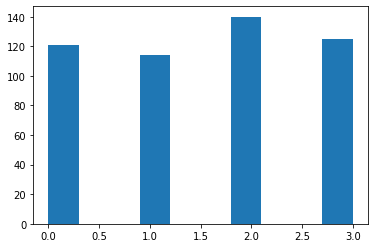

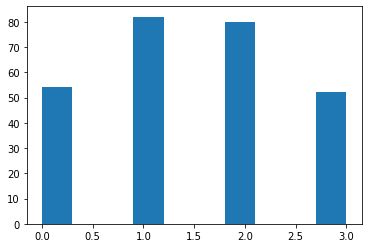

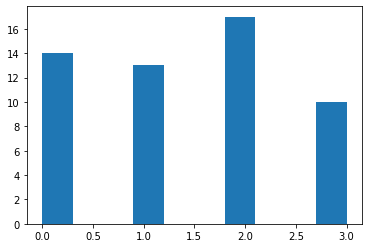

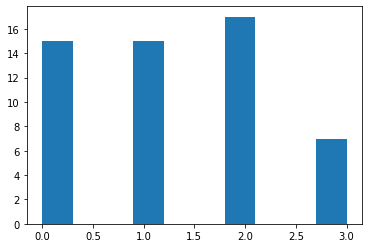

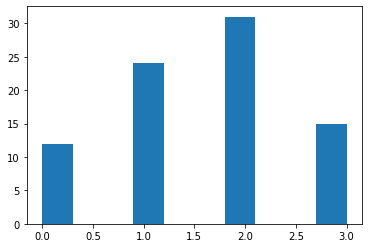

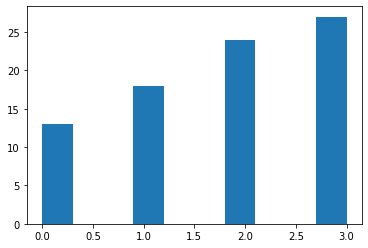

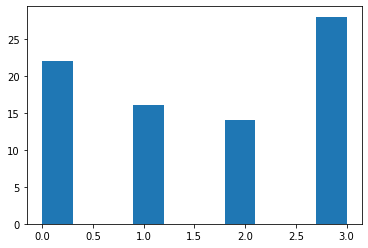

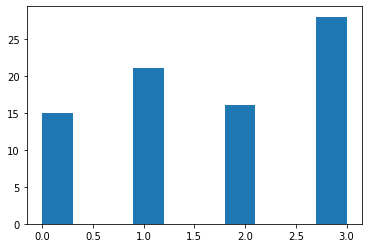

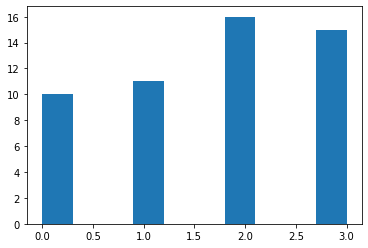

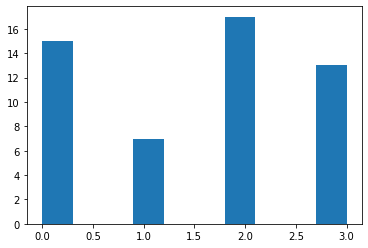

<Figure size 432x288 with 0 Axes>

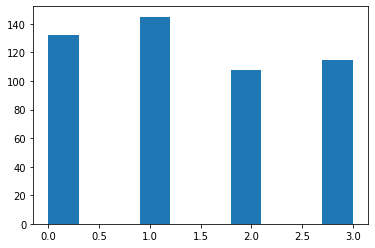

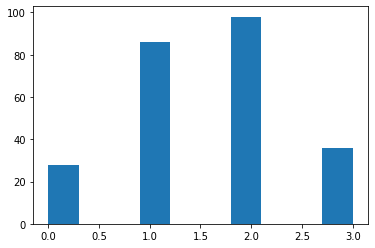

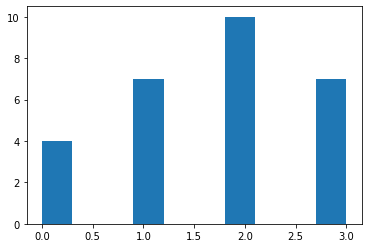

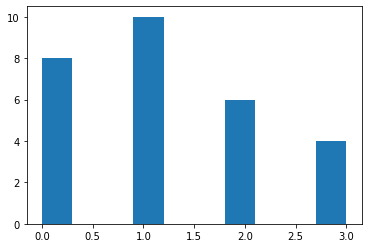

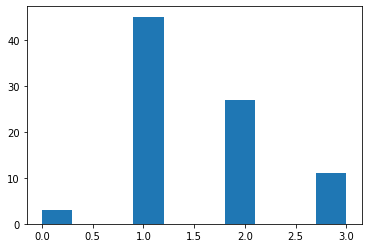

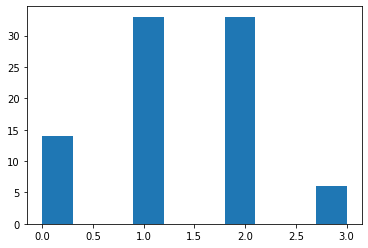

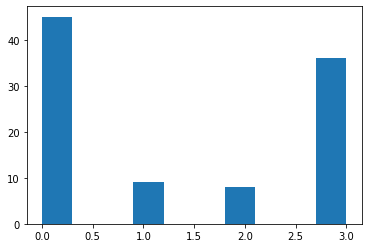

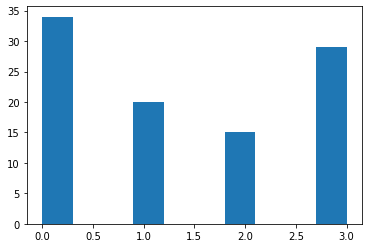

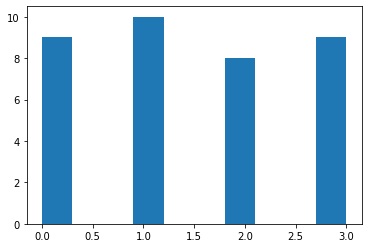

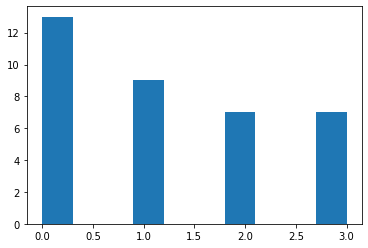

<Figure size 432x288 with 0 Axes>

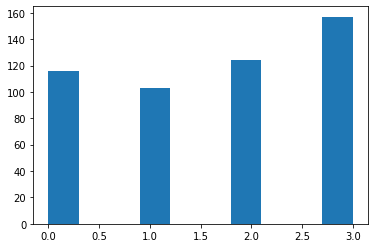

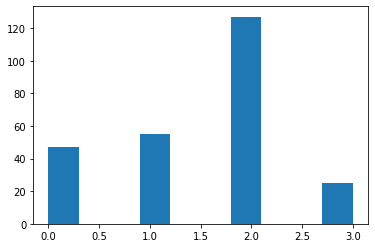

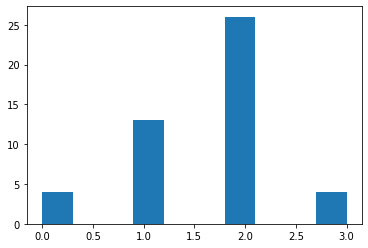

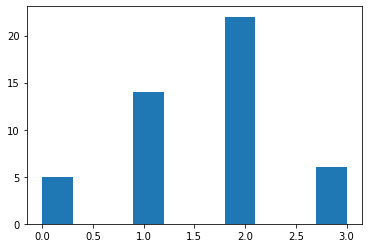

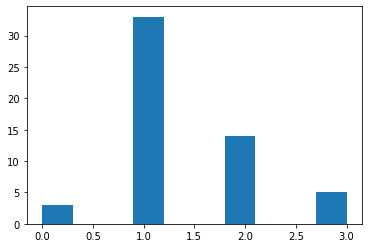

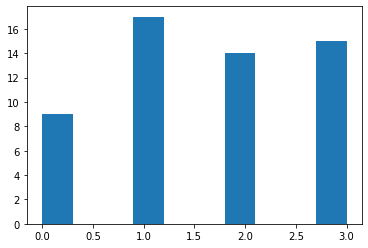

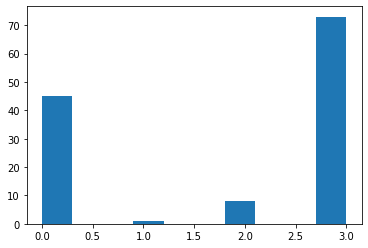

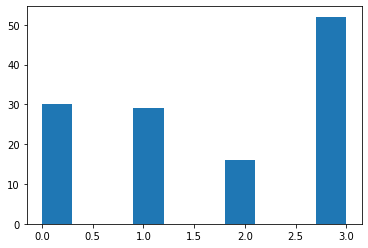

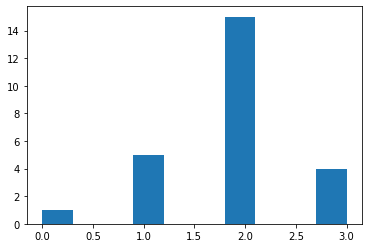

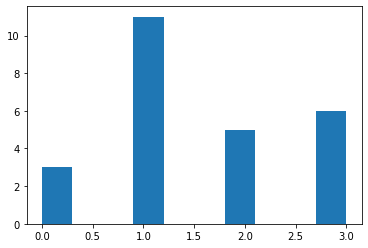

<Figure size 432x288 with 0 Axes>

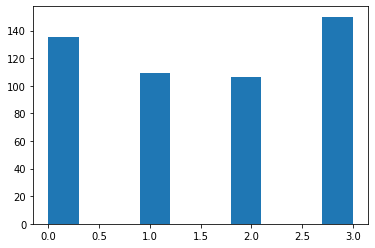

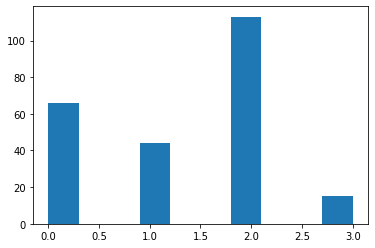

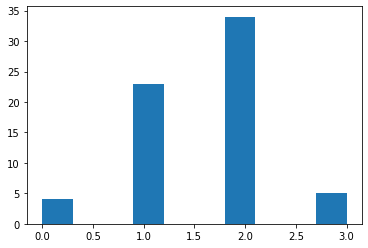

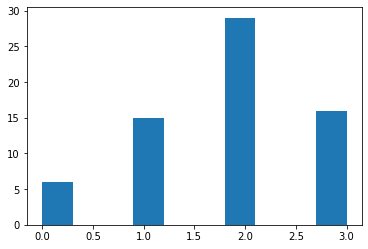

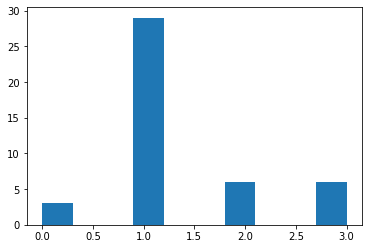

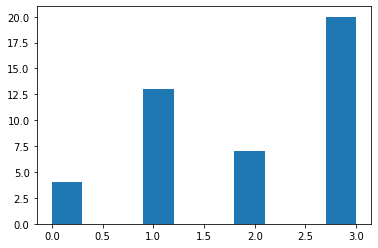

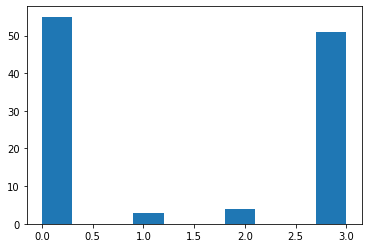

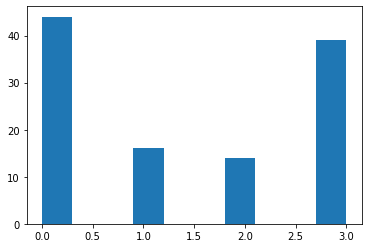

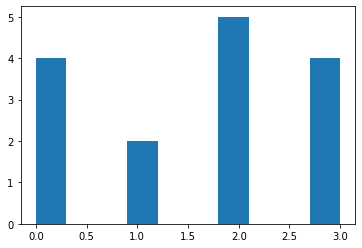

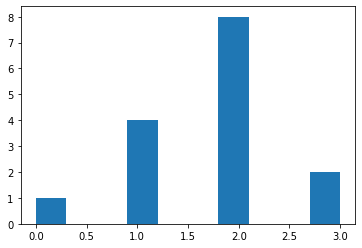

<Figure size 432x288 with 0 Axes>

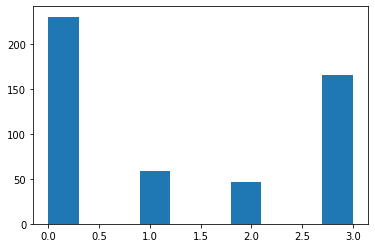

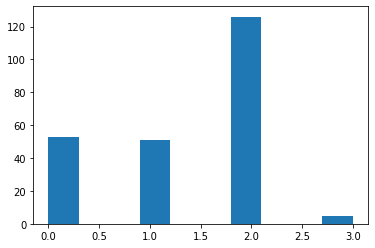

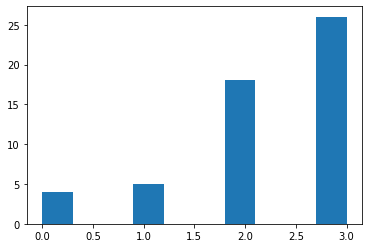

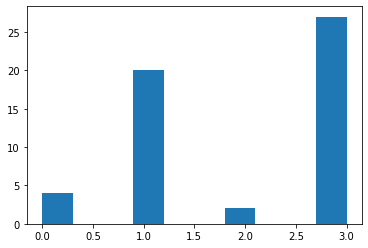

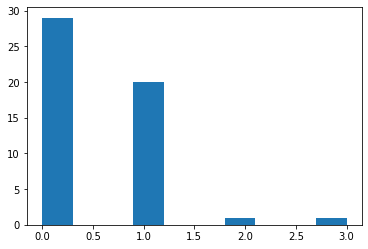

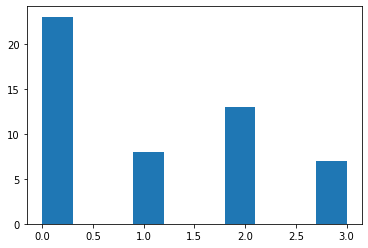

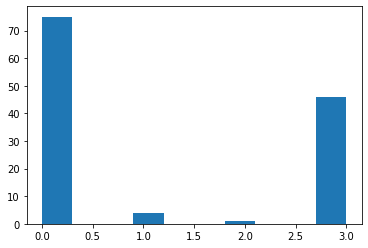

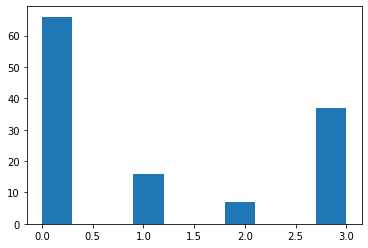

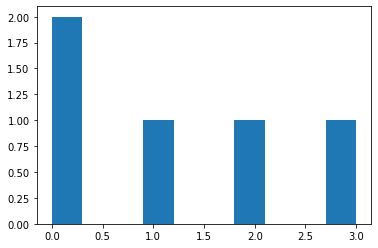

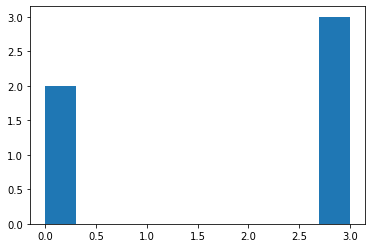

<Figure size 432x288 with 0 Axes>

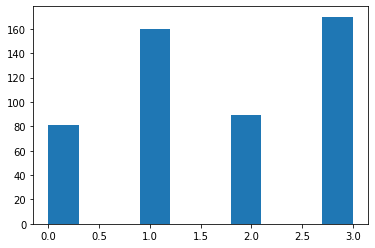

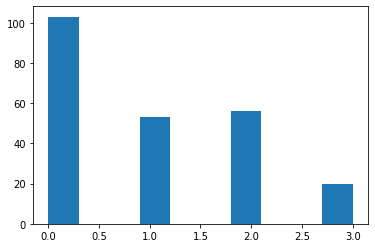

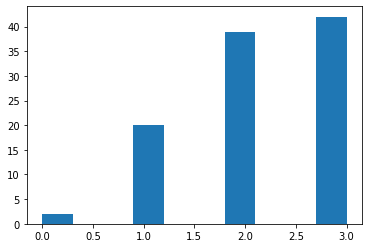

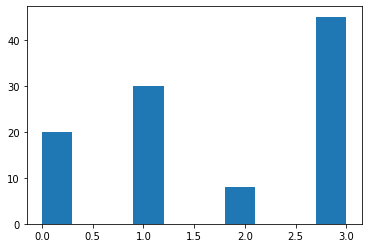

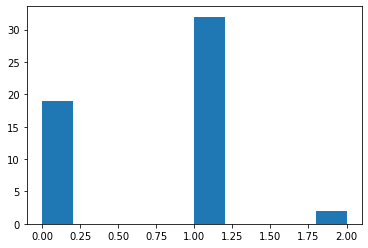

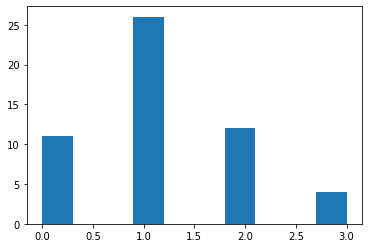

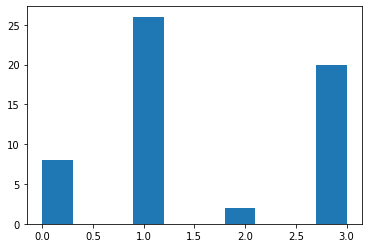

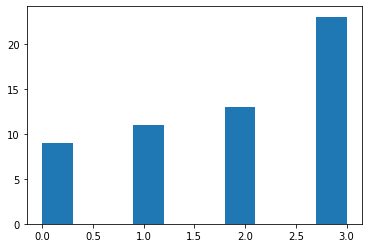

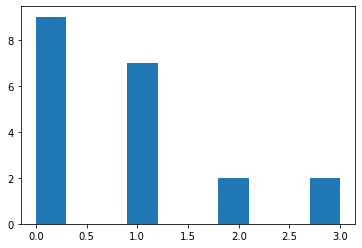

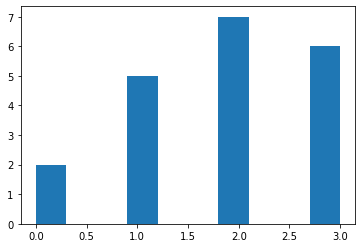

<Figure size 432x288 with 0 Axes>

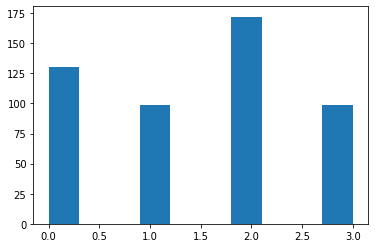

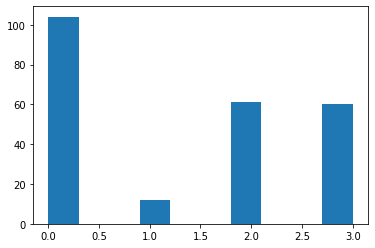

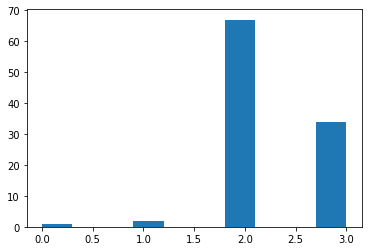

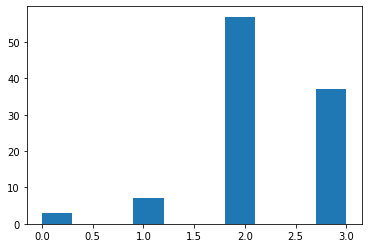

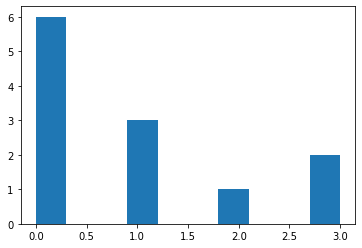

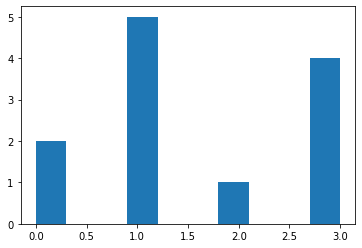

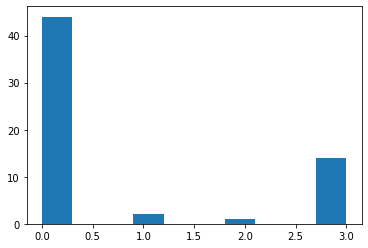

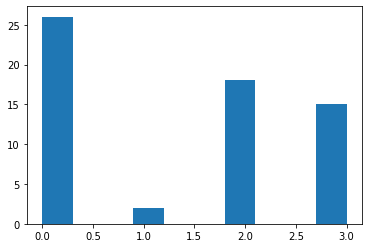

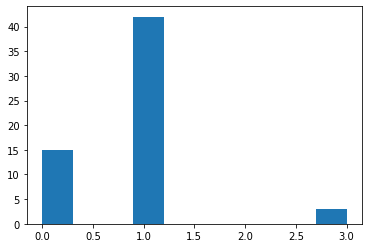

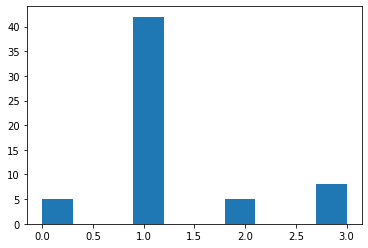

<Figure size 432x288 with 0 Axes>

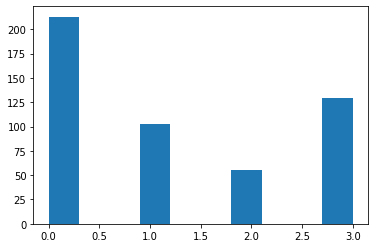

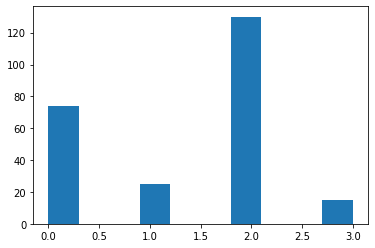

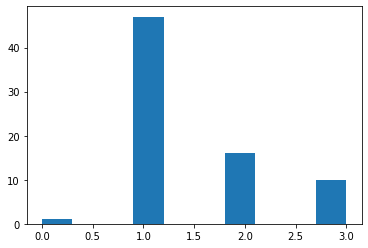

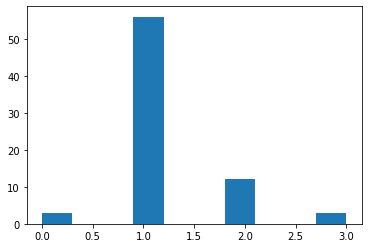

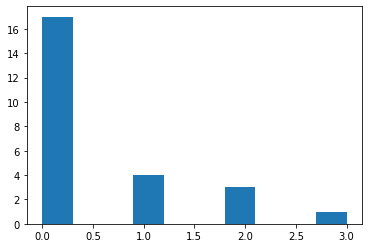

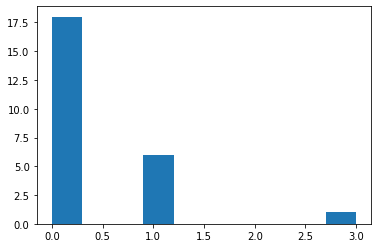

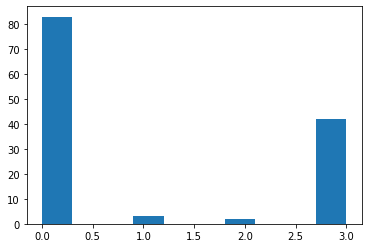

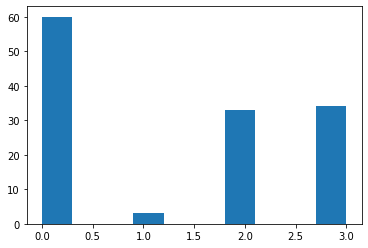

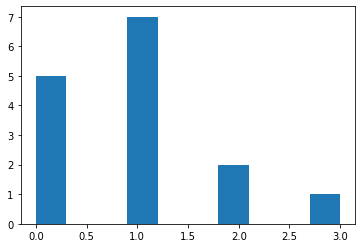

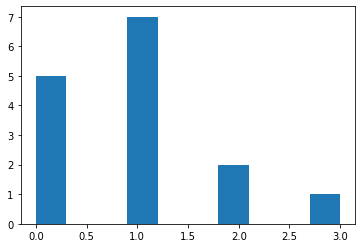

<Figure size 432x288 with 0 Axes>

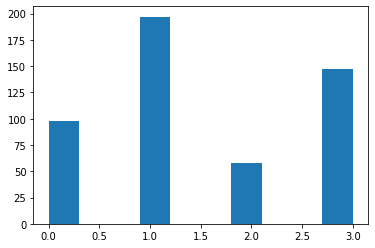

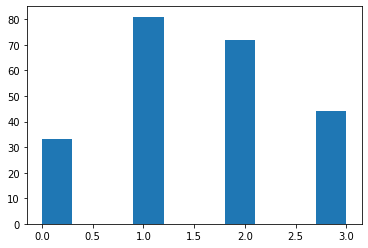

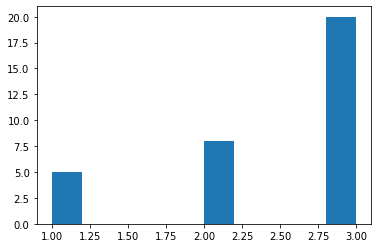

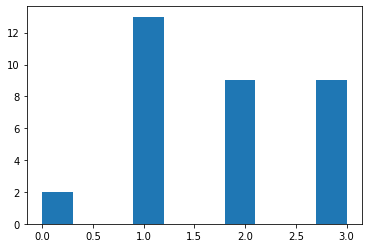

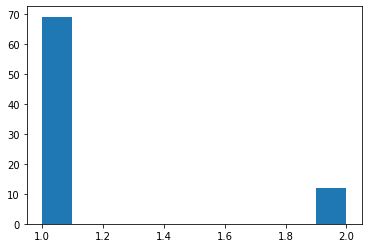

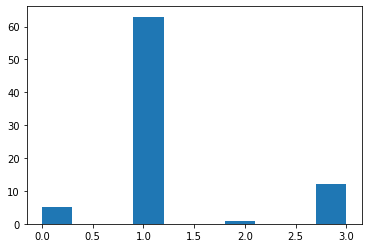

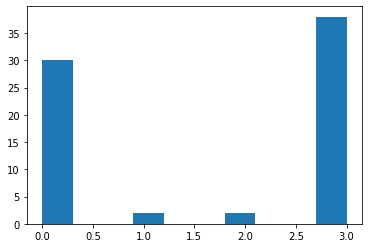

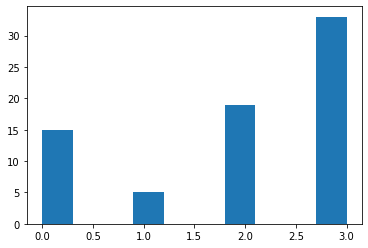

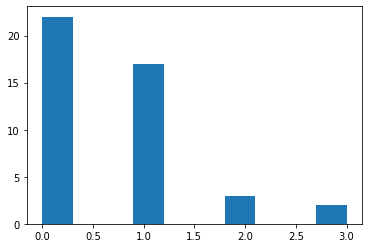

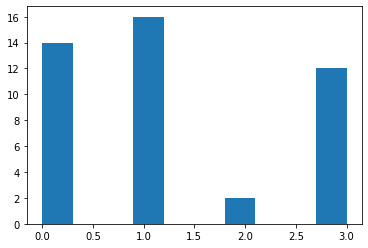

In [113]:
# Iterate the game
episodes = 5000
a1_talk = []
a1_act = []
a2_talk = []
a2_act = []
who_talks_arr = []
scores1 = []
scores2 = []

wins = 1
loses = 1

for e in range(episodes):
    score1 = 0
    score2 = 0
    
    state1, state2, _, _, who_talks = env.step(0, 0, 0)
    #print("state 1: {}, state 2: {}, talks: {}".format(state1, state2, who_talks))
    # agent 1 talks
    if who_talks:
        action1 = agent1.act(state1)
        state1, state2, reward1, reward2, who_talks = env.step(action1[0], 4, 0)  
        score1 += reward1
        action2 = agent2.act(state2)
        #print("state 1: {}, state 2: {}, talks: {}".format(state1, state2, who_talks))
    
        
    # everyone chooses
        next_state1, next_state2, reward1, reward2, who_talks = env.step(action1[1], action2[1], 1)     
        score1 += reward1
        score2 += reward2
        #print("state 1: {}, state 2: {}, talks: {}".format(state1, state2, who_talks))
    
    else:
        action2 = agent2.act(state2)
        state1, state2, reward1, reward2, who_talks = env.step(0, action2[0], 0)   
        score2 += reward2
        action1 = agent1.act(state1)
        #print("state 1: {}, state 2: {}, talks: {}".format(state1, state2, who_talks))
    
    # everyone chooses
        next_state1, next_state2, reward1, reward2, who_talks = env.step(action1[1], action2[1], 1)     
        score1 += reward1
        score2 += reward2
        #print("state 1: {}, state 2: {}, talks: {}".format(state1, state2, who_talks))

    agent2.remember(state2, action2, reward2, next_state2)
    agent1.remember(state1, action1, reward1, next_state1)

    if e > 0 and e % 500 == 0:
        scores1_arr = np.array(scores1[e-500:e])
        a1_talk_arr = np.array(a1_talk[e-500:e])
        a1_act_arr = np.array(a1_act[e-500:e])
        a2_talk_arr = np.array(a2_talk[e-500:e])
        a2_act_arr = np.array(a2_act[e-500:e])
        who_talks_arr_2 = np.array(who_talks_arr[e-500:e])
        plt.figure()
        plt.figure()
        plt.hist(a1_act_arr)
        plt.figure()
        plt.hist(a1_talk_arr[who_talks_arr_2==1])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 0])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 0])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 1])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 1])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 2])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 2])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 3])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 3])
        
    
    print("episode: {}/{}, score1: {}, score2: {}"
                  .format(e, episodes, score1, score2))
    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        #if wins/loses < np.random.uniform(0,2):   
        agent1.replay(10)
        agent2.replay(10)
    
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2_talk.append(action2[0])
    a2_act.append(action2[1])
    who_talks_arr.append(who_talks)
    scores1.append(score1)
    scores2.append(score2)

(array([12.,  0.,  0.,  4.,  0.,  0.,  8.,  0.,  0.,  3.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

<Figure size 432x288 with 0 Axes>

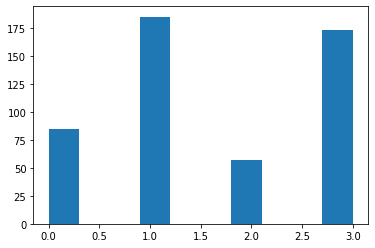

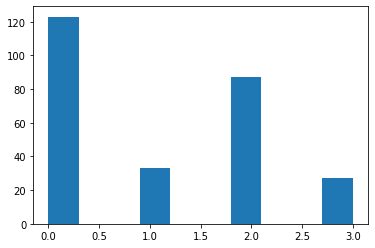

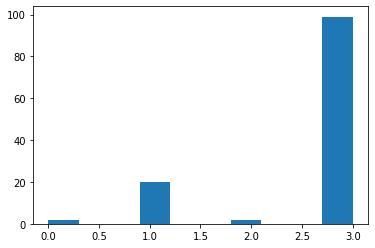

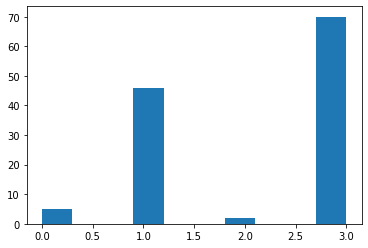

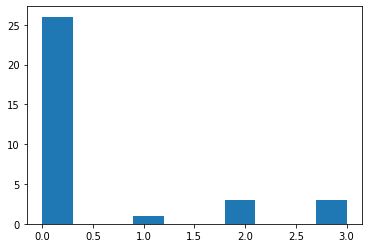

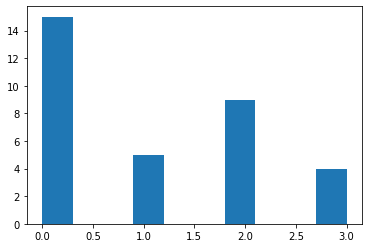

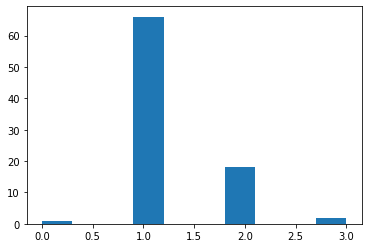

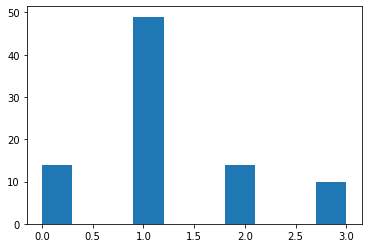

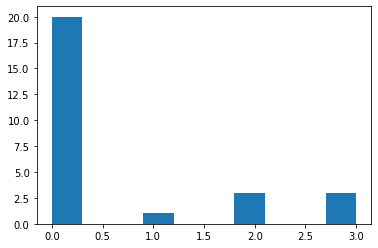

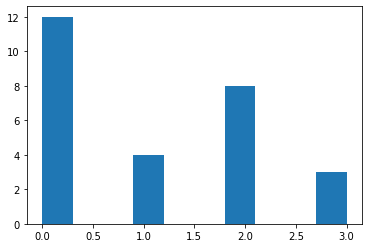

In [114]:
plt.figure()
plt.figure()
plt.hist(a2_act_arr)
plt.figure()
plt.hist(a2_talk_arr[who_talks_arr_2==0])
plt.figure()
plt.hist(a2_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a1_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a2_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a1_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a2_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a1_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a2_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])
plt.figure()
plt.hist(a1_act_arr[who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])

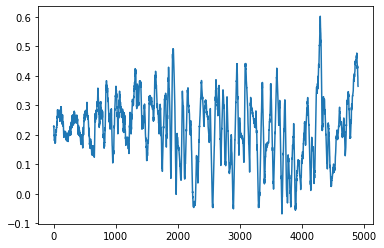

In [115]:
plt.plot(np.convolve(scores1, np.ones((100,))/100, mode='valid'))

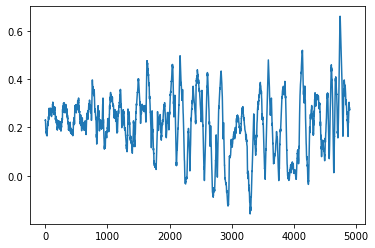

In [116]:
plt.plot(np.convolve(scores2, np.ones((100,))/100, mode='valid'))

## Inner speach added

In [280]:
class DQNAgent_student_teacher:
    def __init__(self, talking_action_size, choices, memory_size = 11): 
        self.memory = collections.deque(maxlen=memory_size)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.999
        self.learning_rate_bad = 0.0001
        self.learning_rate_good = 0.0001
        self.talking_action_size = talking_action_size
        self.choices = choices
        self.model = self._build_model_student_teacher()
 
 
    def _build_model_student_teacher(self):
        # Neural Net for Deep-Q learning Model
        
        model = Sequential()
        #model.add(Dense(25, input_dim=self.talking_action_size + self.talking_action_size +self.talking_action_size+ 1, activation='relu')) # one input - the game role
        model.add(Dense(25, input_dim=self.talking_action_size + self.talking_action_size+ 1, activation='relu')) # one input - the game role
        model.add(Dense(15, activation='softmax'))
        model.add(Dense(10, activation='relu'))
 
        model.add(Dense(self.choices, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate_bad))
        return model
       
   
    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
                           
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return [random.randrange(self.talking_action_size), random.randrange(self.choices)]
 
        
        max_q = -float("infinity")
        max_talk = None
        max_action = None
 
        for i in range(self.talking_action_size):
            talking = np.zeros(self.talking_action_size)
            talking[i] = 1
 
            state_cur = np.expand_dims(np.hstack([state, talking]), axis=0)
            act_values = self.model.predict(state_cur, batch_size=1)
 
            cur_max = np.max(act_values)
           
            if cur_max > max_q:
 
              max_q = cur_max
              max_action = np.argmax(act_values[0])
              max_talk = i
 
            assert max_talk is not None
            assert max_action is not None
 
        return [max_talk, max_action]
                           
    def replay(self, batch_size):
        for i in self.memory:
            minibatch = random.sample(self.memory, batch_size)
        my_x = []
        my_y = []
        for state, action, reward, next_state in minibatch:
            next_state = np.expand_dims(next_state, axis=0)
            #state = np.expand_dims(state, axis=0)
            target = reward
            one_hot_talk = np.zeros(self.talking_action_size)
            one_hot_talk[action[0]] = 1
            cur_state = np.expand_dims(np.hstack([state, one_hot_talk]), axis=0)
            target_f = self.model.predict(cur_state, batch_size=1)
            target_f[0][action[1]] = target # choose
            cur_state = np.squeeze(cur_state)
            target_f = np.squeeze(target_f)
            my_x.append(cur_state)
            my_y.append(target_f)
        
        my_x = np.array(my_x)
        my_y = np.array(my_y)
        self.model.fit(my_x, my_y, batch_size=batch_size, epochs=1, verbose=0)
 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [222]:
num_choices = 4
num_talking_symbols = 4
winning_reward = 1
mean_sample = 100
punishment_weight = 3

agent1 = DQNAgent_student_teacher(num_talking_symbols, num_choices)
agent2 = DQNAgent_student_teacher(num_talking_symbols, num_choices) 
env = Two_Roles_Game(num_choices, winning_reward, mean_sample, num_talking_symbols, punishment_weight) 

episode: 500/10000, score1: 0, score2: 0.27
episode: 1000/10000, score1: 0.12000000000000002, score2: 0


/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


episode: 1500/10000, score1: 0, score2: -0.6800000000000002


/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

episode: 2000/10000, score1: 0.36, score2: 0.39
episode: 2500/10000, score1: 0, score2: 0.09
episode: 3000/10000, score1: -1.2000000000000002, score2: 0.23999999999999996
episode: 3500/10000, score1: 0.61, score2: 1.45
episode: 4000/10000, score1: -0.18, score2: 0.42000000000000004
episode: 4500/10000, score1: 0, score2: 0.79
episode: 5000/10000, score1: 0.66, score2: 0
episode: 5500/10000, score1: 0, score2: 0.25
episode: 6000/10000, score1: 0.05999999999999997, score2: 0
episode: 6500/10000, score1: -0.06000000000000005, score2: -0.21000000000000002
episode: 7000/10000, score1: 0.21000000000000002, score2: -0.42000000000000004
episode: 7500/10000, score1: 0.3699999999999999, score2: 0.3699999999999999
episode: 8000/10000, score1: 0.6000000000000001, score2: 0
episode: 8500/10000, score1: 1.54, score2: 1.51
episode: 9000/10000, score1: 0.61, score2: 0
episode: 9500/10000, score1: 0.58, score2: 0


<Figure size 432x288 with 0 Axes>

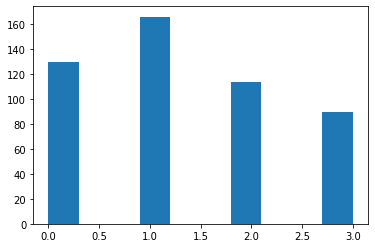

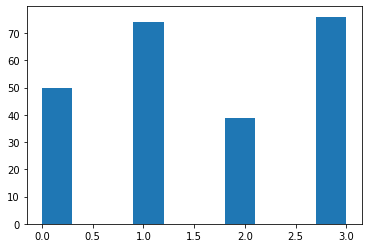

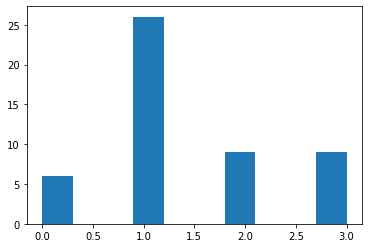

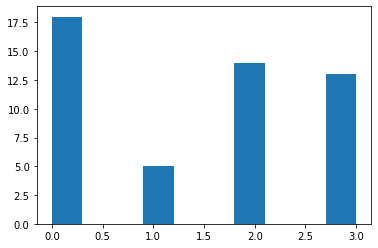

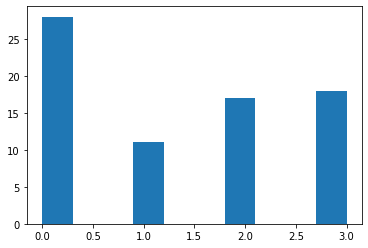

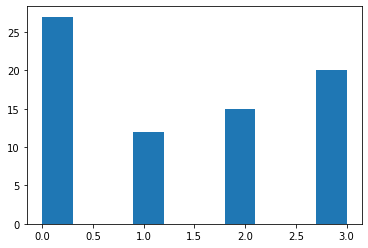

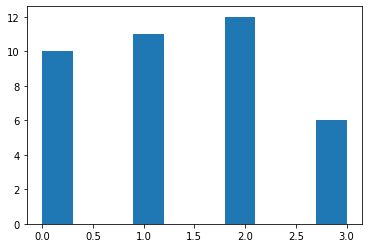

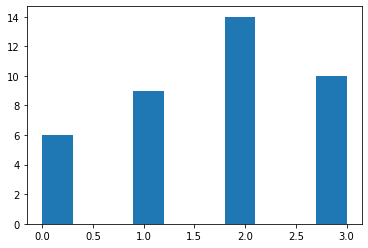

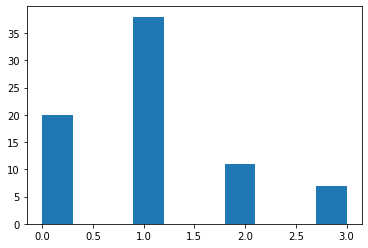

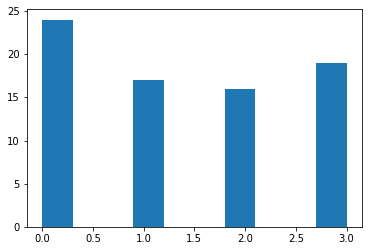

<Figure size 432x288 with 0 Axes>

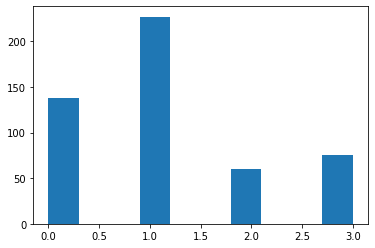

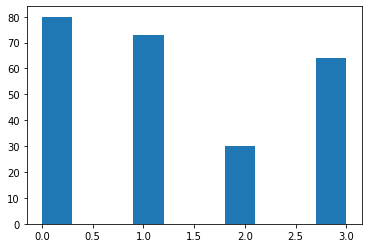

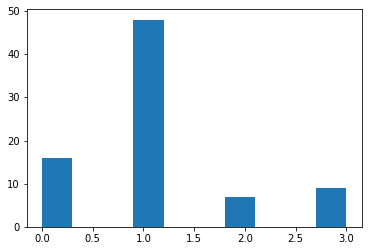

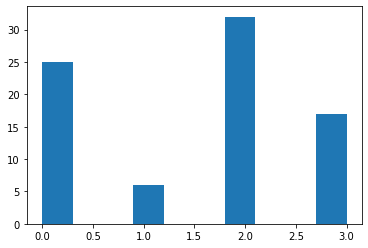

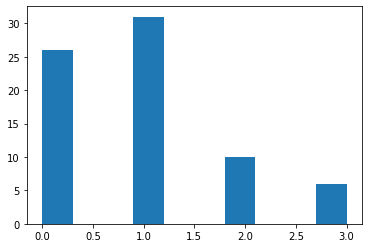

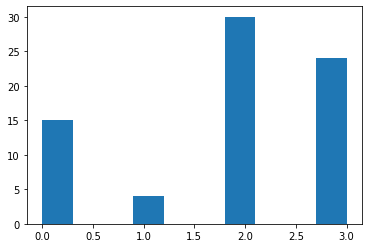

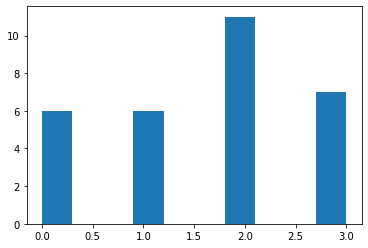

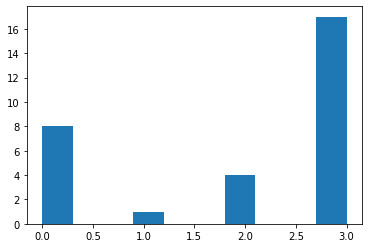

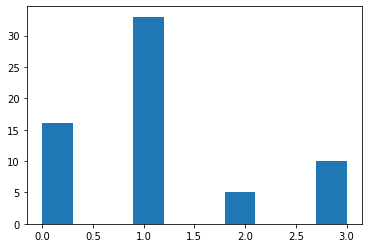

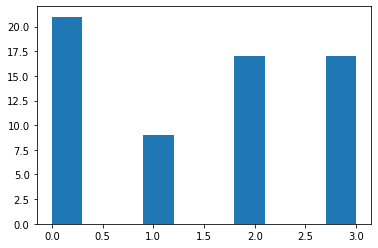

<Figure size 432x288 with 0 Axes>

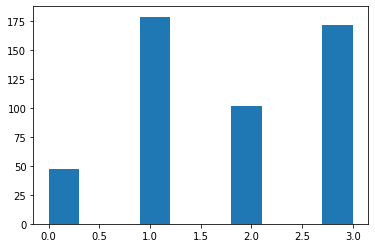

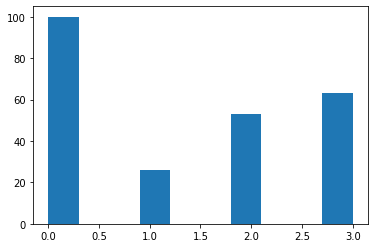

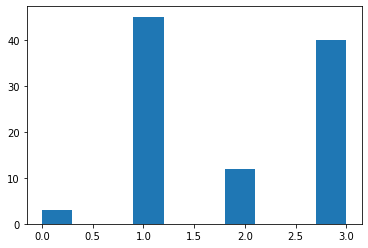

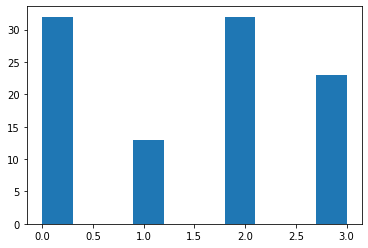

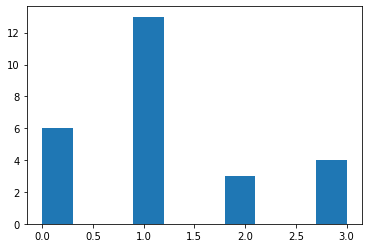

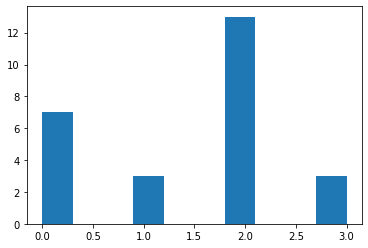

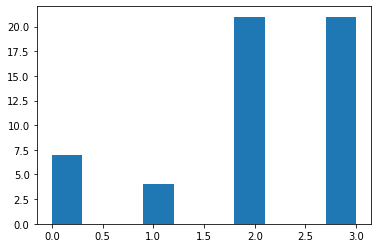

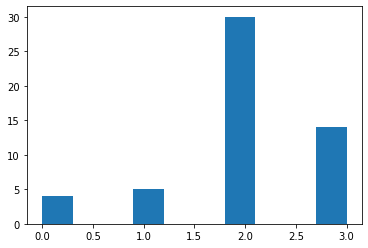

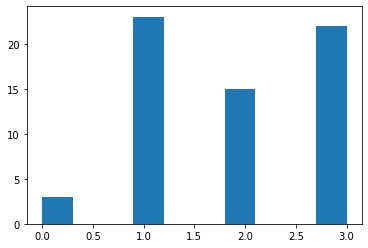

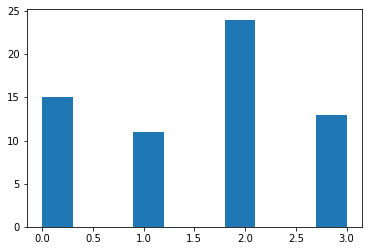

<Figure size 432x288 with 0 Axes>

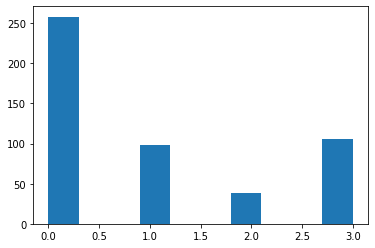

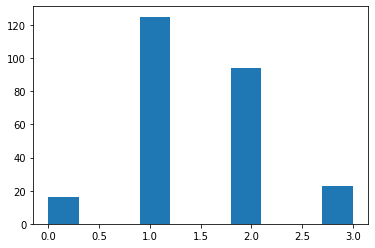

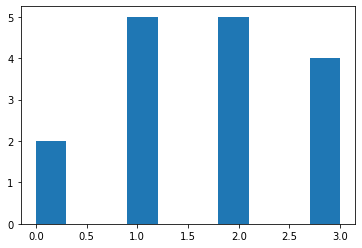

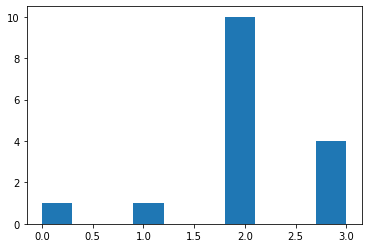

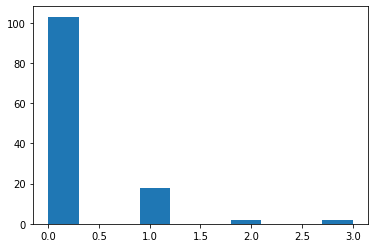

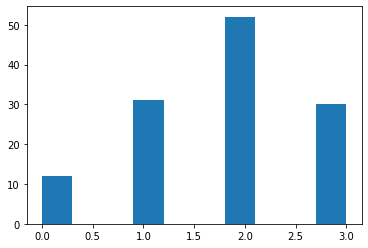

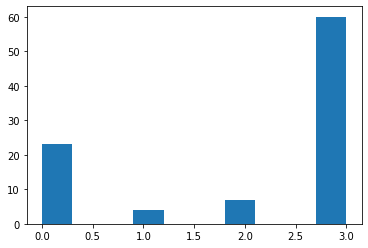

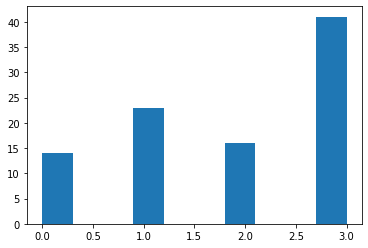

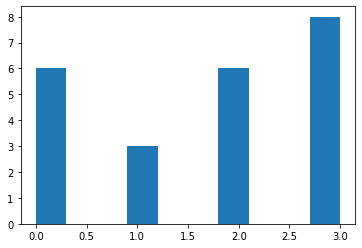

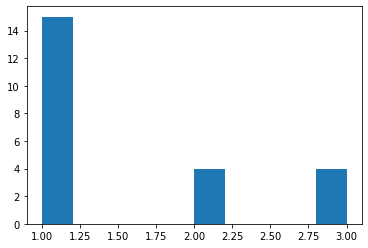

<Figure size 432x288 with 0 Axes>

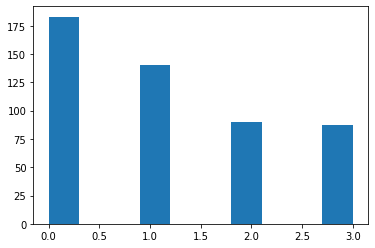

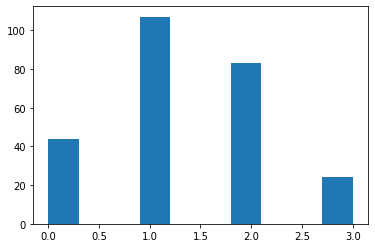

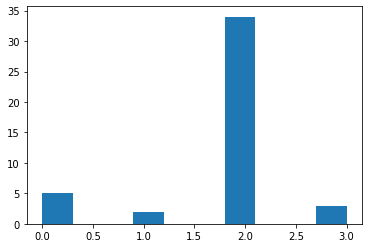

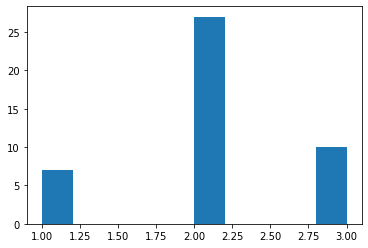

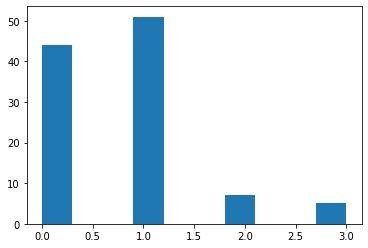

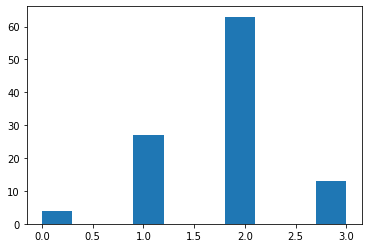

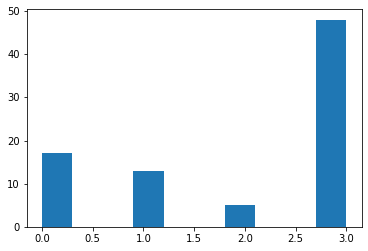

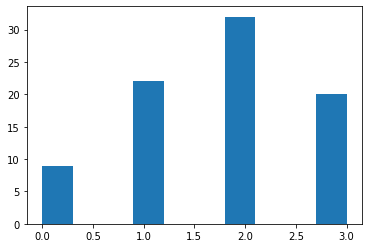

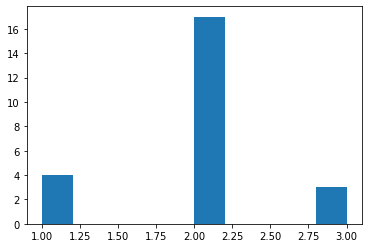

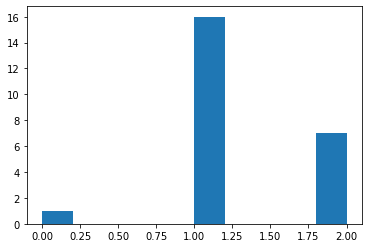

<Figure size 432x288 with 0 Axes>

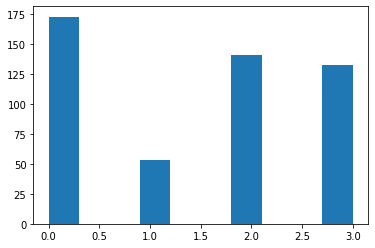

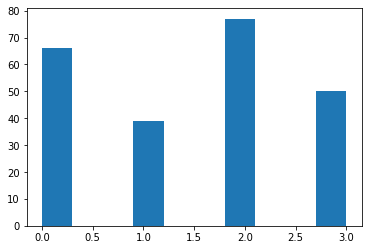

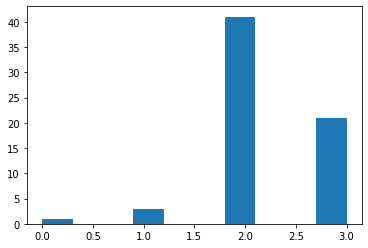

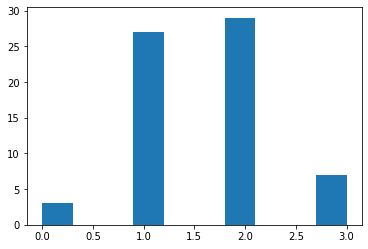

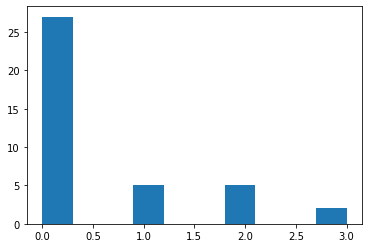

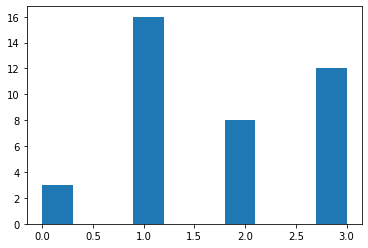

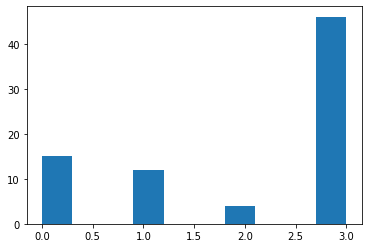

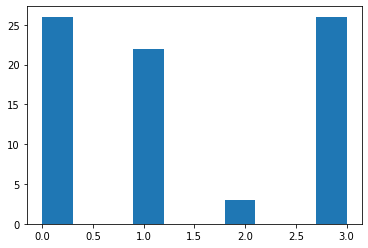

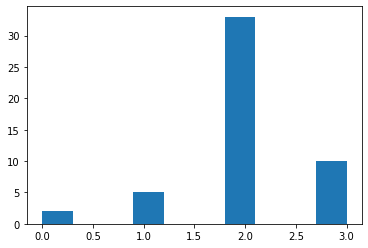

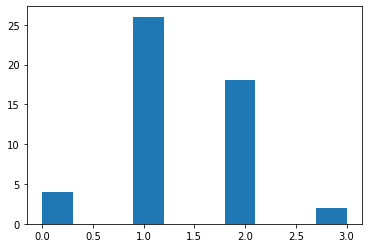

<Figure size 432x288 with 0 Axes>

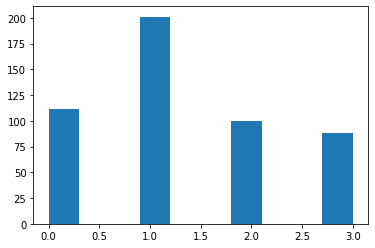

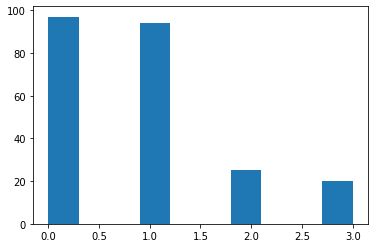

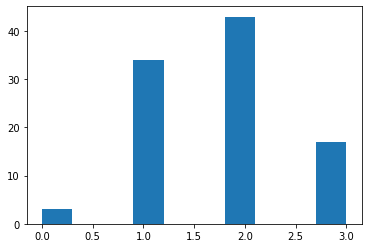

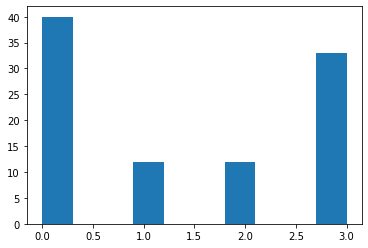

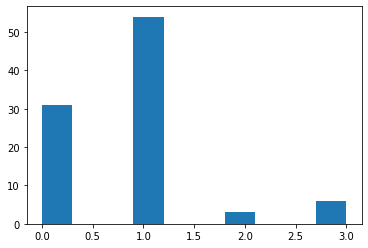

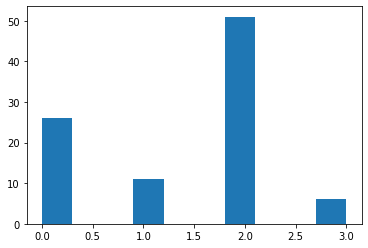

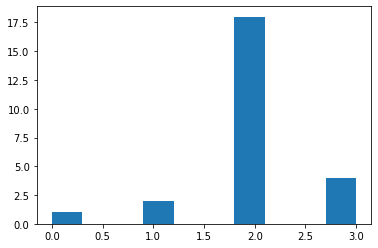

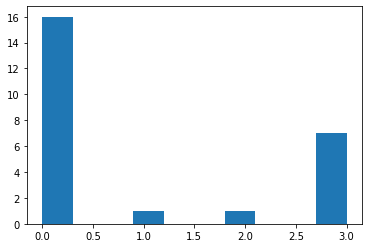

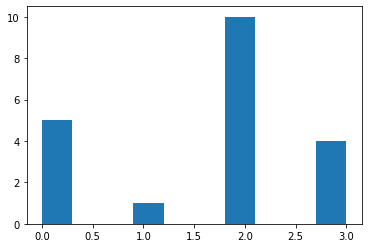

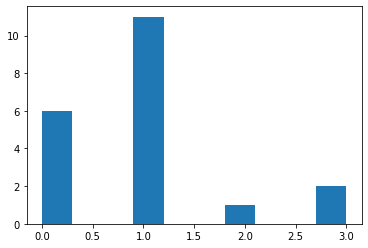

<Figure size 432x288 with 0 Axes>

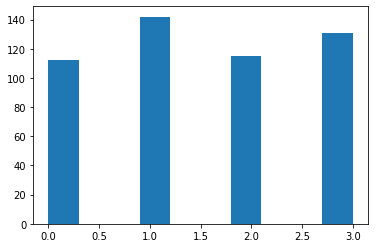

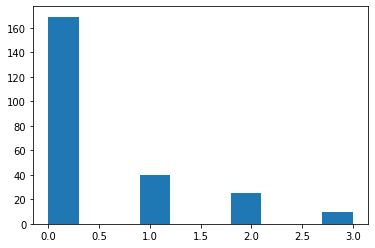

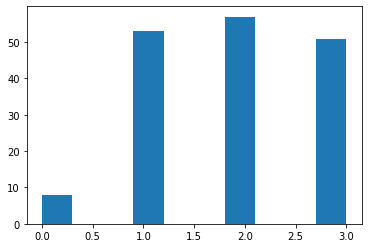

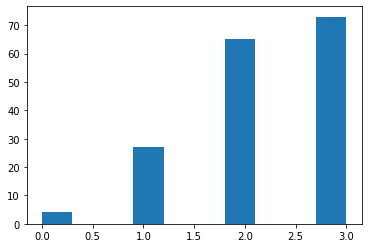

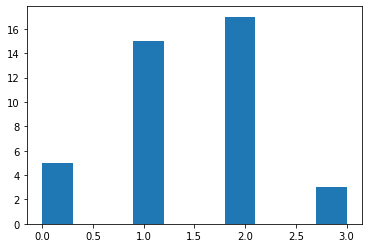

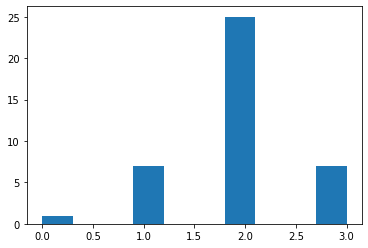

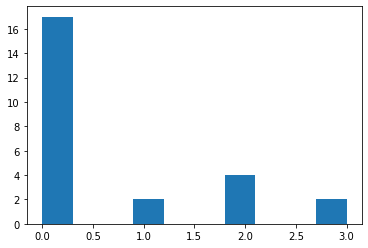

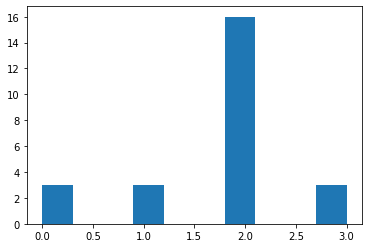

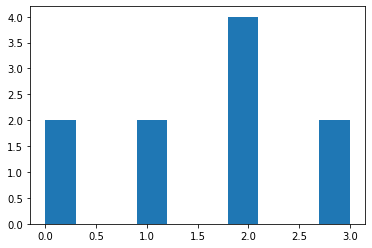

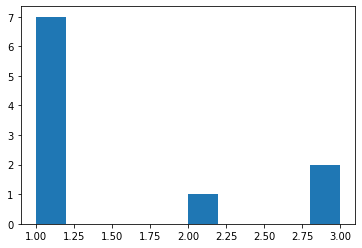

<Figure size 432x288 with 0 Axes>

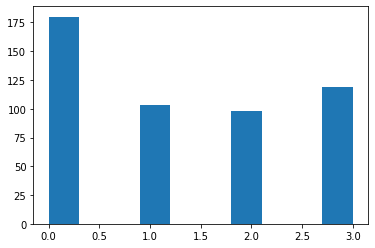

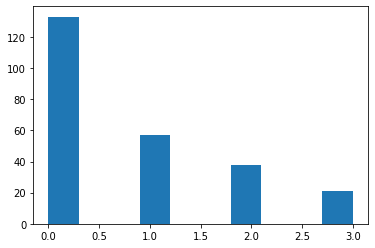

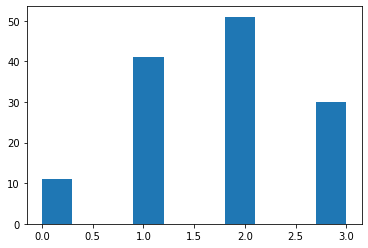

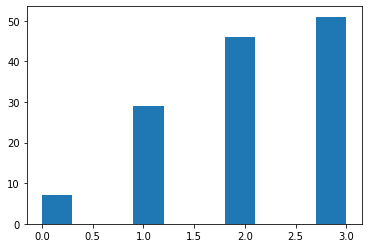

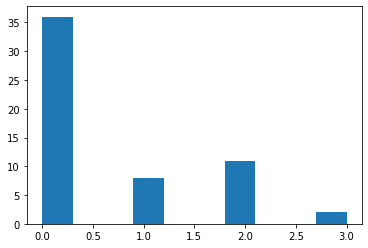

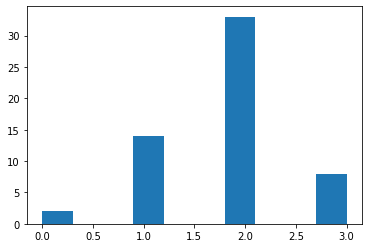

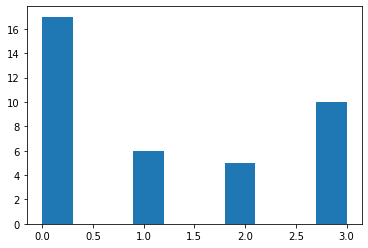

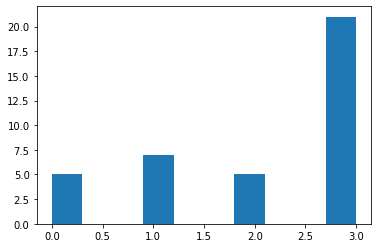

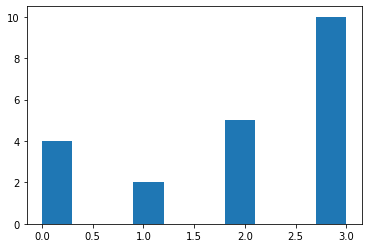

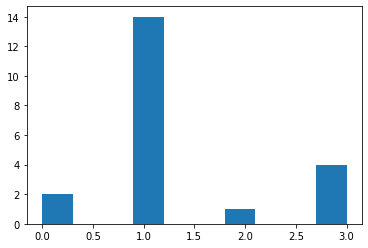

<Figure size 432x288 with 0 Axes>

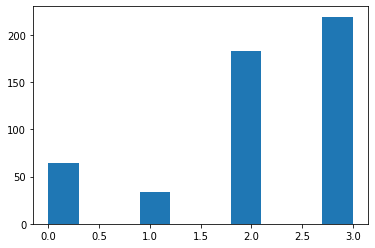

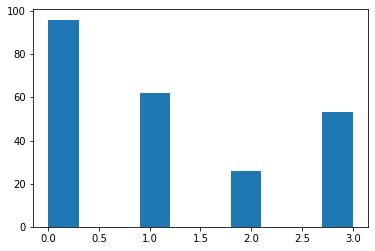

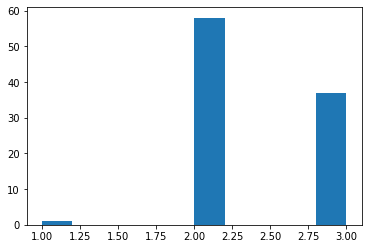

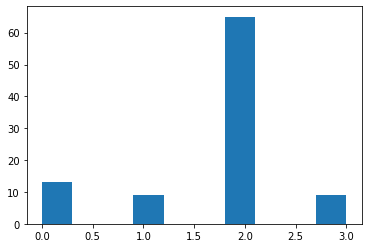

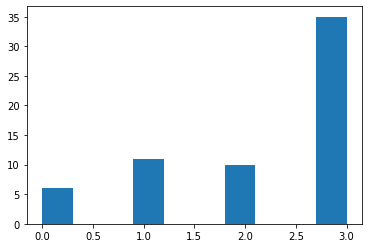

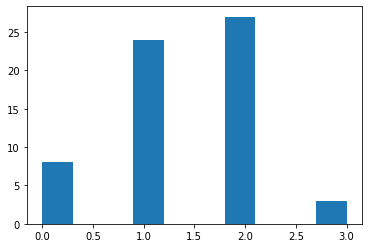

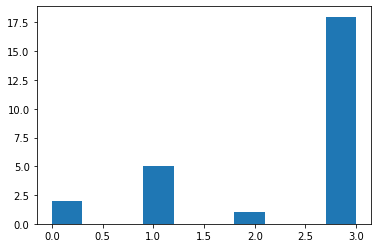

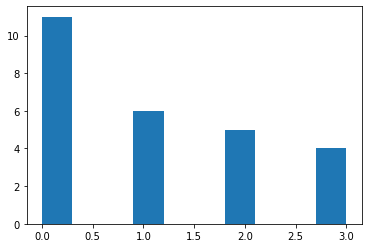

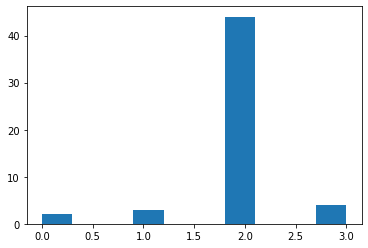

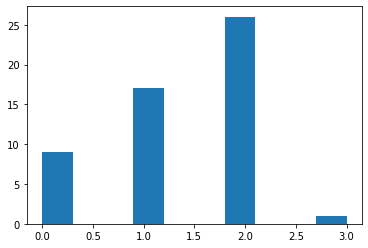

<Figure size 432x288 with 0 Axes>

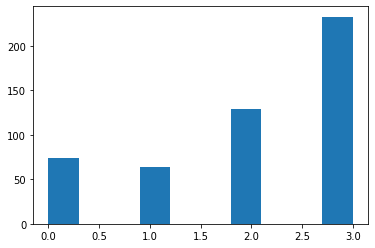

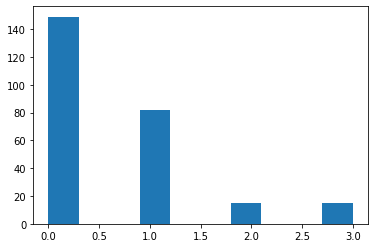

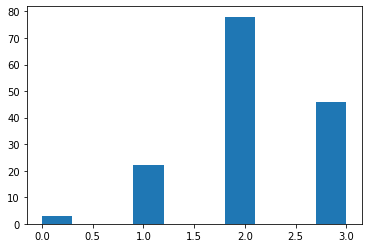

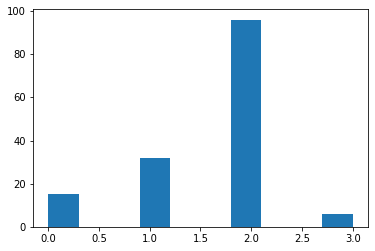

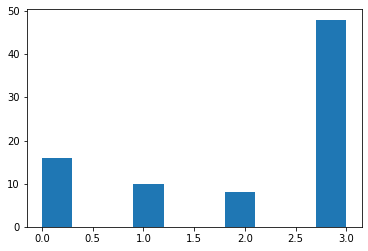

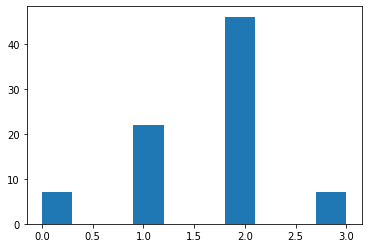

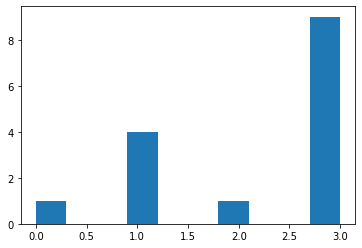

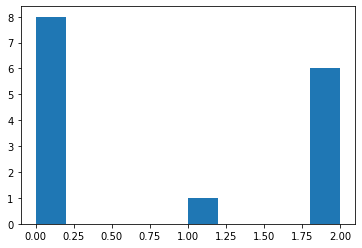

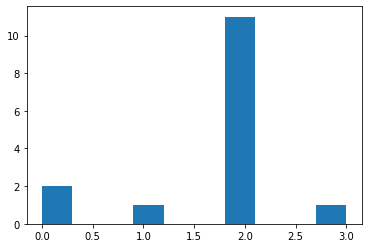

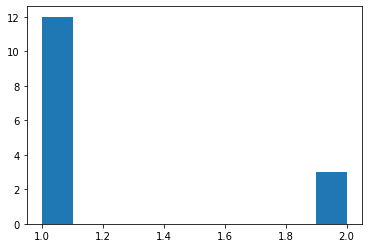

<Figure size 432x288 with 0 Axes>

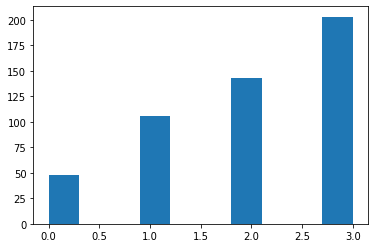

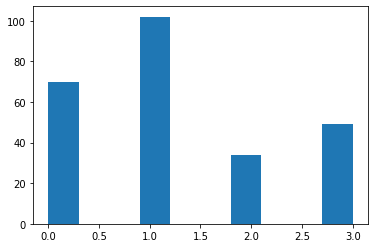

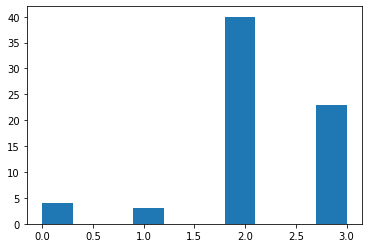

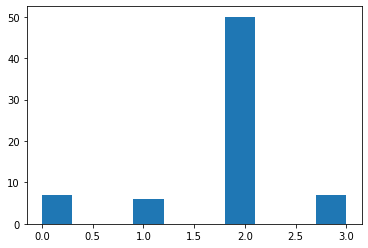

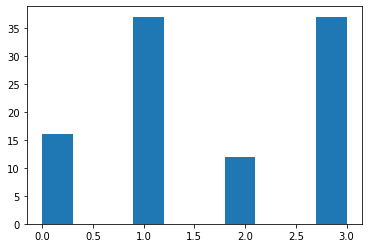

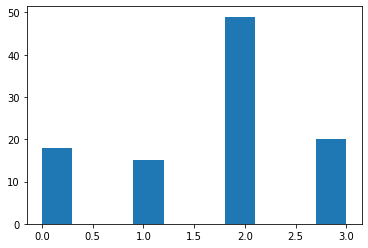

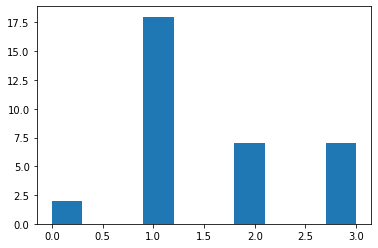

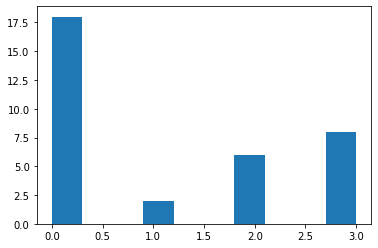

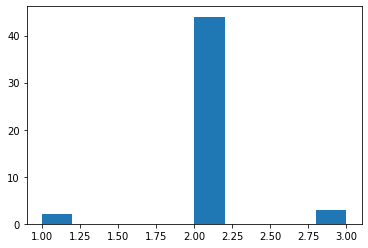

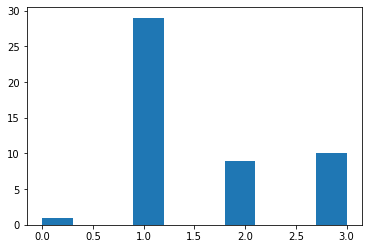

<Figure size 432x288 with 0 Axes>

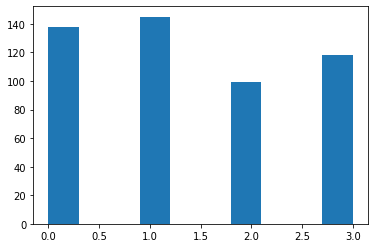

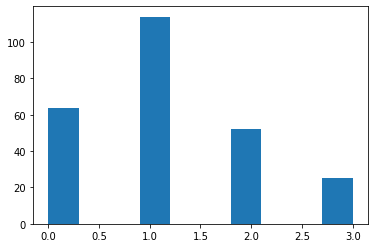

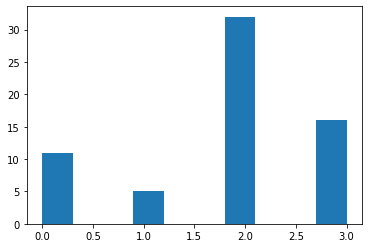

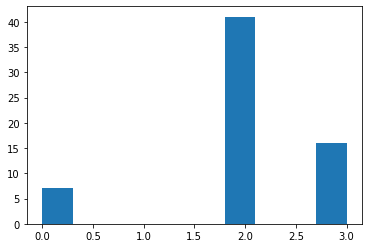

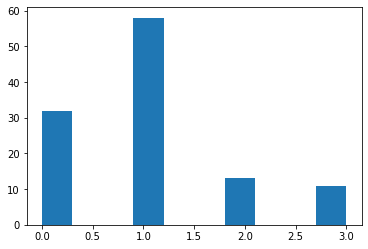

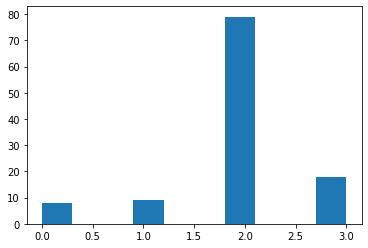

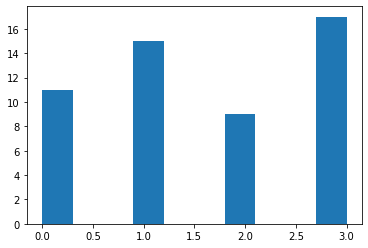

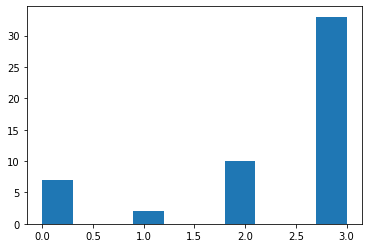

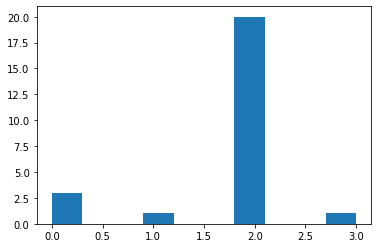

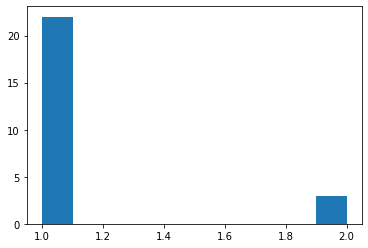

<Figure size 432x288 with 0 Axes>

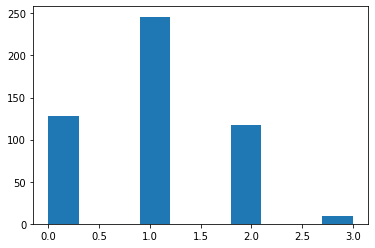

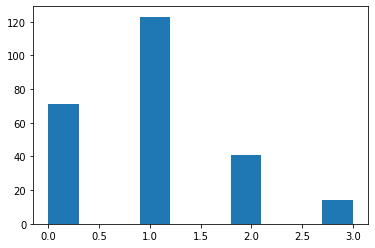

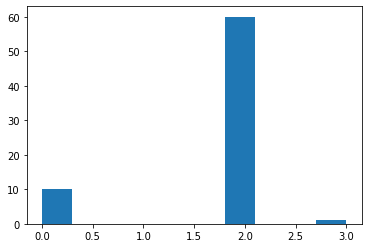

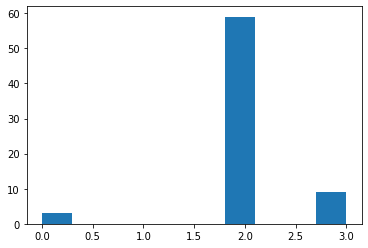

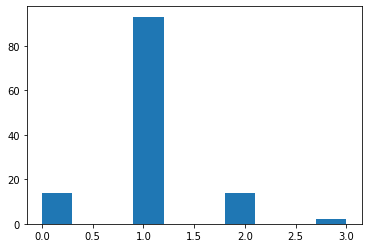

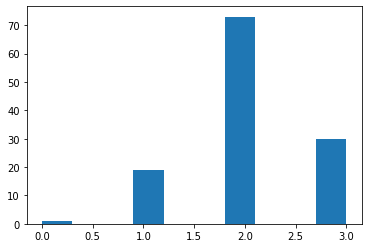

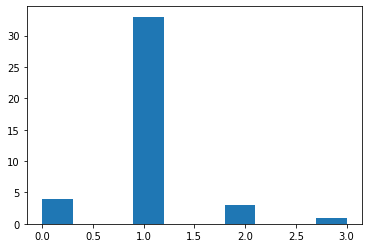

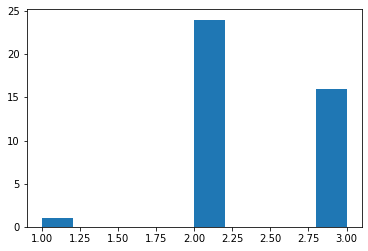

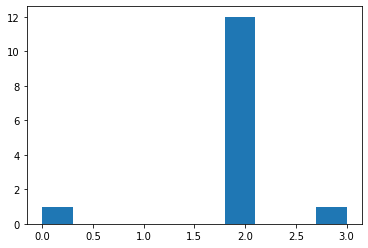

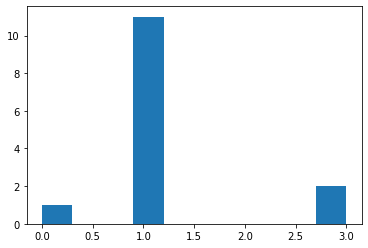

<Figure size 432x288 with 0 Axes>

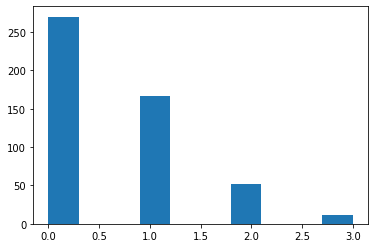

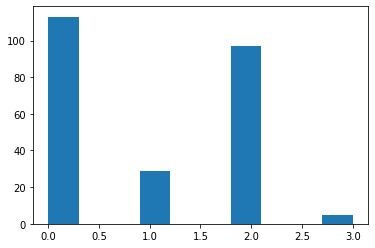

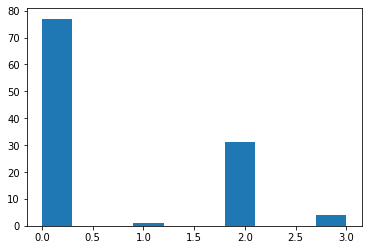

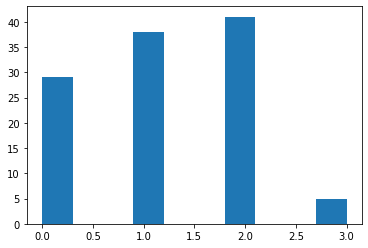

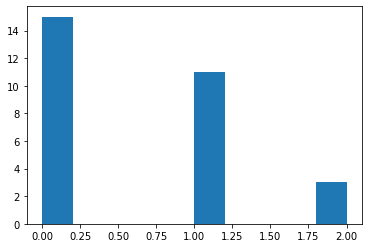

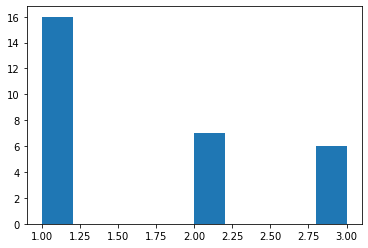

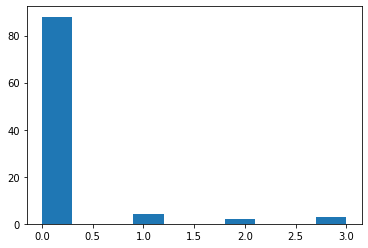

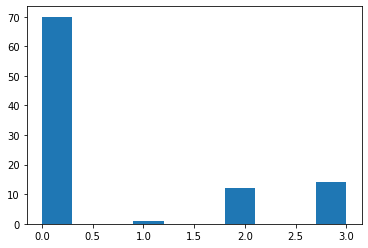

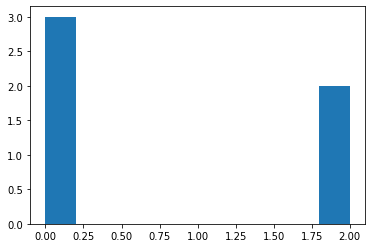

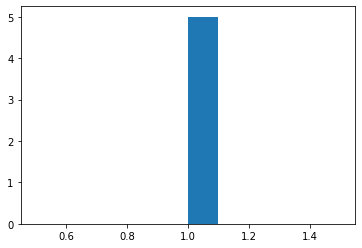

<Figure size 432x288 with 0 Axes>

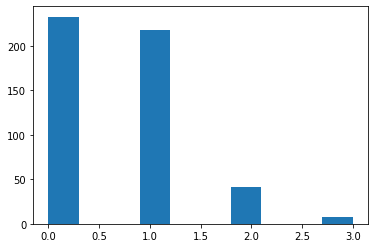

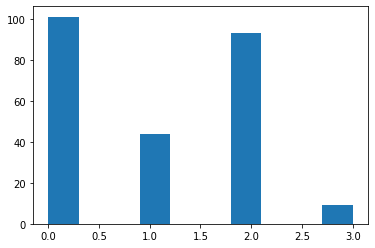

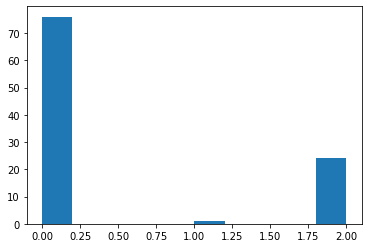

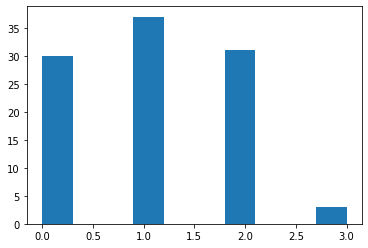

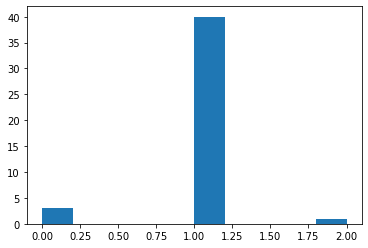

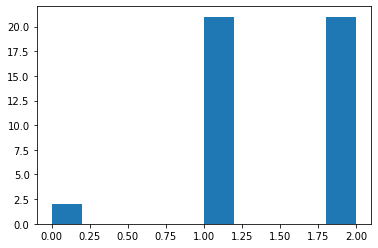

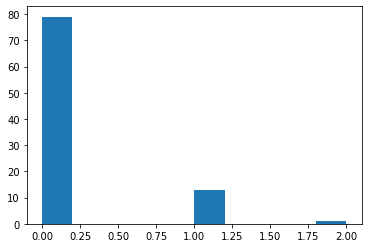

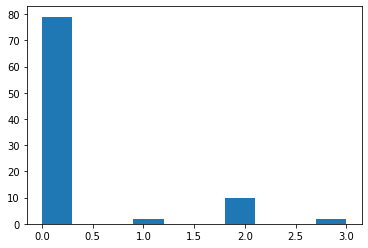

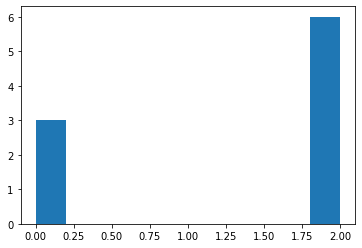

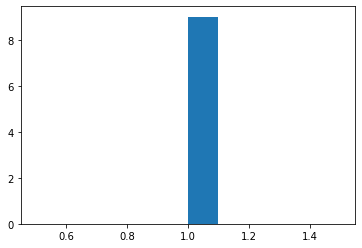

<Figure size 432x288 with 0 Axes>

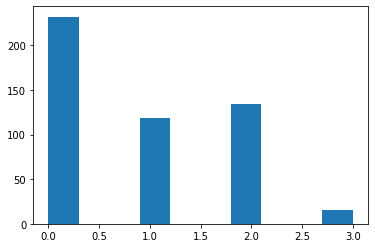

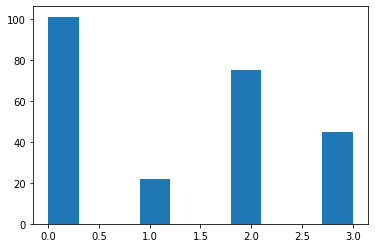

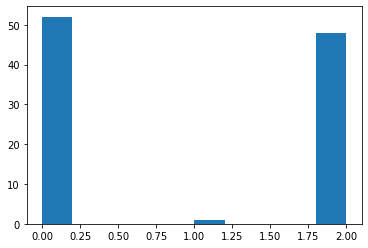

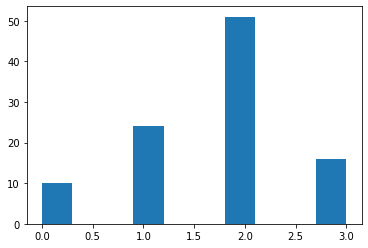

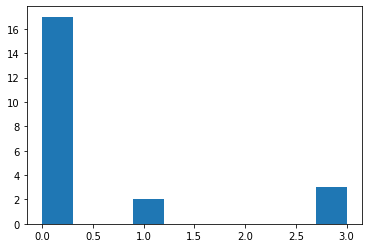

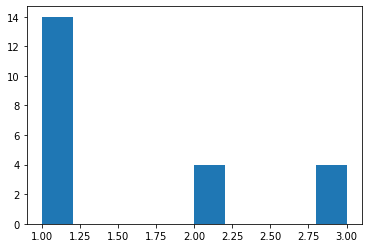

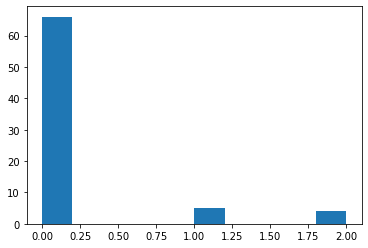

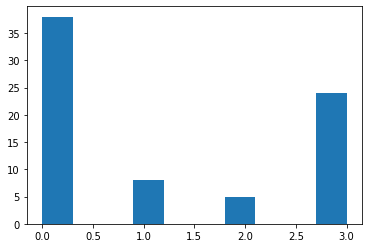

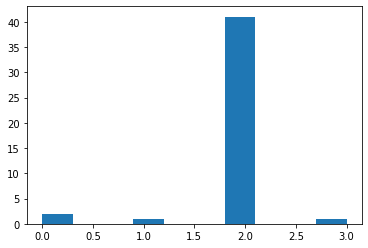

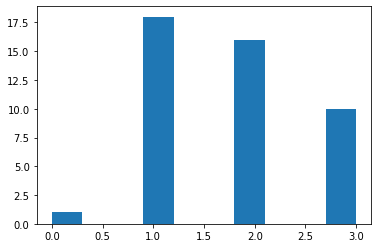

<Figure size 432x288 with 0 Axes>

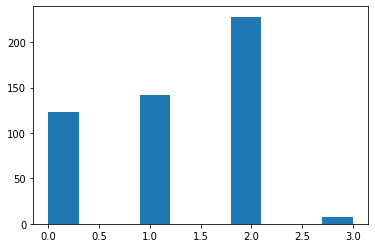

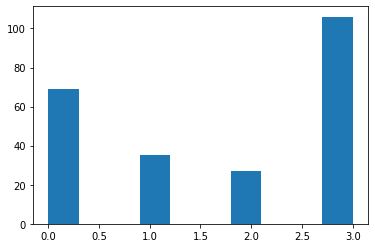

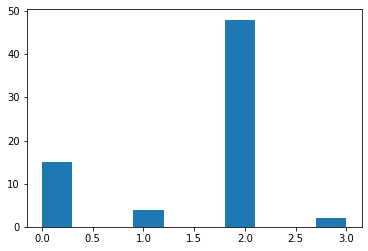

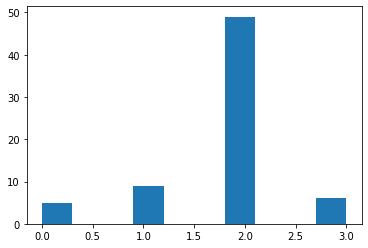

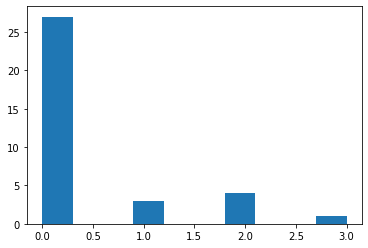

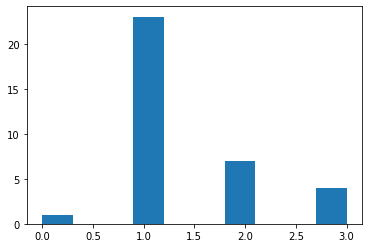

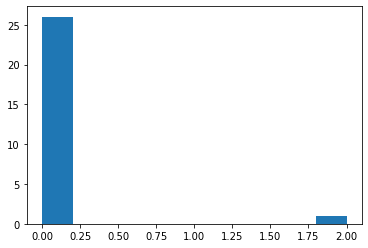

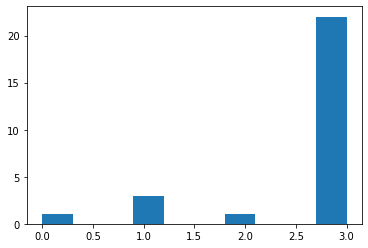

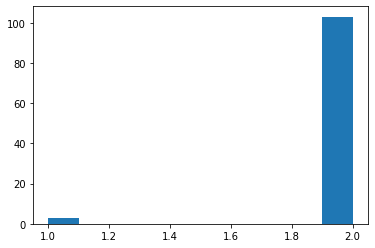

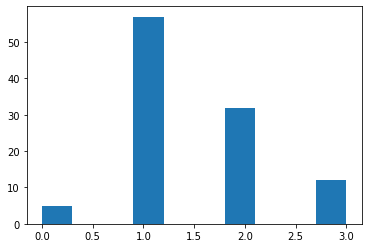

<Figure size 432x288 with 0 Axes>

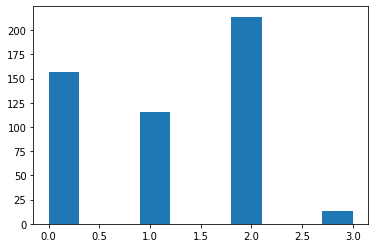

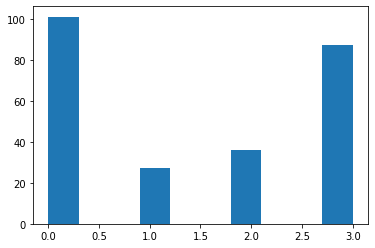

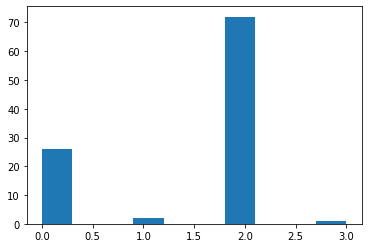

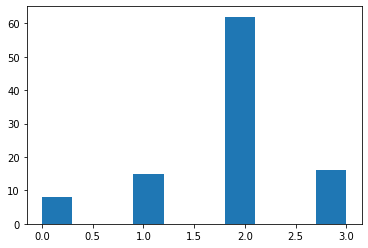

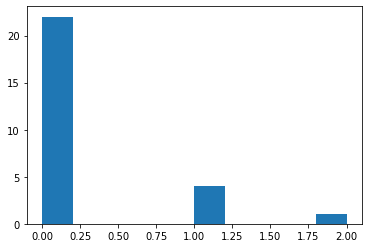

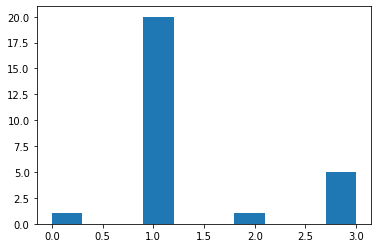

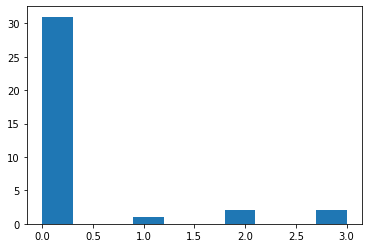

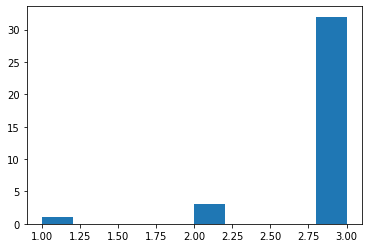

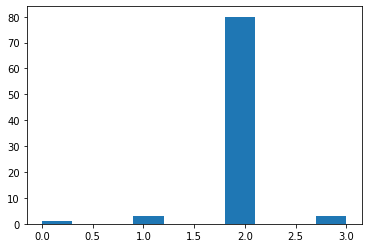

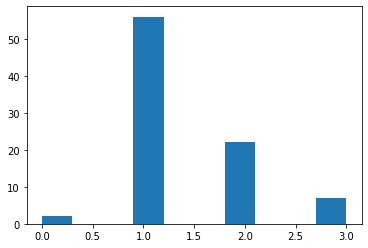

In [223]:
# Iterate the game
episodes =10000
a1_talk = []
a1_act = []
a2_talk = []
a2_act = []
who_talks_arr = []
inner_speech = []
scores1 = []
scores2 = []
last_action_1 = None
last_action_2 = None


for e in range(episodes):
    score1 = 0
    score2 = 0
    ag1_participate = 1
    ag2_participate = 1
    self_talk = random.random() < 0.5 # inner speach 50% of the time
    
    state1, state2, _, _, who_talks = env.step(0, 0, 0)
    # agent 1 talks
    if who_talks:
        if self_talk and last_action_1:
            state1_2, state1, reward1_2, reward1, who_talks = env.step(last_action_1[0], 4, 0) 
            action1 = agent1.act(state1)
            next_state1_2, next_state1, reward1_2, reward1, who_talks = env.step(last_action_1[1], action1[1], 1)     
            score1 += reward1
            ag2_participate = 0
            
        else:
            action1 = agent1.act(state1)
            state1, state2, reward1, reward2, who_talks = env.step(action1[0], 4, 0)  
            score1 += reward1
            action2 = agent2.act(state2) 
            last_action_1 = action1
        
            # everyone chooses
            next_state1, next_state2, reward1, reward2, who_talks = env.step(action1[1], action2[1], 1)     
            score1 += reward1
            score2 += reward2
    
    else:
        if self_talk and last_action_2:
            state2, state2_2, reward2, reward2_2, who_talks = env.step(4, last_action_2[0], 0) 
            action2 = agent2.act(state2)
            next_state2, next_state2_2, reward2, reward2_2, who_talks = env.step(action2[1], last_action_2[1], 1)     
            score2 += reward2
            ag1_participate = 0
        
        else:
            action2 = agent2.act(state2)
            state1, state2, reward1, reward2, who_talks = env.step(0, action2[0], 0)   
            score2 += reward2
            action1 = agent1.act(state1)
            last_action_2 = action2

        # everyone chooses
            next_state1, next_state2, reward1, reward2, who_talks = env.step(action1[1], action2[1], 1)     
            score1 += reward1
            score2 += reward2
    if ag2_participate:
        agent2.remember(state2, action2, reward2, next_state2)
    if ag1_participate:
        agent1.remember(state1, action1, reward1, next_state1)
        
    #if e > 1000:
    #    if score1 > 0.5: #won the game
    #        agent1.epsilon_min = 0
    #    else:
    #        agent1.epsilon_min = 0.1
    #   if score2 > 0.5: #won the game
    #        agent2.epsilon_min = 0
    #    else:
    #        agent2.epsilon_min = 0.1
        

    if e > 0 and e % 500 == 0:
        print("episode: {}/{}, score1: {}, score2: {}"
                  .format(e, episodes, score1, score2))
        scores1_arr = np.array(scores1[e-500:e])
        a1_talk_arr = np.array(a1_talk[e-500:e])
        a1_act_arr = np.array(a1_act[e-500:e])
        a2_talk_arr = np.array(a2_talk[e-500:e])
        a2_act_arr = np.array(a2_act[e-500:e])
        who_talks_arr_2 = np.array(who_talks_arr[e-500:e])
        plt.figure()
        plt.figure()
        plt.hist(a1_act_arr)
        plt.figure()
        plt.hist(a1_talk_arr[who_talks_arr_2==1])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 0])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 0])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 1])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 1])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 2])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 2])
        plt.figure()
        plt.hist(a1_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 3])
        plt.figure()
        plt.hist(a2_act_arr[who_talks_arr_2==1][a1_talk_arr[who_talks_arr_2==1] == 3])

    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        #if wins/loses < np.random.uniform(0,2):   
        agent1.replay(10)
        agent2.replay(10)
    
    inner_speech.append(self_talk)
    a1_talk.append(action1[0])
    a1_act.append(action1[1])
    a2_talk.append(action2[0])
    a2_act.append(action2[1])
    who_talks_arr.append(who_talks)
    scores1.append(score1)
    scores2.append(score2)

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

<Figure size 432x288 with 0 Axes>

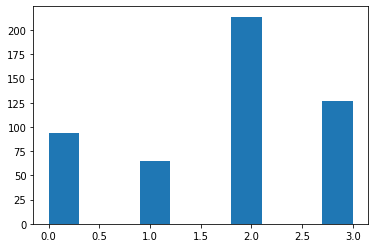

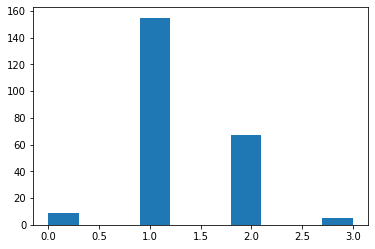

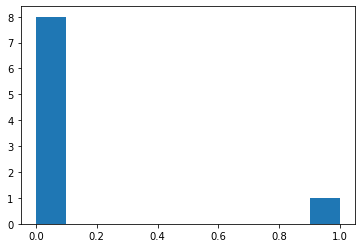

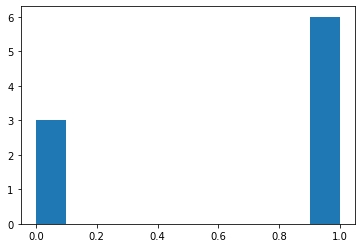

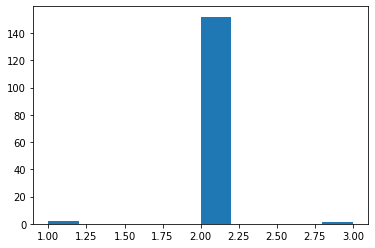

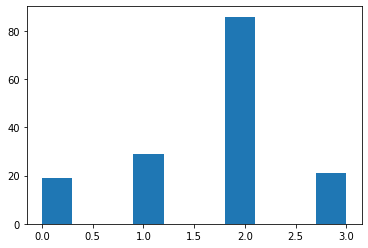

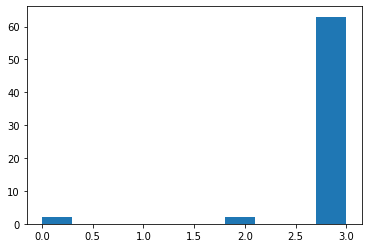

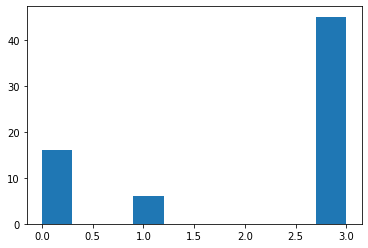

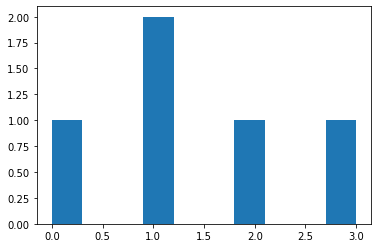

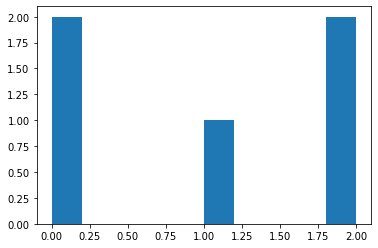

In [105]:
plt.figure()
plt.figure()
plt.hist(a2_act_arr[-1000:])
plt.figure()
plt.hist(a2_talk_arr[-1000:][who_talks_arr_2==0])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])

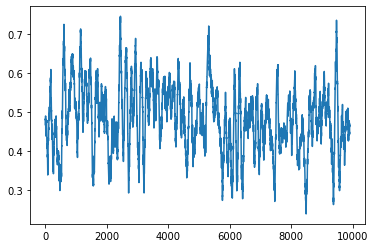

In [108]:
plt.plot(np.convolve(scores2, np.ones((100,))/100, mode='valid'))

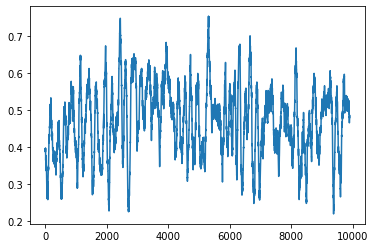

In [109]:
plt.plot(np.convolve(scores1, np.ones((100,))/100, mode='valid'))

## Many (>2) agents

In [225]:
class Two_Roles_Game_Many_Agents():

    def __init__(
        self, num_choices, winning_reward, mean_sample, talking_action_size, num_agents, punishment_weight = 2):
        self.num_choices = num_choices
        self.talking_action_size = talking_action_size
        self.winning_reward = winning_reward
        self.mean_sample = mean_sample
        previous_actions = []
        for i in range(num_agents):
            previous_actions.append(collections.deque(maxlen=mean_sample)) # for mean calculations
        self.previous_actions = previous_actions
        self.mean_punishment_weight = punishment_weight
        self.who_talks = int(random.random()>0.5) # needs to be updated after each game
                
    def step(self, ag1_action, ag2_action, choose, sample, reward1 = 0, reward2 = 0): #choose true or false
        #talker_input = np.zeros((self.talking_action_size+self.talking_action_size+1,)) # no noise
        #talker_input[1:self.talking_action_size+1] = np.random.random((self.talking_action_size,)) #UNIFORM/bimodal NOISE + signal for the game role
        talker_input = np.random.random((self.talking_action_size+1,)) #UNIFORM/bimodal NOISE + signal for the game role
        talker_input[0] = 1 # indicates that needs to talk
        #hearer_input = np.zeros((self.talking_action_size+self.talking_action_size+1,)) # no noise
        hearer_input = np.zeros((self.talking_action_size+1,))
        
        if choose: # step of choice
            self.previous_actions[sample[0]].append(ag1_action)
            self.previous_actions[sample[1]].append(ag2_action)
            a1_rew = 0
            a2_rew = 0
            
            if len(self.previous_actions[sample[0]]) > self.mean_sample-1 and len(self.previous_actions[sample[1]]) > self.mean_sample-1:
                a1_rew = ((1/self.num_choices) - self.previous_actions[sample[0]].count(ag1_action)/self.mean_sample) * self.mean_punishment_weight
                a2_rew = ((1/self.num_choices) - self.previous_actions[sample[1]].count(ag2_action)/self.mean_sample) * self.mean_punishment_weight
                
            if ag2_action == ag1_action: 
                reward1 = self.winning_reward + a1_rew
                reward2 = self.winning_reward + a2_rew
                
            else:
                reward1 = a1_rew #-1
                reward2 = a2_rew #-1
                                    
        else:       
            talker_action = ag1_action # first talks all the time
            hearer_input[talker_action+1] = 1
            
        
        return(talker_input, hearer_input, reward1, reward2)


In [264]:
num_choices = 4
num_talking_symbols = 4
winning_reward = 1
mean_sample = 100
punishment_weight = 3
num_agents = 2

agents = []
talks = []
acts = []
scores = []
samples = []
for i in range(num_agents):
    x = DQNAgent_student_teacher(num_talking_symbols, num_choices)
    agents.append(x)
    talks.append([])
    acts.append([])
    scores.append([])

In [265]:
env = Two_Roles_Game_Many_Agents(num_choices, winning_reward, mean_sample, num_talking_symbols, num_agents, punishment_weight) 

In [272]:
talks = []
acts = []
scores = []
samples = []
talks.append([])
acts.append([])
scores.append([])
talks.append([])
acts.append([])
scores.append([])

In [273]:
# Iterate the game
episodes = 30000

for e in range(episodes):
    my_sample = random.choices(range(num_agents), k=2) #random.sample(range(num_agents), 2) -> no replacement - no self-talks
    agent1 = agents[my_sample[0]]
    agent2 = agents[my_sample[1]]
    score1 = 0
    score2 = 0
    
    state1, state2, _, _ = env.step(0, 0, 0, my_sample) # 4 - doing nothing 

    # agent 1 talks
    action1 = agent1.act(state1)
    
    state1, state2, reward1, reward2 = env.step(action1[0], 0, 0, my_sample)     
    score1 += reward1
    
    action2 = agent2.act(state2)
    
    # everyone chooses
    next_state1, next_state2, reward1, reward2 = env.step(action1[1], action2[1], 1, my_sample)     
        
    score1 += reward1
    score2 += reward2
    
    agents[my_sample[1]].remember(state2, action2, reward2, next_state2)
    agents[my_sample[0]].remember(state1, action1, reward1, next_state1)
    
    if e %100 == 0:
        print("episode: {}/{}, score1: {}, score2: {}"
                      .format(e, episodes, score1, score2))
        
    if len(agent1.memory) > 10 and len(agent2.memory) > 10: 
        agents[my_sample[0]].replay(10)
        agents[my_sample[1]].replay(10)
    
    talks[my_sample[0]].append(action1[0])
    talks[my_sample[1]].append(action2[0])
    acts[my_sample[0]].append(action1[1])
    acts[my_sample[1]].append(action2[1])
    scores[my_sample[0]].append(score1)
    scores[my_sample[1]].append(score2)
    samples.append(my_sample)

episode: 0/30000, score1: -0.10999999999999988, score2: -0.10999999999999988
episode: 100/30000, score1: 0.58, score2: 1.24
episode: 200/30000, score1: 0.66, score2: -0.29999999999999993
episode: 300/30000, score1: 0.18999999999999995, score2: 0.18999999999999995
episode: 400/30000, score1: 0.58, score2: 0.58
episode: 500/30000, score1: 1.0, score2: 1.0
episode: 600/30000, score1: -0.26000000000000023, score2: -0.53
episode: 700/30000, score1: -0.4099999999999999, score2: -0.4099999999999999
episode: 800/30000, score1: -0.020000000000000018, score2: -0.14000000000000012
episode: 900/30000, score1: 1.12, score2: 1.12
episode: 1000/30000, score1: 0.3699999999999999, score2: 0.3699999999999999
episode: 1100/30000, score1: 0.63, score2: -1.0499999999999998
episode: 1200/30000, score1: 0.48, score2: 0.32999999999999996
episode: 1300/30000, score1: 0.7000000000000001, score2: 0.7000000000000001
episode: 1400/30000, score1: 0.5499999999999999, score2: 0.5499999999999999
episode: 1500/30000, s

episode: 13000/30000, score1: 1.06, score2: 1.06
episode: 13100/30000, score1: 0.73, score2: 0.73
episode: 13200/30000, score1: -0.5, score2: -0.4099999999999999
episode: 13300/30000, score1: 0.61, score2: 1.12
episode: 13400/30000, score1: 1.09, score2: 1.09
episode: 13500/30000, score1: 0.6000000000000001, score2: -1.1400000000000001
episode: 13600/30000, score1: 1.15, score2: 1.12
episode: 13700/30000, score1: 1.51, score2: 1.51
episode: 13800/30000, score1: 0.49, score2: 0.49
episode: 13900/30000, score1: 0.3400000000000001, score2: 0.3400000000000001
episode: 14000/30000, score1: 0.18999999999999995, score2: 0.49
episode: 14100/30000, score1: 1.3, score2: 1.3
episode: 14200/30000, score1: 0.30000000000000004, score2: 0.6000000000000001
episode: 14300/30000, score1: 0.45999999999999996, score2: 0.45999999999999996
episode: 14400/30000, score1: 0.94, score2: 1.3
episode: 14500/30000, score1: 0.73, score2: 0.73
episode: 14600/30000, score1: 0.97, score2: 0.28
episode: 14700/30000, sc

episode: 25900/30000, score1: 1.18, score2: 1.18
episode: 26000/30000, score1: 1.27, score2: 1.27
episode: 26100/30000, score1: 1.3900000000000001, score2: 1.3900000000000001
episode: 26200/30000, score1: -0.31999999999999984, score2: -0.31999999999999984
episode: 26300/30000, score1: -0.22999999999999998, score2: 0.3999999999999999
episode: 26400/30000, score1: 1.42, score2: 1.45
episode: 26500/30000, score1: 0.54, score2: 0.44999999999999996
episode: 26600/30000, score1: 0.7000000000000001, score2: 0.7000000000000001
episode: 26700/30000, score1: 1.06, score2: 0.45999999999999996
episode: 26800/30000, score1: 0.94, score2: 0.94
episode: 26900/30000, score1: 0.79, score2: 0.79
episode: 27000/30000, score1: 1.27, score2: 1.51
episode: 27100/30000, score1: 0.61, score2: 0.61
episode: 27200/30000, score1: 1.27, score2: 1.24
episode: 27300/30000, score1: 0.0, score2: 0.5700000000000001
episode: 27400/30000, score1: 0.9099999999999999, score2: 1.0
episode: 27500/30000, score1: 1.33, score2

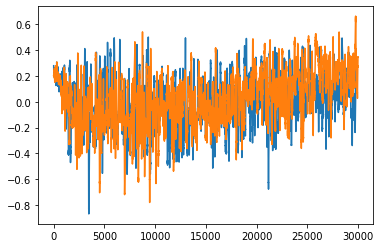

In [267]:
for i in range(num_agents):
    plt.plot(np.convolve(scores[i], np.ones((100,))/100, mode='valid'))

In [268]:
talks[1] = np.array(talks[1])
acts[1] = np.array(acts[1])
scores[1] = np.array(scores[1])
talks[0] = np.array(talks[0])
acts[0] = np.array(acts[0])
scores[0] = np.array(scores[0])

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(array([ 64.,   0.,   0., 344.,   0.,   0.,   9.,   0.,   0.,  66.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

<Figure size 432x288 with 0 Axes>

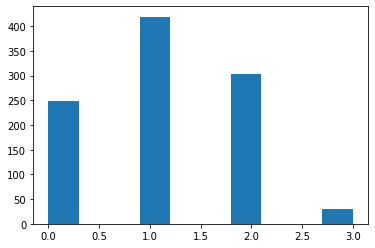

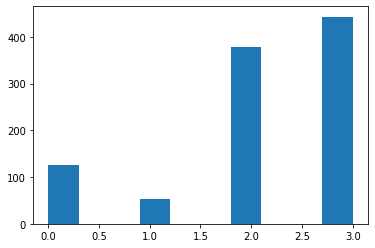

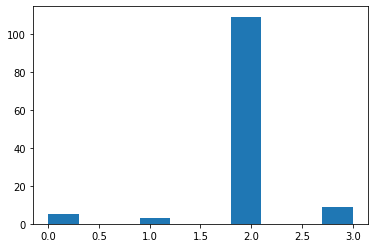

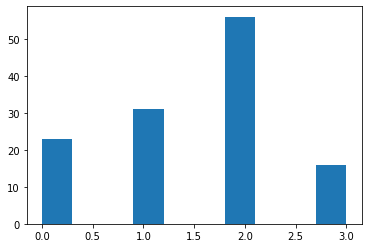

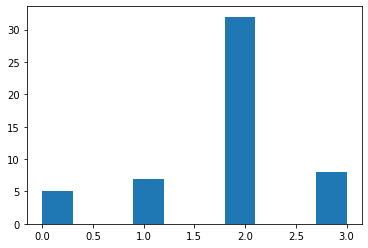

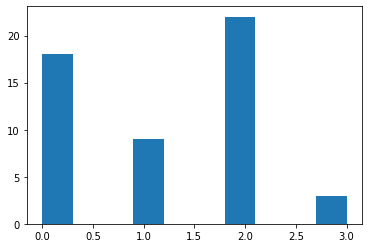

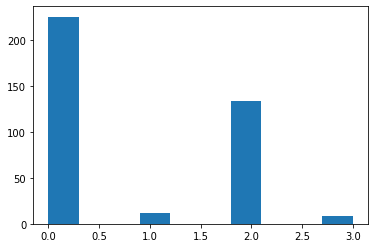

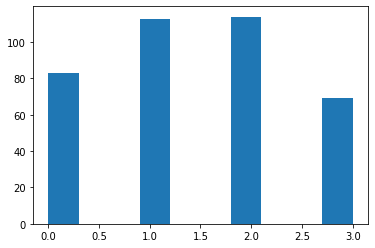

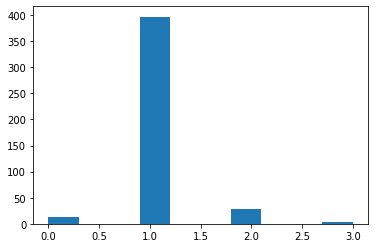

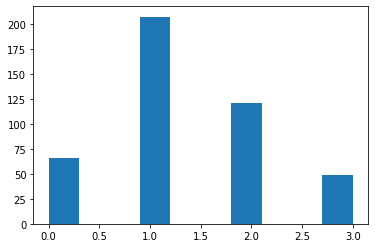

<Figure size 432x288 with 0 Axes>

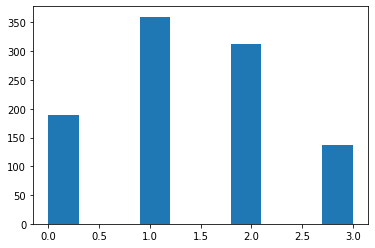

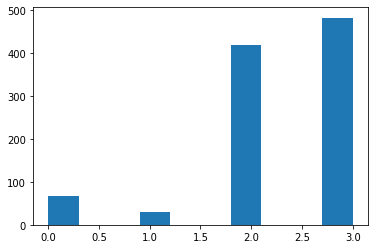

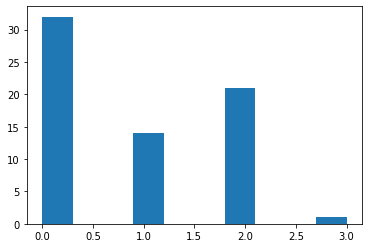

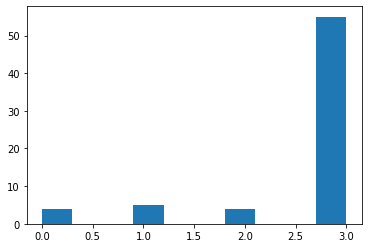

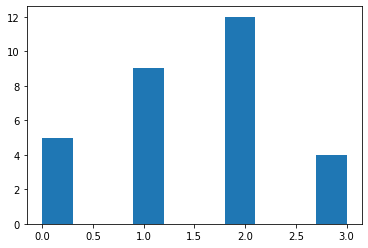

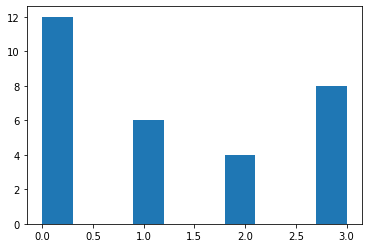

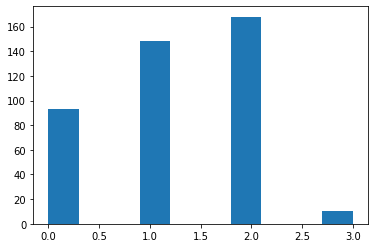

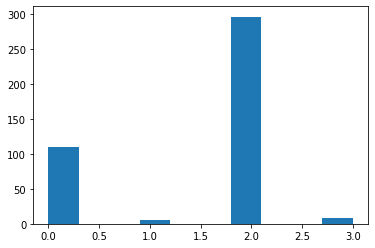

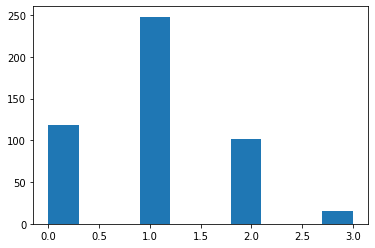

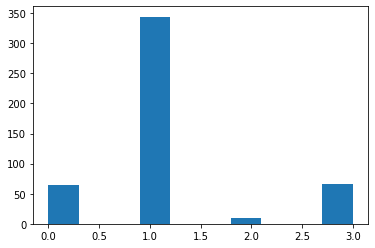

In [269]:
plt.figure()
plt.figure()
plt.hist(acts[0][-1000:])
plt.figure()
plt.hist(talks[0][-1000:])
plt.figure()
plt.hist(acts[0][-1000:][talks[0][-1000:] == 0])
plt.figure()
plt.hist(acts[1][-1000:][talks[0][-1000:] == 0])
plt.figure()
plt.hist(acts[0][-1000:][talks[0][-1000:] == 1])
plt.figure()
plt.hist(acts[1][-1000:][talks[0][-1000:] == 1])
plt.figure()
plt.hist(acts[0][-1000:][talks[0][-1000:] == 2])
plt.figure()
plt.hist(acts[1][-1000:][talks[0][-1000:] == 2])
plt.figure()
plt.hist(acts[0][-1000:][talks[0][-1000:] == 3])
plt.figure()
plt.hist(acts[1][-1000:][talks[0][-1000:] == 3])
plt.figure()

plt.figure()
plt.hist(acts[1][-1000:])
plt.figure()
plt.hist(talks[1][-1000:])
plt.figure()
plt.hist(acts[0][-1000:][talks[1][-1000:] == 0])
plt.figure()
plt.hist(acts[1][-1000:][talks[1][-1000:] == 0])
plt.figure()
plt.hist(acts[0][-1000:][talks[1][-1000:] == 1])
plt.figure()
plt.hist(acts[1][-1000:][talks[1][-1000:] == 1])
plt.figure()
plt.hist(acts[0][-1000:][talks[1][-1000:] == 2])
plt.figure()
plt.hist(acts[1][-1000:][talks[1][-1000:] == 2])
plt.figure()
plt.hist(acts[0][-1000:][talks[1][-1000:] == 3])
plt.figure()
plt.hist(acts[1][-1000:][talks[1][-1000:] == 3])

### Test different numbers of agents

In [296]:
def play_many_games(num_agents, num_episodes, inner_speech, learning_rate, punishment_weight, agents_memory, replay):
    num_choices = 4
    num_talking_symbols = 4
    winning_reward = 1
    mean_sample = 100
    punishment_weight = punishment_weight
    num_agents = num_agents
    
    env = Two_Roles_Game_Many_Agents(num_choices, winning_reward, mean_sample, num_talking_symbols, num_agents, punishment_weight) 

    agents = []
    talks = []
    acts = []
    scores = []
    samples = []
    for i in range(num_agents):
        x = DQNAgent_student_teacher(num_talking_symbols, num_choices, agents_memory)
        x.learning_rate_bad = learning_rate
        agents.append(x)
        talks.append([])
        acts.append([])
        scores.append([])
        
        # Iterate the game
    episodes = num_episodes

    for e in range(episodes):
        if inner_speech:
            my_sample = random.choices(range(num_agents), k=2) # with replacement
        else:    
            my_sample = random.sample(range(num_agents), 2) #no replacement - no self-talks
        agent1 = agents[my_sample[0]]
        agent2 = agents[my_sample[1]]
        score1 = 0
        score2 = 0

        state1, state2, _, _ = env.step(0, 0, 0, my_sample) # 4 - doing nothing 

        # agent 1 talks
        action1 = agent1.act(state1)

        state1, state2, reward1, reward2 = env.step(action1[0], 0, 0, my_sample)     
        score1 += reward1

        action2 = agent2.act(state2)

        # everyone chooses
        next_state1, next_state2, reward1, reward2 = env.step(action1[1], action2[1], 1, my_sample)     

        score1 += reward1
        score2 += reward2

        agents[my_sample[1]].remember(state2, action2, reward2, next_state2)
        agents[my_sample[0]].remember(state1, action1, reward1, next_state1)

        if e %100 == 0:
            print("episode: {}/{}, score1: {}, score2: {}"
                          .format(e, episodes, score1, score2))

        if len(agent1.memory) >= replay and len(agent2.memory) >= replay: 
            agents[my_sample[0]].replay(replay)
            agents[my_sample[1]].replay(replay)
        else:
            print("replay more than memory")

        talks[my_sample[0]].append(action1[0])
        talks[my_sample[1]].append(action2[0])
        acts[my_sample[0]].append(action1[1])
        acts[my_sample[1]].append(action2[1])
        scores[my_sample[0]].append(score1)
        scores[my_sample[1]].append(score2)
        samples.append(my_sample)
        
    return [agents, talks, acts, scores, samples]

In [ ]:
games = []
lrates = [0.00001,0.0001,0.001,0.01,0.1]
punishment_weight = [2, 2.5, 3]
memory_replay = [[1,2,5,5,10,10,50,50,100,100,100],[1,2,1,5,5,10,10,50,1,50,100]]
conditions = []
for lr in lrates:
    for punish in punishment_weight:
        for i in range(len(memory_replay[0])):
            print("lr: {}, punishment_weight: {}, memory: {}, replay = {}".format(lr, punish, memory_replay[0][i], memory_replay[1][i]))
            d = play_many_games(2, 50000, 1, lr, punish, memory_replay[0][i], memory_replay[1][i])
            games.append(d)
            plt.figure()
            for j in range(2):
                plt.plot(np.convolve(d[3][j], np.ones((100,))/100, mode='valid'))
    

lr: 1e-05, punishment_weight: 2, memory: 1, replay = 1
episode: 0/50000, score1: 0, score2: 0
episode: 100/50000, score1: -0.07999999999999996, score2: 0.06
episode: 200/50000, score1: 0.94, score2: 0.94
episode: 300/50000, score1: 0.94, score2: 0.66
episode: 400/50000, score1: 0.5, score2: 0.84
episode: 500/50000, score1: -0.31999999999999995, score2: -0.6200000000000001
episode: 600/50000, score1: 0.3400000000000001, score2: 0.3400000000000001
episode: 700/50000, score1: 0.09999999999999998, score2: 0.18
episode: 800/50000, score1: -0.06000000000000005, score2: -0.8600000000000001
episode: 900/50000, score1: -0.06000000000000005, score2: 0.14
episode: 1000/50000, score1: -0.5, score2: 0.03999999999999998
episode: 1100/50000, score1: 0.68, score2: 0.68
episode: 1200/50000, score1: -0.6599999999999999, score2: 0.44
episode: 1300/50000, score1: -0.07999999999999996, score2: -0.5
episode: 1400/50000, score1: -0.33999999999999997, score2: -0.26
episode: 1500/50000, score1: 0.2, score2: -0

episode: 13100/50000, score1: -0.08000000000000007, score2: -0.040000000000000036
episode: 13200/50000, score1: -0.26, score2: 0.86
episode: 13300/50000, score1: 0.08000000000000002, score2: -0.28
episode: 13400/50000, score1: 0.76, score2: 0.76
episode: 13500/50000, score1: 0.56, score2: 0.17999999999999994
episode: 13600/50000, score1: 1.18, score2: 1.18
episode: 13700/50000, score1: -0.1399999999999999, score2: -0.1399999999999999
episode: 13800/50000, score1: -0.33999999999999997, score2: -0.56
episode: 13900/50000, score1: 0.28, score2: -1.08
episode: 14000/50000, score1: 0.56, score2: 0.56
episode: 14100/50000, score1: 0.94, score2: 1.1400000000000001
episode: 14200/50000, score1: -0.21999999999999997, score2: -0.21999999999999997
episode: 14300/50000, score1: 0.46, score2: -0.020000000000000018
episode: 14400/50000, score1: 1.24, score2: 1.24
episode: 14500/50000, score1: 0.040000000000000036, score2: -0.21999999999999997
episode: 14600/50000, score1: 0.84, score2: 0.84
episode:

episode: 26800/50000, score1: 0.2, score2: 0.18
episode: 26900/50000, score1: 0.52, score2: 0.3400000000000001
episode: 27000/50000, score1: -0.020000000000000018, score2: -0.09999999999999998
episode: 27100/50000, score1: 0.3999999999999999, score2: 0.3999999999999999
episode: 27200/50000, score1: 0.62, score2: 0.7
episode: 27300/50000, score1: 1.4, score2: 1.18
episode: 27400/50000, score1: -0.020000000000000018, score2: 0.0
episode: 27500/50000, score1: -0.76, score2: 0.36
episode: 27600/50000, score1: 0.43999999999999995, score2: 0.78
episode: 27700/50000, score1: 0.3799999999999999, score2: 0.3799999999999999
episode: 27800/50000, score1: 1.06, score2: 1.06
episode: 27900/50000, score1: 1.0, score2: 0.78
episode: 28000/50000, score1: 0.26, score2: 0.26
episode: 28100/50000, score1: 0.2, score2: -0.16000000000000003
episode: 28200/50000, score1: -0.28, score2: 0.33999999999999997
episode: 28300/50000, score1: 0.72, score2: 1.16
episode: 28400/50000, score1: 1.1, score2: 1.24
episod

episode: 41000/50000, score1: 0.26, score2: -0.6399999999999999
episode: 41100/50000, score1: 1.08, score2: 1.08
episode: 41200/50000, score1: 0.72, score2: 0.72
episode: 41300/50000, score1: 0.9, score2: 0.9
episode: 41400/50000, score1: 0.06, score2: 0.08000000000000002
episode: 41500/50000, score1: 0.82, score2: 0.76
episode: 41600/50000, score1: 0.38, score2: -0.33999999999999997
episode: 41700/50000, score1: 0.8, score2: 1.0
episode: 41800/50000, score1: 0.78, score2: 0.78
episode: 41900/50000, score1: 0.86, score2: 0.62
episode: 42000/50000, score1: 0.84, score2: 0.84
episode: 42100/50000, score1: 0.5, score2: 0.88
episode: 42200/50000, score1: 0.54, score2: 0.54
episode: 42300/50000, score1: 0.76, score2: 0.9
episode: 42400/50000, score1: 1.06, score2: 0.66
episode: 42500/50000, score1: 0.76, score2: 0.72
episode: 42600/50000, score1: -0.36, score2: 0.03999999999999998
episode: 42700/50000, score1: 0.94, score2: 0.94
episode: 42800/50000, score1: 0.66, score2: 0.66
episode: 4290

episode: 5400/50000, score1: -0.28, score2: 0.98
episode: 5500/50000, score1: -0.9199999999999999, score2: -0.12
episode: 5600/50000, score1: 0.30000000000000004, score2: 0.06000000000000005
episode: 5700/50000, score1: 0.56, score2: 0.56
episode: 5800/50000, score1: -0.1200000000000001, score2: -0.10000000000000009
episode: 5900/50000, score1: 0.0, score2: 0.06000000000000005
episode: 6000/50000, score1: -0.8200000000000001, score2: 0.26
episode: 6100/50000, score1: -0.08000000000000007, score2: -0.3400000000000001
episode: 6200/50000, score1: 0.68, score2: 0.68
episode: 6300/50000, score1: 0.43999999999999995, score2: 0.21999999999999997
episode: 6400/50000, score1: 0.06, score2: 0.08000000000000002
episode: 6500/50000, score1: 0.46, score2: -0.54
episode: 6600/50000, score1: 0.17999999999999994, score2: 0.17999999999999994
episode: 6700/50000, score1: 0.08000000000000007, score2: 0.3799999999999999
episode: 6800/50000, score1: 0.54, score2: 0.54
episode: 6900/50000, score1: -0.06000

episode: 18400/50000, score1: 1.06, score2: 0.96
episode: 18500/50000, score1: 1.3599999999999999, score2: 1.3599999999999999
episode: 18600/50000, score1: 0.94, score2: 0.94
episode: 18700/50000, score1: 0.86, score2: 0.86
episode: 18800/50000, score1: 0.4, score2: -0.48
episode: 18900/50000, score1: 0.10000000000000009, score2: 0.62
episode: 19000/50000, score1: 0.88, score2: 0.88
episode: 19100/50000, score1: 1.08, score2: 1.08
episode: 19200/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 19300/50000, score1: 0.15999999999999992, score2: 1.1400000000000001
episode: 19400/50000, score1: 0.17999999999999994, score2: 0.88
episode: 19500/50000, score1: 0.9, score2: 1.02
episode: 19600/50000, score1: -0.06000000000000005, score2: -0.06000000000000005
episode: 19700/50000, score1: -0.54, score2: 0.020000000000000018
episode: 19800/50000, score1: 0.33999999999999997, score2: -0.30000000000000004
episode: 19900/50000, score1: 0.78, score2: 0.78
episode: 20000/50000

episode: 32600/50000, score1: 0.84, score2: 1.18
episode: 32700/50000, score1: 0.020000000000000018, score2: 0.28
episode: 32800/50000, score1: 1.0, score2: 1.0
episode: 32900/50000, score1: 0.72, score2: 0.72
episode: 33000/50000, score1: 0.12, score2: -0.19999999999999996
episode: 33100/50000, score1: 0.56, score2: 1.1400000000000001
episode: 33200/50000, score1: -0.45999999999999996, score2: 0.2
episode: 33300/50000, score1: -0.31999999999999995, score2: 0.18
episode: 33400/50000, score1: 0.28, score2: 0.28
episode: 33500/50000, score1: 1.1400000000000001, score2: 1.1400000000000001
episode: 33600/50000, score1: 0.26, score2: 0.26
episode: 33700/50000, score1: 1.08, score2: 1.08
episode: 33800/50000, score1: 0.96, score2: 0.96
episode: 33900/50000, score1: 0.72, score2: 0.72
episode: 34000/50000, score1: 0.78, score2: 0.78
episode: 34100/50000, score1: 0.43999999999999995, score2: 0.74
episode: 34200/50000, score1: 0.8, score2: 0.8
episode: 34300/50000, score1: 0.3799999999999999, s

episode: 47900/50000, score1: 0.78, score2: 0.78
episode: 48000/50000, score1: 0.5, score2: 0.5
episode: 48100/50000, score1: 0.74, score2: 0.9
episode: 48200/50000, score1: 0.78, score2: 0.78
episode: 48300/50000, score1: 0.6, score2: 0.6
episode: 48400/50000, score1: 0.94, score2: 0.88
episode: 48500/50000, score1: 0.56, score2: 0.56
episode: 48600/50000, score1: 0.86, score2: 0.86
episode: 48700/50000, score1: 1.22, score2: 1.22
episode: 48800/50000, score1: 0.66, score2: 0.6
episode: 48900/50000, score1: 0.44, score2: -0.12
episode: 49000/50000, score1: 0.88, score2: 0.84
episode: 49100/50000, score1: 0.78, score2: 0.78
episode: 49200/50000, score1: 1.06, score2: 0.7
episode: 49300/50000, score1: -0.33999999999999997, score2: -0.24
episode: 49400/50000, score1: 0.92, score2: 1.06
episode: 49500/50000, score1: 1.04, score2: 0.9
episode: 49600/50000, score1: 1.08, score2: 1.08
episode: 49700/50000, score1: 0.58, score2: 0.86
episode: 49800/50000, score1: 0.88, score2: 1.0
episode: 49

episode: 11500/50000, score1: 1.08, score2: 1.08
episode: 11600/50000, score1: -0.26, score2: -0.26
episode: 11700/50000, score1: 1.16, score2: 0.96
episode: 11800/50000, score1: -0.06000000000000005, score2: -0.30000000000000004
episode: 11900/50000, score1: 0.06000000000000005, score2: 0.06000000000000005
episode: 12000/50000, score1: 0.21999999999999997, score2: -0.38
episode: 12100/50000, score1: 0.3400000000000001, score2: 1.42
episode: 12200/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 12300/50000, score1: 0.0, score2: 0.74
episode: 12400/50000, score1: -0.76, score2: -0.09999999999999998
episode: 12500/50000, score1: 0.1399999999999999, score2: 0.06000000000000005
episode: 12600/50000, score1: 0.24, score2: 0.24
episode: 12700/50000, score1: 0.040000000000000036, score2: 0.52
episode: 12800/50000, score1: 0.52, score2: 0.3400000000000001
episode: 12900/50000, score1: -0.040000000000000036, score2: 0.020000000000000018
episode: 13000/50000, score1: -0.

episode: 24900/50000, score1: 0.1399999999999999, score2: 0.1200000000000001
episode: 25000/50000, score1: 0.98, score2: 0.98
episode: 25100/50000, score1: 1.4, score2: 1.4
episode: 25200/50000, score1: 0.3799999999999999, score2: 0.41999999999999993
episode: 25300/50000, score1: 0.26, score2: 0.26
episode: 25400/50000, score1: 0.3999999999999999, score2: 0.41999999999999993
episode: 25500/50000, score1: 0.54, score2: 1.22
episode: 25600/50000, score1: 0.06000000000000005, score2: 0.41999999999999993
episode: 25700/50000, score1: 0.7, score2: 0.7
episode: 25800/50000, score1: 0.44, score2: -0.12
episode: 25900/50000, score1: -0.6799999999999999, score2: 0.32
episode: 26000/50000, score1: -0.07999999999999996, score2: 0.33999999999999997
episode: 26100/50000, score1: 0.68, score2: 0.68
episode: 26200/50000, score1: 0.3799999999999999, score2: 0.3799999999999999
episode: 26300/50000, score1: 0.3600000000000001, score2: 0.3999999999999999
episode: 26400/50000, score1: -0.6200000000000001,

episode: 39200/50000, score1: 0.94, score2: 0.94
episode: 39300/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 39400/50000, score1: 0.52, score2: 0.72
episode: 39500/50000, score1: 1.08, score2: 1.08
episode: 39600/50000, score1: 0.30000000000000004, score2: 0.30000000000000004
episode: 39700/50000, score1: 0.68, score2: 0.62
episode: 39800/50000, score1: 1.0, score2: 1.02
episode: 39900/50000, score1: 1.1400000000000001, score2: 1.1400000000000001
episode: 40000/50000, score1: 0.9, score2: 0.9
episode: 40100/50000, score1: 0.86, score2: 0.86
episode: 40200/50000, score1: 0.94, score2: 1.1400000000000001
episode: 40300/50000, score1: 0.96, score2: 0.96
episode: 40400/50000, score1: 0.7, score2: 0.7
episode: 40500/50000, score1: 0.92, score2: 0.78
episode: 40600/50000, score1: 1.1, score2: 1.1
episode: 40700/50000, score1: 0.92, score2: 0.92
episode: 40800/50000, score1: 1.16, score2: 1.16
episode: 40900/50000, score1: -0.040000000000000036, score2: -0.16000000

episode: 3600/50000, score1: -1.2, score2: -0.040000000000000036
episode: 3700/50000, score1: -0.28, score2: -0.21999999999999997
episode: 3800/50000, score1: -0.24, score2: -1.04
episode: 3900/50000, score1: -0.4, score2: 0.0
episode: 4000/50000, score1: 0.020000000000000018, score2: -0.7
episode: 4100/50000, score1: 0.32000000000000006, score2: -0.26
episode: 4200/50000, score1: 0.45999999999999996, score2: 1.42
episode: 4300/50000, score1: -0.14, score2: -0.09999999999999998
episode: 4400/50000, score1: 1.24, score2: 1.24
episode: 4500/50000, score1: 0.03999999999999998, score2: 0.36
episode: 4600/50000, score1: 1.18, score2: 1.18
episode: 4700/50000, score1: -1.26, score2: 0.12
episode: 4800/50000, score1: 0.45999999999999996, score2: 0.45999999999999996
episode: 4900/50000, score1: 1.2, score2: 1.2
episode: 5000/50000, score1: 0.2, score2: -1.18
episode: 5100/50000, score1: 0.24, score2: 0.41999999999999993
episode: 5200/50000, score1: -0.06000000000000005, score2: 0.0200000000000

episode: 17100/50000, score1: 0.43999999999999995, score2: 0.94
episode: 17200/50000, score1: 0.7, score2: 0.7
episode: 17300/50000, score1: 0.66, score2: 0.52
episode: 17400/50000, score1: 0.92, score2: 0.92
episode: 17500/50000, score1: 0.42, score2: -1.14
episode: 17600/50000, score1: 0.4, score2: -0.8600000000000001
episode: 17700/50000, score1: 0.56, score2: 0.74
episode: 17800/50000, score1: 0.33999999999999997, score2: 0.12
episode: 17900/50000, score1: -0.6399999999999999, score2: -0.06000000000000005
episode: 18000/50000, score1: -0.12, score2: 0.46
episode: 18100/50000, score1: 0.48, score2: 0.94
episode: 18200/50000, score1: -0.24, score2: 0.4
episode: 18300/50000, score1: 0.58, score2: 0.58
episode: 18400/50000, score1: 0.6, score2: 0.24
episode: 18500/50000, score1: 0.5, score2: 0.5
episode: 18600/50000, score1: -0.06000000000000005, score2: 0.26
episode: 18700/50000, score1: 0.64, score2: 0.64
episode: 18800/50000, score1: -0.6399999999999999, score2: 0.3
episode: 18900/5

episode: 31800/50000, score1: -0.36, score2: 0.42
episode: 31900/50000, score1: 0.66, score2: 0.66
episode: 32000/50000, score1: 0.6, score2: 0.6
episode: 32100/50000, score1: 1.16, score2: 1.16
episode: 32200/50000, score1: 1.16, score2: 1.32
episode: 32300/50000, score1: 0.96, score2: 1.16
episode: 32400/50000, score1: 1.04, score2: 0.86
episode: 32500/50000, score1: 0.86, score2: 0.86
episode: 32600/50000, score1: 0.9, score2: 0.96
episode: 32700/50000, score1: 1.16, score2: 1.16
episode: 32800/50000, score1: 0.82, score2: 0.82
episode: 32900/50000, score1: 1.0, score2: 1.2
episode: 33000/50000, score1: 0.43999999999999995, score2: 0.54
episode: 33100/50000, score1: 1.0, score2: 1.0
episode: 33200/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 33300/50000, score1: 0.14, score2: -0.48
episode: 33400/50000, score1: 1.1, score2: 1.1
episode: 33500/50000, score1: 0.30000000000000004, score2: 0.30000000000000004
episode: 33600/50000, score1: 0.58, score2: 0.74
e

episode: 47300/50000, score1: 1.12, score2: 1.12
episode: 47400/50000, score1: 1.02, score2: 1.02
episode: 47500/50000, score1: 1.3, score2: 1.3
episode: 47600/50000, score1: 0.26, score2: -0.18000000000000005
episode: 47700/50000, score1: 0.9, score2: 0.86
episode: 47800/50000, score1: 0.7, score2: 0.7
episode: 47900/50000, score1: 0.3999999999999999, score2: 0.5
episode: 48000/50000, score1: 1.0, score2: 1.1400000000000001
episode: 48100/50000, score1: 0.3600000000000001, score2: 0.3600000000000001
episode: 48200/50000, score1: 0.62, score2: 1.12
episode: 48300/50000, score1: 0.28, score2: -0.30000000000000004
episode: 48400/50000, score1: 1.06, score2: 1.06
episode: 48500/50000, score1: -0.30000000000000004, score2: -0.28
episode: 48600/50000, score1: 0.28, score2: -0.36
episode: 48700/50000, score1: 0.74, score2: 0.74
episode: 48800/50000, score1: 1.22, score2: 1.22
episode: 48900/50000, score1: 0.92, score2: 0.92
episode: 49000/50000, score1: 0.78, score2: 1.1
episode: 49100/50000

episode: 10600/50000, score1: 0.040000000000000036, score2: 0.040000000000000036
episode: 10700/50000, score1: 0.36, score2: -0.26
episode: 10800/50000, score1: 0.06, score2: -0.43999999999999995
episode: 10900/50000, score1: -0.8200000000000001, score2: -0.4
episode: 11000/50000, score1: 0.88, score2: 0.96
episode: 11100/50000, score1: -0.24, score2: -0.21999999999999997
episode: 11200/50000, score1: 0.6, score2: 0.6
episode: 11300/50000, score1: 1.02, score2: 1.02
episode: 11400/50000, score1: -0.14, score2: -0.33999999999999997
episode: 11500/50000, score1: 0.33999999999999997, score2: -0.26
episode: 11600/50000, score1: 0.15999999999999998, score2: 0.24
episode: 11700/50000, score1: 0.66, score2: 0.66
episode: 11800/50000, score1: 0.41999999999999993, score2: 0.68
episode: 11900/50000, score1: -0.040000000000000036, score2: -0.040000000000000036
episode: 12000/50000, score1: -0.96, score2: 0.46
episode: 12100/50000, score1: -0.6200000000000001, score2: -0.24
episode: 12200/50000, s

episode: 23600/50000, score1: 0.3600000000000001, score2: 0.3799999999999999
episode: 23700/50000, score1: 0.26, score2: 0.21999999999999997
episode: 23800/50000, score1: 1.16, score2: 0.1200000000000001
episode: 23900/50000, score1: 1.1, score2: 0.56
episode: 24000/50000, score1: 1.1400000000000001, score2: 1.1400000000000001
episode: 24100/50000, score1: -0.31999999999999995, score2: -0.52
episode: 24200/50000, score1: -0.12, score2: -0.38
episode: 24300/50000, score1: 0.32000000000000006, score2: 0.88
episode: 24400/50000, score1: 0.17999999999999994, score2: 0.17999999999999994
episode: 24500/50000, score1: 0.06000000000000005, score2: 0.17999999999999994
episode: 24600/50000, score1: 0.24, score2: 0.24
episode: 24700/50000, score1: 0.98, score2: 0.98
episode: 24800/50000, score1: -0.06000000000000005, score2: -0.17999999999999994
episode: 24900/50000, score1: 0.040000000000000036, score2: 0.040000000000000036
episode: 25000/50000, score1: 0.54, score2: 0.54
episode: 25100/50000, s

episode: 37100/50000, score1: 0.32000000000000006, score2: 0.24
episode: 37200/50000, score1: 0.5, score2: 0.6
episode: 37300/50000, score1: 0.44, score2: -0.14
episode: 37400/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 37500/50000, score1: 0.94, score2: 0.94
episode: 37600/50000, score1: 0.32000000000000006, score2: 0.19999999999999996
episode: 37700/50000, score1: 0.33999999999999997, score2: -0.38
episode: 37800/50000, score1: 1.28, score2: 1.28
episode: 37900/50000, score1: -0.06000000000000005, score2: 0.06000000000000005
episode: 38000/50000, score1: -0.1200000000000001, score2: -0.1200000000000001
episode: 38100/50000, score1: 0.19999999999999996, score2: 0.19999999999999996
episode: 38200/50000, score1: 0.6, score2: 0.6
episode: 38300/50000, score1: 1.16, score2: 1.16
episode: 38400/50000, score1: 0.020000000000000018, score2: 0.0
episode: 38500/50000, score1: -0.6599999999999999, score2: -0.24
episode: 38600/50000, score1: 0.8, score2: 0.68
episode

episode: 300/50000, score1: 1.12, score2: 1.12
episode: 400/50000, score1: 0.15999999999999998, score2: -0.5
episode: 500/50000, score1: -0.14, score2: 0.15999999999999998
episode: 600/50000, score1: 0.54, score2: 0.54
episode: 700/50000, score1: 0.8, score2: 0.8
episode: 800/50000, score1: 0.14, score2: -0.43999999999999995
episode: 900/50000, score1: -0.4, score2: 0.28
episode: 1000/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 1100/50000, score1: -0.94, score2: 0.32
episode: 1200/50000, score1: 0.26, score2: -0.19999999999999996
episode: 1300/50000, score1: 0.4, score2: 0.09999999999999998
episode: 1400/50000, score1: -0.4, score2: -0.30000000000000004
episode: 1500/50000, score1: 0.10000000000000009, score2: 0.10000000000000009
episode: 1600/50000, score1: 0.5, score2: 0.5
episode: 1700/50000, score1: -0.14, score2: 0.06
episode: 1800/50000, score1: 0.32, score2: 0.21999999999999997
episode: 1900/50000, score1: -0.06000000000000005, score2: 0.32
episode: 

episode: 13400/50000, score1: -0.040000000000000036, score2: -0.040000000000000036
episode: 13500/50000, score1: -0.4, score2: -0.040000000000000036
episode: 13600/50000, score1: -0.08000000000000007, score2: 0.3400000000000001
episode: 13700/50000, score1: 0.84, score2: 0.24
episode: 13800/50000, score1: 0.14, score2: 0.24
episode: 13900/50000, score1: 0.06000000000000005, score2: 0.3400000000000001
episode: 14000/50000, score1: 1.12, score2: 1.3
episode: 14100/50000, score1: 1.08, score2: 1.08
episode: 14200/50000, score1: -0.040000000000000036, score2: -0.28
episode: 14300/50000, score1: 0.09999999999999998, score2: 0.2
episode: 14400/50000, score1: 0.8, score2: 0.8
episode: 14500/50000, score1: 0.78, score2: 0.17999999999999994
episode: 14600/50000, score1: 1.2, score2: 1.42
episode: 14700/50000, score1: -0.21999999999999997, score2: 0.3
episode: 14800/50000, score1: -0.020000000000000018, score2: -0.10000000000000009
episode: 14900/50000, score1: 0.6, score2: 0.6
episode: 15000/50

episode: 26700/50000, score1: 0.30000000000000004, score2: 0.30000000000000004
episode: 26800/50000, score1: 0.24, score2: 0.24
episode: 26900/50000, score1: 0.94, score2: 0.94
episode: 27000/50000, score1: 0.98, score2: 0.96
episode: 27100/50000, score1: 1.1400000000000001, score2: 1.1400000000000001
episode: 27200/50000, score1: 0.58, score2: 0.58
episode: 27300/50000, score1: 0.78, score2: 0.9
episode: 27400/50000, score1: 0.28, score2: 0.28
episode: 27500/50000, score1: 0.17999999999999994, score2: 0.54
episode: 27600/50000, score1: 0.44, score2: 0.020000000000000018
episode: 27700/50000, score1: -0.52, score2: -0.42000000000000004
episode: 27800/50000, score1: 1.2, score2: 1.2
episode: 27900/50000, score1: 0.6, score2: 0.74
episode: 28000/50000, score1: 0.74, score2: 0.74
episode: 28100/50000, score1: 0.86, score2: 0.86
episode: 28200/50000, score1: 0.72, score2: 0.72
episode: 28300/50000, score1: 0.44, score2: -0.09999999999999998
episode: 28400/50000, score1: 1.2, score2: 1.18
e

episode: 41500/50000, score1: 0.7, score2: 1.16
episode: 41600/50000, score1: 0.58, score2: 0.58
episode: 41700/50000, score1: 0.74, score2: 0.66
episode: 41800/50000, score1: 1.06, score2: 0.72
episode: 41900/50000, score1: 0.92, score2: 0.92
episode: 42000/50000, score1: 0.48, score2: 1.16
episode: 42100/50000, score1: 0.76, score2: 0.76
episode: 42200/50000, score1: 1.1400000000000001, score2: 1.1400000000000001
episode: 42300/50000, score1: 0.74, score2: 0.94
episode: 42400/50000, score1: 0.76, score2: 0.76
episode: 42500/50000, score1: 0.8, score2: 0.84
episode: 42600/50000, score1: 0.3799999999999999, score2: 0.43999999999999995
episode: 42700/50000, score1: -0.8200000000000001, score2: -0.07999999999999996
episode: 42800/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 42900/50000, score1: 1.1, score2: 1.1
episode: 43000/50000, score1: 0.19999999999999996, score2: 0.19999999999999996
episode: 43100/50000, score1: 0.45999999999999996, score2: 0.74
episode:

episode: 5000/50000, score1: 0.44, score2: -1.36
episode: 5100/50000, score1: 0.78, score2: 0.78
episode: 5200/50000, score1: -0.21999999999999997, score2: 0.09999999999999998
episode: 5300/50000, score1: -0.5800000000000001, score2: -1.18
episode: 5400/50000, score1: -0.72, score2: 0.48
episode: 5500/50000, score1: 1.28, score2: 0.88
episode: 5600/50000, score1: -0.30000000000000004, score2: -0.30000000000000004
episode: 5700/50000, score1: -0.24, score2: -0.26
episode: 5800/50000, score1: -0.45999999999999996, score2: 0.0
episode: 5900/50000, score1: -1.12, score2: 0.4
episode: 6000/50000, score1: 0.42, score2: -1.26
episode: 6100/50000, score1: -1.08, score2: -0.43999999999999995
episode: 6200/50000, score1: 0.020000000000000018, score2: 0.38
episode: 6300/50000, score1: 0.06, score2: -0.8400000000000001
episode: 6400/50000, score1: -0.30000000000000004, score2: -0.30000000000000004
episode: 6500/50000, score1: 1.48, score2: 0.30000000000000004
episode: 6600/50000, score1: -0.399999

episode: 18300/50000, score1: 0.66, score2: 0.020000000000000018
episode: 18400/50000, score1: 0.26, score2: -0.3999999999999999
episode: 18500/50000, score1: 0.17999999999999994, score2: 0.17999999999999994
episode: 18600/50000, score1: 0.020000000000000018, score2: 0.020000000000000018
episode: 18700/50000, score1: -0.3799999999999999, score2: -0.3799999999999999
episode: 18800/50000, score1: 0.18, score2: -0.7
episode: 18900/50000, score1: -0.5800000000000001, score2: -0.96
episode: 19000/50000, score1: 0.1200000000000001, score2: 0.8
episode: 19100/50000, score1: 0.19999999999999996, score2: 0.48
episode: 19200/50000, score1: 0.040000000000000036, score2: 0.06000000000000005
episode: 19300/50000, score1: -0.1399999999999999, score2: -0.1399999999999999
episode: 19400/50000, score1: -0.1200000000000001, score2: -0.24
episode: 19500/50000, score1: 0.21999999999999997, score2: -0.45999999999999996
episode: 19600/50000, score1: 0.24, score2: 0.24
episode: 19700/50000, score1: 0.3200000

episode: 31500/50000, score1: 0.30000000000000004, score2: 0.30000000000000004
episode: 31600/50000, score1: 0.19999999999999996, score2: 1.04
episode: 31700/50000, score1: 0.48, score2: 0.54
episode: 31800/50000, score1: -0.21999999999999997, score2: 0.43999999999999995
episode: 31900/50000, score1: 0.32000000000000006, score2: 0.8
episode: 32000/50000, score1: 0.76, score2: 1.04
episode: 32100/50000, score1: 0.98, score2: 0.98
episode: 32200/50000, score1: 1.16, score2: 1.16
episode: 32300/50000, score1: -0.12, score2: -0.36
episode: 32400/50000, score1: 0.020000000000000018, score2: 0.020000000000000018
episode: 32500/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 32600/50000, score1: 1.2, score2: 1.2
episode: 32700/50000, score1: 0.58, score2: 0.58
episode: 32800/50000, score1: 0.86, score2: 0.86
episode: 32900/50000, score1: 0.88, score2: 0.78
episode: 33000/50000, score1: 0.32, score2: -0.8600000000000001
episode: 33100/50000, score1: 0.6, score2: 0.24
e

episode: 45300/50000, score1: 0.3400000000000001, score2: 0.3400000000000001
episode: 45400/50000, score1: 1.02, score2: 1.02
episode: 45500/50000, score1: -0.28, score2: 0.15999999999999998
episode: 45600/50000, score1: -0.020000000000000018, score2: -0.040000000000000036
episode: 45700/50000, score1: 0.3799999999999999, score2: 0.020000000000000018
episode: 45800/50000, score1: 1.28, score2: 1.28
episode: 45900/50000, score1: 0.3999999999999999, score2: 1.18
episode: 46000/50000, score1: 0.48, score2: 0.48
episode: 46100/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 46200/50000, score1: 0.48, score2: 0.58
episode: 46300/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 46400/50000, score1: 0.5, score2: 0.5
episode: 46500/50000, score1: 0.94, score2: 1.1
episode: 46600/50000, score1: 1.18, score2: 1.3
episode: 46700/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 46800/50000, score1: 1.44, score2: 1.44
episode:

episode: 6700/50000, score1: 0.5, score2: 0.5
episode: 6800/50000, score1: -1.32, score2: 0.42
episode: 6900/50000, score1: -1.06, score2: -0.6599999999999999
episode: 7000/50000, score1: 0.3799999999999999, score2: 0.3799999999999999
episode: 7100/50000, score1: 0.52, score2: 0.52
episode: 7200/50000, score1: -0.30000000000000004, score2: -0.30000000000000004
episode: 7300/50000, score1: -1.2, score2: 0.28
episode: 7400/50000, score1: -0.040000000000000036, score2: -0.040000000000000036
episode: 7500/50000, score1: -0.32000000000000006, score2: -0.21999999999999997
episode: 7600/50000, score1: -0.1200000000000001, score2: 0.30000000000000004
episode: 7700/50000, score1: -0.32000000000000006, score2: -0.3600000000000001
episode: 7800/50000, score1: 0.0, score2: -0.30000000000000004
episode: 7900/50000, score1: 0.1399999999999999, score2: 0.1399999999999999
episode: 8000/50000, score1: 0.84, score2: 0.84
episode: 8100/50000, score1: 0.98, score2: 1.22
episode: 8200/50000, score1: -0.94,

episode: 19300/50000, score1: 0.06000000000000005, score2: 0.06000000000000005
episode: 19400/50000, score1: 0.86, score2: 0.86
episode: 19500/50000, score1: -0.19999999999999996, score2: -0.1399999999999999
episode: 19600/50000, score1: 0.96, score2: 1.08
episode: 19700/50000, score1: -0.24, score2: -0.15999999999999992
episode: 19800/50000, score1: -0.12, score2: -0.020000000000000018
episode: 19900/50000, score1: 1.18, score2: 1.18
episode: 20000/50000, score1: -0.08000000000000007, score2: -0.08000000000000007
episode: 20100/50000, score1: 0.48, score2: 0.48
episode: 20200/50000, score1: 0.32, score2: 0.3
episode: 20300/50000, score1: 0.28, score2: 0.28
episode: 20400/50000, score1: 0.3600000000000001, score2: 0.3600000000000001
episode: 20500/50000, score1: 0.0, score2: 0.0
episode: 20600/50000, score1: 0.32, score2: 0.3
episode: 20700/50000, score1: -0.06000000000000005, score2: 1.06
episode: 20800/50000, score1: 0.3400000000000001, score2: 0.6
episode: 20900/50000, score1: -0.02

episode: 32700/50000, score1: -0.10000000000000009, score2: -0.32000000000000006
episode: 32800/50000, score1: -0.16000000000000003, score2: -0.040000000000000036
episode: 32900/50000, score1: 0.3400000000000001, score2: 0.74
episode: 33000/50000, score1: 0.52, score2: 0.52
episode: 33100/50000, score1: 1.2, score2: 1.1400000000000001
episode: 33200/50000, score1: -0.08000000000000007, score2: -0.08000000000000007
episode: 33300/50000, score1: 0.54, score2: 0.78
episode: 33400/50000, score1: -0.32000000000000006, score2: -0.32000000000000006
episode: 33500/50000, score1: -0.31999999999999995, score2: 0.28
episode: 33600/50000, score1: -1.2, score2: 0.48
episode: 33700/50000, score1: 0.10000000000000009, score2: -0.32000000000000006
episode: 33800/50000, score1: -0.020000000000000018, score2: 0.24
episode: 33900/50000, score1: -0.1200000000000001, score2: -0.1200000000000001
episode: 34000/50000, score1: 0.5, score2: 0.5
episode: 34100/50000, score1: -0.06000000000000005, score2: -0.060

episode: 46000/50000, score1: 0.020000000000000018, score2: 0.4
episode: 46100/50000, score1: 0.56, score2: 0.64
episode: 46200/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 46300/50000, score1: 0.56, score2: 0.56
episode: 46400/50000, score1: 1.06, score2: 1.06
episode: 46500/50000, score1: 0.26, score2: 0.72
episode: 46600/50000, score1: 0.28, score2: 1.08
episode: 46700/50000, score1: 0.020000000000000018, score2: 0.020000000000000018
episode: 46800/50000, score1: 0.21999999999999997, score2: 0.1200000000000001
episode: 46900/50000, score1: 0.33999999999999997, score2: 0.38
episode: 47000/50000, score1: 1.12, score2: 1.12
episode: 47100/50000, score1: -0.24, score2: -0.24
episode: 47200/50000, score1: 0.3799999999999999, score2: 0.3799999999999999
episode: 47300/50000, score1: 0.1200000000000001, score2: 0.1200000000000001
episode: 47400/50000, score1: 0.28, score2: 0.28
episode: 47500/50000, score1: 0.040000000000000036, score2: 0.21999999999999997
episod

episode: 9100/50000, score1: -0.8400000000000001, score2: -0.06000000000000005
episode: 9200/50000, score1: -0.6799999999999999, score2: 0.26
episode: 9300/50000, score1: -0.8, score2: -0.8799999999999999
episode: 9400/50000, score1: 0.03999999999999998, score2: -1.3
episode: 9500/50000, score1: 0.30000000000000004, score2: 0.30000000000000004
episode: 9600/50000, score1: 0.76, score2: -0.3799999999999999
episode: 9700/50000, score1: 0.15999999999999992, score2: 0.15999999999999992
episode: 9800/50000, score1: -0.8799999999999999, score2: 0.0
episode: 9900/50000, score1: 0.48, score2: -0.3600000000000001
episode: 10000/50000, score1: 1.38, score2: 1.38
episode: 10100/50000, score1: 0.3600000000000001, score2: 0.3600000000000001
episode: 10200/50000, score1: -0.18000000000000005, score2: -1.32
episode: 10300/50000, score1: 1.26, score2: 1.26
episode: 10400/50000, score1: -0.28, score2: -0.19999999999999996
episode: 10500/50000, score1: -0.21999999999999997, score2: -0.3400000000000001
e

episode: 21400/50000, score1: -0.5800000000000001, score2: -0.8999999999999999
episode: 21500/50000, score1: 0.26, score2: 0.72
episode: 21600/50000, score1: 0.45999999999999996, score2: 0.19999999999999996
episode: 21700/50000, score1: 0.26, score2: 0.21999999999999997
episode: 21800/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 21900/50000, score1: 1.02, score2: 0.92
episode: 22000/50000, score1: 0.26, score2: 0.26
episode: 22100/50000, score1: 0.72, score2: 0.72
episode: 22200/50000, score1: -0.72, score2: 0.46
episode: 22300/50000, score1: -1.0, score2: 0.38
episode: 22400/50000, score1: 0.2, score2: -0.5800000000000001
episode: 22500/50000, score1: 0.36, score2: 0.44
episode: 22600/50000, score1: -0.19999999999999996, score2: 0.3400000000000001
episode: 22700/50000, score1: 0.14, score2: -1.28
episode: 22800/50000, score1: 0.38, score2: -0.06000000000000005
episode: 22900/50000, score1: 0.06000000000000005, score2: 0.7
episode: 23000/50000, score1: 0.42,

episode: 34900/50000, score1: 1.0, score2: 0.66
episode: 35000/50000, score1: 0.84, score2: 0.78
episode: 35100/50000, score1: 0.48, score2: 0.3600000000000001
episode: 35200/50000, score1: 1.26, score2: 1.3599999999999999
episode: 35300/50000, score1: 0.3400000000000001, score2: 1.12
episode: 35400/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 35500/50000, score1: 1.04, score2: 1.22
episode: 35600/50000, score1: 0.3, score2: -0.06000000000000005
episode: 35700/50000, score1: -0.09999999999999998, score2: 0.020000000000000018
episode: 35800/50000, score1: -0.38, score2: 0.46
episode: 35900/50000, score1: -0.12, score2: -0.52
episode: 36000/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 36100/50000, score1: 1.2, score2: 1.22
episode: 36200/50000, score1: 0.21999999999999997, score2: 1.06
episode: 36300/50000, score1: -0.8200000000000001, score2: -0.07999999999999996
episode: 36400/50000, score1: 1.0, score2: 1.0
episode: 36500/50000, 

episode: 49200/50000, score1: 0.8, score2: 0.8
episode: 49300/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 49400/50000, score1: 0.98, score2: 0.86
episode: 49500/50000, score1: 1.38, score2: 1.38
episode: 49600/50000, score1: -0.08000000000000007, score2: -0.08000000000000007
episode: 49700/50000, score1: 0.88, score2: 0.88
episode: 49800/50000, score1: 0.06000000000000005, score2: 0.21999999999999997
episode: 49900/50000, score1: -0.06000000000000005, score2: 0.24
lr: 1e-05, punishment_weight: 2, memory: 100, replay = 50
episode: 0/50000, score1: 1, score2: 1
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memo

episode: 10400/50000, score1: -0.33999999999999997, score2: -1.34
episode: 10500/50000, score1: -1.24, score2: 0.4
episode: 10600/50000, score1: 0.48, score2: -0.3999999999999999
episode: 10700/50000, score1: -0.43999999999999995, score2: -0.3799999999999999
episode: 10800/50000, score1: 0.4, score2: -0.48
episode: 10900/50000, score1: -0.3400000000000001, score2: -0.3400000000000001
episode: 11000/50000, score1: -0.41999999999999993, score2: -0.19999999999999996
episode: 11100/50000, score1: 0.42, score2: -1.3
episode: 11200/50000, score1: -0.15999999999999992, score2: -0.15999999999999992
episode: 11300/50000, score1: 0.38, score2: -0.07999999999999996
episode: 11400/50000, score1: -0.28, score2: -0.28
episode: 11500/50000, score1: 0.66, score2: 0.82
episode: 11600/50000, score1: -0.3600000000000001, score2: -0.3400000000000001
episode: 11700/50000, score1: -0.3799999999999999, score2: -0.3400000000000001
episode: 11800/50000, score1: -0.3799999999999999, score2: -0.3799999999999999


episode: 23300/50000, score1: -0.52, score2: -0.7
episode: 23400/50000, score1: 0.45999999999999996, score2: 0.45999999999999996
episode: 23500/50000, score1: 0.28, score2: 1.02
episode: 23600/50000, score1: 1.4, score2: 1.4
episode: 23700/50000, score1: 0.26, score2: 0.26
episode: 23800/50000, score1: -0.42000000000000004, score2: -0.33999999999999997
episode: 23900/50000, score1: 0.1200000000000001, score2: -0.19999999999999996
episode: 24000/50000, score1: -0.1399999999999999, score2: 0.64
episode: 24100/50000, score1: -0.26, score2: 0.38
episode: 24200/50000, score1: 0.28, score2: 0.28
episode: 24300/50000, score1: -1.32, score2: 0.38
episode: 24400/50000, score1: 0.28, score2: 0.28
episode: 24500/50000, score1: -0.26, score2: -0.26
episode: 24600/50000, score1: 0.1200000000000001, score2: 0.62
episode: 24700/50000, score1: -0.15999999999999992, score2: -0.15999999999999992
episode: 24800/50000, score1: -0.040000000000000036, score2: 0.32
episode: 24900/50000, score1: 0.36000000000

episode: 36100/50000, score1: 0.43999999999999995, score2: 0.43999999999999995
episode: 36200/50000, score1: -0.28, score2: -0.28
episode: 36300/50000, score1: -0.33999999999999997, score2: 0.46
episode: 36400/50000, score1: -0.09999999999999998, score2: 0.0
episode: 36500/50000, score1: 0.38, score2: 0.42
episode: 36600/50000, score1: -1.02, score2: 0.36
episode: 36700/50000, score1: 0.1200000000000001, score2: -0.040000000000000036
episode: 36800/50000, score1: 0.4, score2: -0.7
episode: 36900/50000, score1: -0.07999999999999996, score2: 0.15999999999999998
episode: 37000/50000, score1: 0.62, score2: 1.04
episode: 37100/50000, score1: -0.43999999999999995, score2: -0.12
episode: 37200/50000, score1: 0.76, score2: 0.72
episode: 37300/50000, score1: 1.26, score2: 1.1
episode: 37400/50000, score1: 1.04, score2: 1.24
episode: 37500/50000, score1: 0.21999999999999997, score2: 0.21999999999999997
episode: 37600/50000, score1: 1.32, score2: 0.92
episode: 37700/50000, score1: 0.3600000000000

episode: 49400/50000, score1: -0.10000000000000009, score2: -0.10000000000000009
episode: 49500/50000, score1: 0.86, score2: 0.62
episode: 49600/50000, score1: -0.08000000000000007, score2: -0.08000000000000007
episode: 49700/50000, score1: 0.19999999999999996, score2: 0.98
episode: 49800/50000, score1: 1.38, score2: 1.38
episode: 49900/50000, score1: 0.42, score2: -0.24
lr: 1e-05, punishment_weight: 2, memory: 100, replay = 100
episode: 0/50000, score1: 0, score2: 0
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory
replay more than memory


episode: 8800/50000, score1: -0.3400000000000001, score2: -0.24
episode: 8900/50000, score1: 0.33999999999999997, score2: -1.32
episode: 9000/50000, score1: 0.8, score2: 0.8
episode: 9100/50000, score1: -0.21999999999999997, score2: -0.21999999999999997
episode: 9200/50000, score1: -0.19999999999999996, score2: -0.21999999999999997
episode: 9300/50000, score1: 0.06000000000000005, score2: 0.17999999999999994
episode: 9400/50000, score1: -0.30000000000000004, score2: -0.3600000000000001
episode: 9500/50000, score1: -0.1200000000000001, score2: -0.1200000000000001
episode: 9600/50000, score1: -0.5, score2: 0.38
episode: 9700/50000, score1: 0.1399999999999999, score2: 0.1399999999999999
episode: 9800/50000, score1: 0.42, score2: -0.020000000000000018
episode: 9900/50000, score1: 0.3999999999999999, score2: 0.3999999999999999
episode: 10000/50000, score1: 1.04, score2: 0.88
episode: 10100/50000, score1: 0.17999999999999994, score2: 0.86
episode: 10200/50000, score1: 1.0, score2: 0.21999999

episode: 21200/50000, score1: -0.28, score2: -0.28
episode: 21300/50000, score1: 0.96, score2: 0.96
episode: 21400/50000, score1: 0.06000000000000005, score2: 0.06000000000000005
episode: 21500/50000, score1: -0.06000000000000005, score2: -0.6799999999999999
episode: 21600/50000, score1: 0.19999999999999996, score2: 0.19999999999999996
episode: 21700/50000, score1: 0.1399999999999999, score2: 0.1399999999999999
episode: 21800/50000, score1: 0.1200000000000001, score2: 0.1200000000000001
episode: 21900/50000, score1: -0.020000000000000018, score2: -0.020000000000000018
episode: 22000/50000, score1: 0.19999999999999996, score2: -0.1200000000000001
episode: 22100/50000, score1: 0.10000000000000009, score2: 0.10000000000000009
episode: 22200/50000, score1: -0.3799999999999999, score2: 0.0
episode: 22300/50000, score1: 0.26, score2: 0.26
episode: 22400/50000, score1: 1.3599999999999999, score2: 1.3599999999999999
episode: 22500/50000, score1: 0.52, score2: 0.52
episode: 22600/50000, score1:

episode: 34200/50000, score1: -0.06000000000000005, score2: -0.06000000000000005
episode: 34300/50000, score1: 1.38, score2: 1.28
episode: 34400/50000, score1: 0.43999999999999995, score2: 0.9
episode: 34500/50000, score1: 0.28, score2: -0.14
episode: 34600/50000, score1: 0.76, score2: 1.18
episode: 34700/50000, score1: 0.0, score2: 1.06
episode: 34800/50000, score1: 0.30000000000000004, score2: 0.08000000000000007
episode: 34900/50000, score1: 0.72, score2: 0.72
episode: 35000/50000, score1: -0.17999999999999994, score2: 0.020000000000000018
episode: 35100/50000, score1: 0.03999999999999998, score2: -0.6399999999999999
episode: 35200/50000, score1: 0.88, score2: 0.88
episode: 35300/50000, score1: 0.020000000000000018, score2: 0.9
episode: 35400/50000, score1: 0.040000000000000036, score2: 0.040000000000000036
episode: 35500/50000, score1: -0.040000000000000036, score2: -0.040000000000000036
episode: 35600/50000, score1: 0.21999999999999997, score2: 0.7
episode: 35700/50000, score1: -1

episode: 47400/50000, score1: 0.15999999999999992, score2: 0.15999999999999992
episode: 47500/50000, score1: 0.020000000000000018, score2: 0.020000000000000018
episode: 47600/50000, score1: 1.1400000000000001, score2: 0.92
episode: 47700/50000, score1: 0.41999999999999993, score2: 0.41999999999999993
episode: 47800/50000, score1: -0.41999999999999993, score2: -0.26
episode: 47900/50000, score1: 0.74, score2: 1.3599999999999999
episode: 48000/50000, score1: 0.32000000000000006, score2: -0.17999999999999994
episode: 48100/50000, score1: 0.32000000000000006, score2: 0.32000000000000006
episode: 48200/50000, score1: 1.44, score2: 1.44
episode: 48300/50000, score1: 0.28, score2: -0.74
episode: 48400/50000, score1: -0.1200000000000001, score2: 0.98
episode: 48500/50000, score1: 0.42, score2: 0.26
episode: 48600/50000, score1: -0.17999999999999994, score2: -0.17999999999999994
episode: 48700/50000, score1: -0.17999999999999994, score2: -0.17999999999999994
episode: 48800/50000, score1: 0.92, 

episode: 10000/50000, score1: -0.2749999999999999, score2: -0.2749999999999999
episode: 10100/50000, score1: 0.17500000000000002, score2: -0.15
episode: 10200/50000, score1: -0.3250000000000002, score2: -0.3250000000000002
episode: 10300/50000, score1: -0.7000000000000002, score2: -0.7000000000000002
episode: 10400/50000, score1: 0.22499999999999987, score2: 0.22499999999999987
episode: 10500/50000, score1: 0.15000000000000013, score2: 0.20000000000000018
episode: 10600/50000, score1: 0.45000000000000007, score2: 0.45000000000000007
episode: 10700/50000, score1: -0.2250000000000001, score2: 1.05
episode: 10800/50000, score1: -0.25, score2: 1.1
episode: 10900/50000, score1: -0.625, score2: -1.45
episode: 11000/50000, score1: 0.3, score2: -0.525
episode: 11100/50000, score1: 0.44999999999999996, score2: -1.375
episode: 11200/50000, score1: -0.27499999999999997, score2: 0.525
episode: 11300/50000, score1: -0.2749999999999999, score2: -0.3500000000000001
episode: 11400/50000, score1: -0.07

/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/marinadubova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. 

<Figure size 432x288 with 0 Axes>

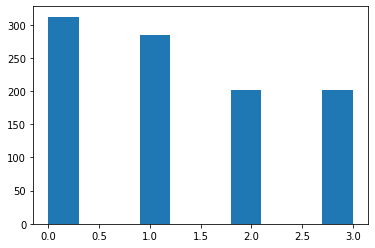

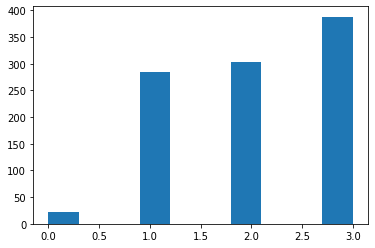

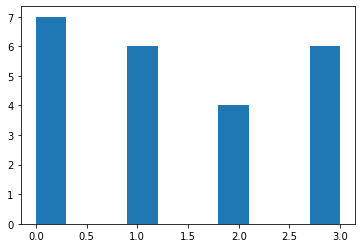

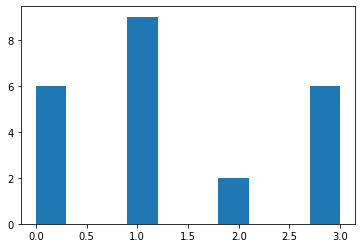

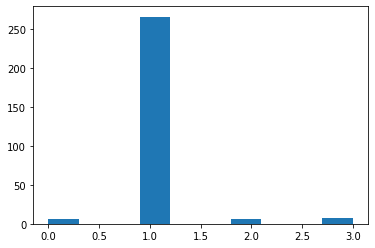

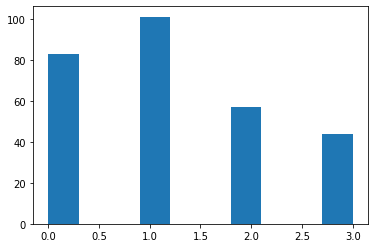

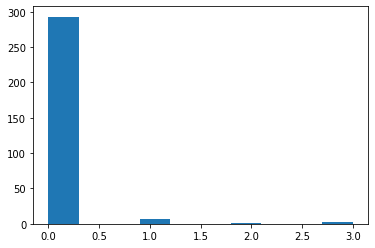

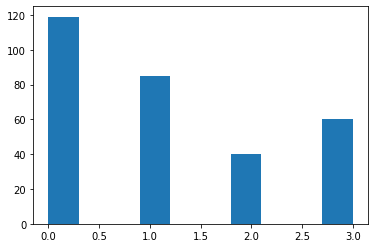

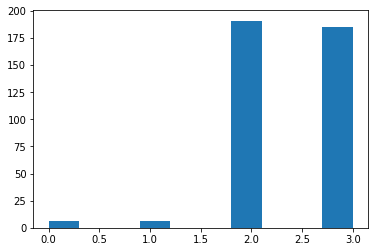

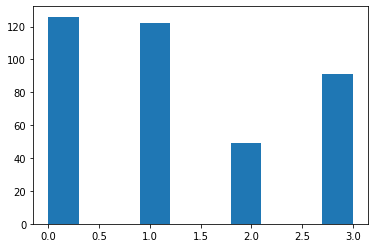

<Figure size 432x288 with 0 Axes>

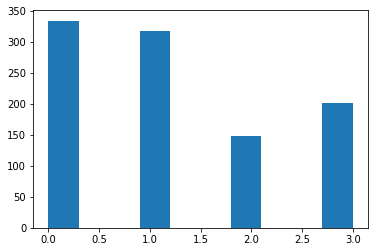

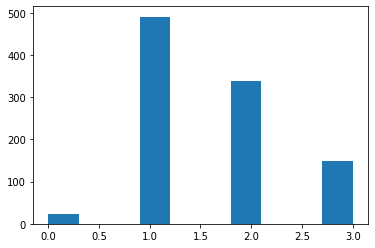

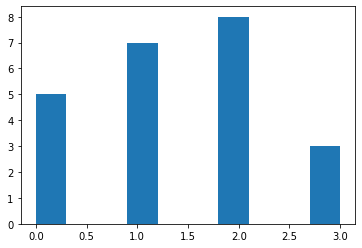

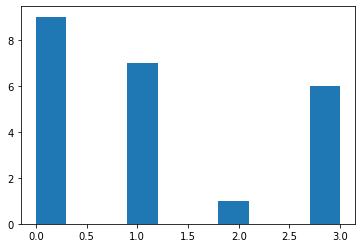

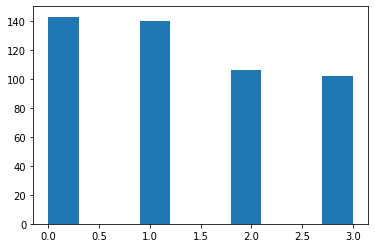

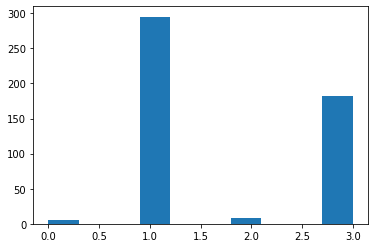

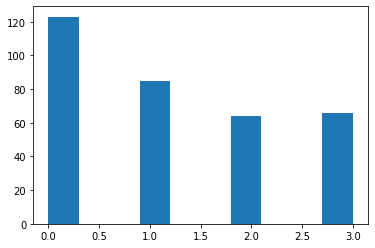

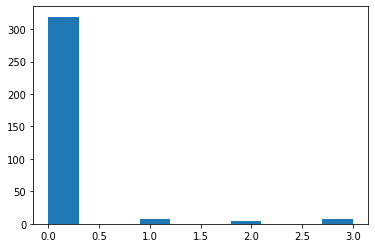

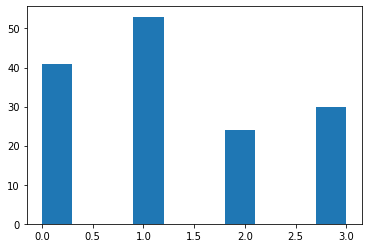

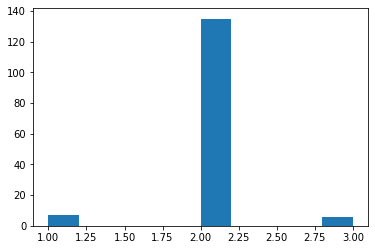

<Figure size 432x288 with 0 Axes>

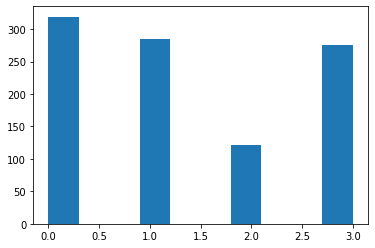

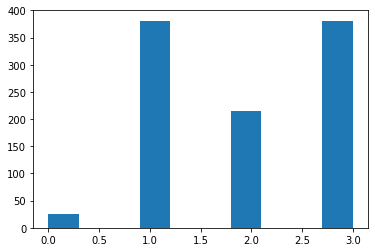

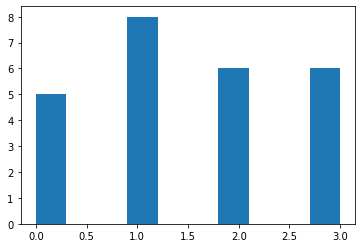

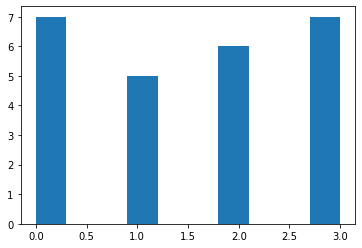

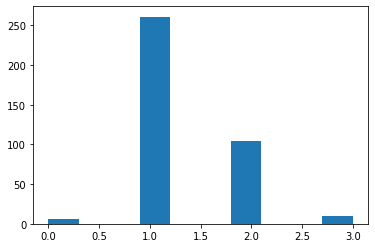

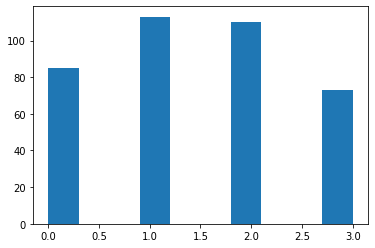

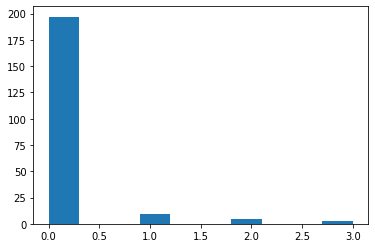

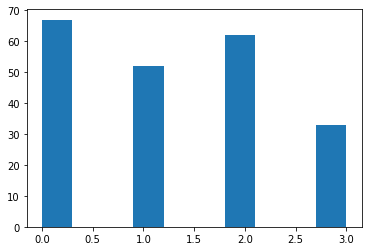

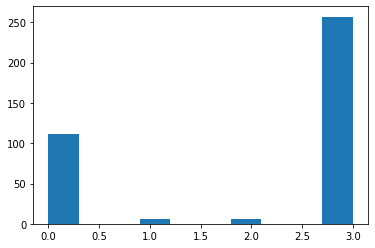

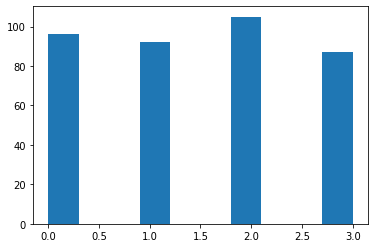

<Figure size 432x288 with 0 Axes>

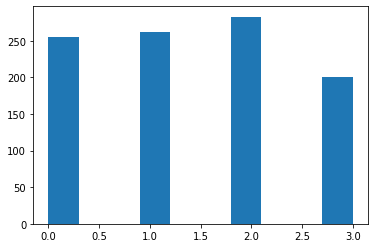

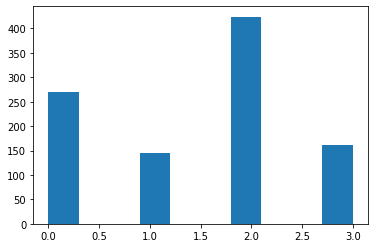

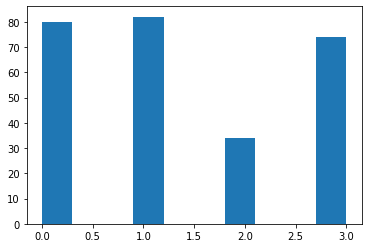

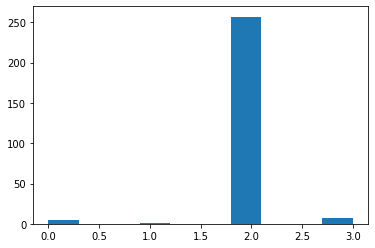

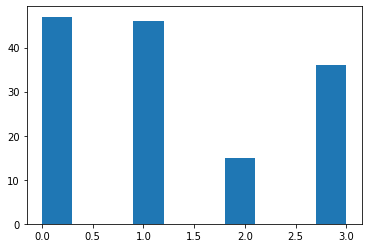

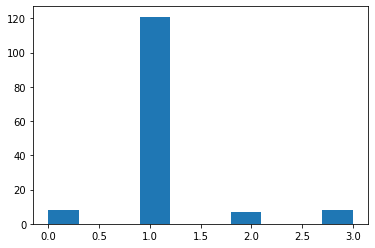

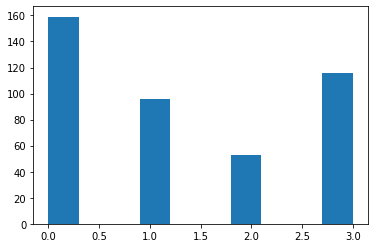

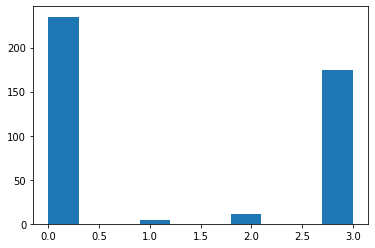

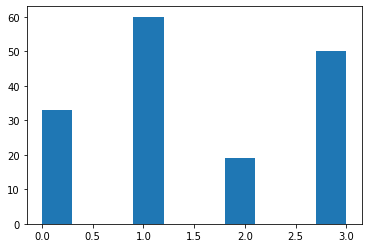

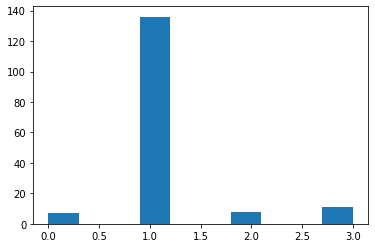

In [220]:
for i in range(len(games)):
    for j in range(len(games[i])):
        for k in range(len(games[i][j])):
            games[i][j][k] = np.array(games[i][j][k])
    
for i in range(2):
    plt.figure()
    plt.figure()
    plt.hist(games[i][2][0][-1000:])
    plt.figure()
    plt.hist(games[i][1][0][-1000:])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][0][-1000:] == 0])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][0][-1000:] == 0])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][0][-1000:] == 1])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][0][-1000:] == 1])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][0][-1000:] == 2])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][0][-1000:] == 2])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][0][-1000:] == 3])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][0][-1000:] == 3])

    plt.figure()
    plt.figure()
    plt.hist(games[i][2][1][-1000:])
    plt.figure()
    plt.hist(games[i][1][1][-1000:])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][1][-1000:] == 0])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][1][-1000:] == 0])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][1][-1000:] == 1])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][1][-1000:] == 1])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][1][-1000:] == 2])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][1][-1000:] == 2])
    plt.figure()
    plt.hist(games[i][2][0][-1000:][games[i][1][1][-1000:] == 3])
    plt.figure()
    plt.hist(games[i][2][1][-1000:][games[i][1][1][-1000:] == 3])

In [211]:
len(games)

2

In [ ]:
plt.figure()
plt.figure()
plt.hist(a2_act_arr[-1000:])
plt.figure()
plt.hist(a2_talk_arr[-1000:][who_talks_arr_2==0])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 0])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 1])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 2])
plt.figure()
plt.hist(a2_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])
plt.figure()
plt.hist(a1_act_arr[-1000:][who_talks_arr_2==0][a2_talk_arr[who_talks_arr_2==0] == 3])

## Compositionality

In [ ]:
class One_Talking_compositionality():

    # Enumeration of possible actions
    class Actions():
        silence = 0
        a = 1
        b = 2
        c = 3
        nothing = 4
        choose_1 = 5
        choose_2 = 6
        choose_3 = 7 #etc
        # choose entity - entity number (the range(num of entities))

    def __init__(
        self, num_ent, winning_reward, talking_reward = 0): #choose true or false

        # Action enumeration for this environment
        #d = {1:"a",2:"b",3:"c"}
        #for i in range(num_ent):
        #    d[i+4] = str(i+1)
        #self.actions = d
        self.num_ent = num_ent
        self.winning_reward = winning_reward
        self.talking_reward = talking_reward
        self.talking_decay = 0.995
        self.actions1 = collections.deque(maxlen=50)
        self.actions2 = collections.deque(maxlen=50)
                
    def step(self, ag1_action, ag2_action, choose, reward1 = 0, reward2 = 0):
        ag1_input = np.array([np.random.random()]) #UNIFORM/bimodal NOISE
        ag2_input = np.random.normal(0,0.01,(4,)) * 0 #talking binary (3) + noise
                
        if choose: # step of choice
            self.actions1.append(ag1_action)
            self.actions2.append(ag2_action)
            a1_rew = 0
            a2_rew = 0
            
            if len(self.actions1) > 49:
                a1_rew = ((1/self.num_ent) - self.actions1.count(ag1_action)/50) * 2
                a2_rew = ((1/self.num_ent) - self.actions2.count(ag2_action)/50) * 2
                
            if ag2_action == ag1_action: 
                reward1 = self.winning_reward + a1_rew
                reward2 = self.winning_reward + a2_rew
                
            else:
                reward1 = a1_rew#-1
                reward2 = a2_rew#-1
                    
        else: # agent 1 talking 
            if ag1_action == 1:
                ag2_input[0] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 2:
                ag2_input[1] += 1
                reward1 = self.talking_reward # * 0.995
            elif ag1_action == 3:
                ag2_input[2] += 1
                reward1 = self.talking_reward # * 0.995
        
        return(ag1_input, ag2_input, reward1, reward2)